# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

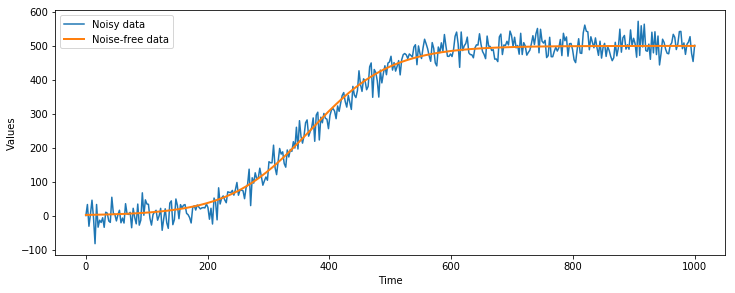

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

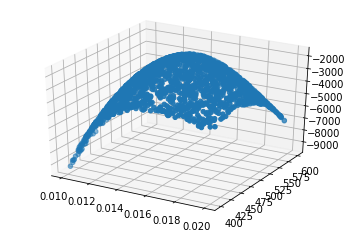

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,753
Trainable params: 82,753
Non-trainable params: 0
_________________________________________________________________


In [15]:
emu([0.015, 500])

array([[-1952.0928]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1883.4857553717798

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


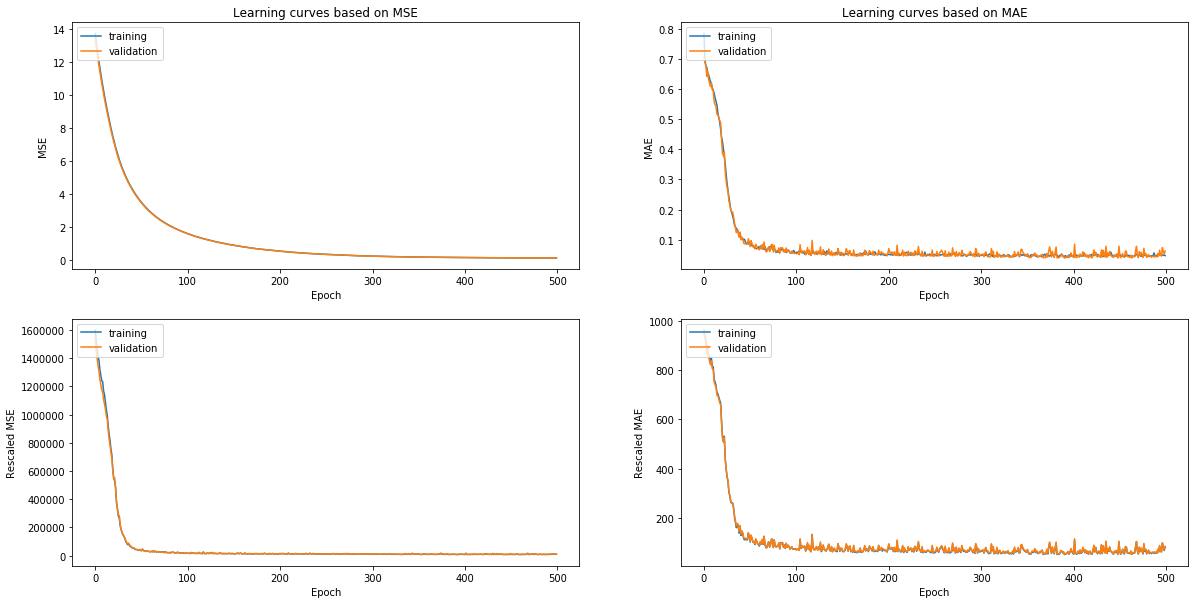

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [43]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")

rescaled_val_mse = hist.history["val_rescaled_mse"]
print("Minimum rescaled MSE during validation:", min(rescaled_val_mse))
idx_res_mse = list(rescaled_val_mse).index(min(rescaled_val_mse))
print("Best epoch based on rescaled validation MSE:", idx_res_mse)
print("\n")

val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

rescaled_val_mae = hist.history["val_rescaled_mae"]
print("Minimum rescaled MAE during validation:", min(rescaled_val_mae))
idx_res_mae = list(rescaled_val_mae).index(min(rescaled_val_mae))
print("Best epoch based on rescaled validation MAE:", idx_res_mae)
print("\n")

print(val_mse[-1])
print(rescaled_val_mse[-1])
print(val_mae[-1])
print(rescaled_val_mae[-1])

Minimum MSE during validation: 0.13340157628059388
Best epoch based on validation MSE: 498


Minimum rescaled MSE during validation: 8612.00430184901
Best epoch based on rescaled validation MSE: 479


Minimum MAE during validation: 0.03901789593199889
Best epoch based on validation MAE: 390


Minimum rescaled MAE during validation: 52.692093630985305
Best epoch based on rescaled validation MAE: 390


0.13388001223405202
11588.695982621148
0.062254234502712884
84.07183074664346


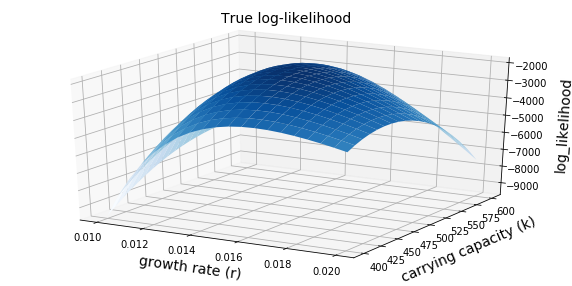

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

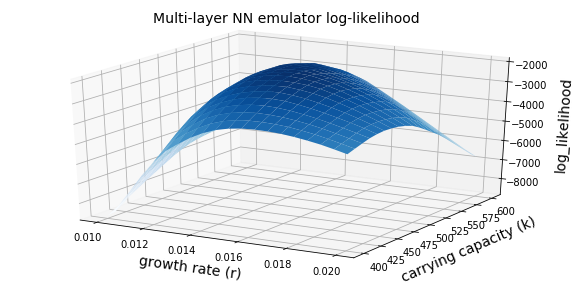

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.024498300504968498

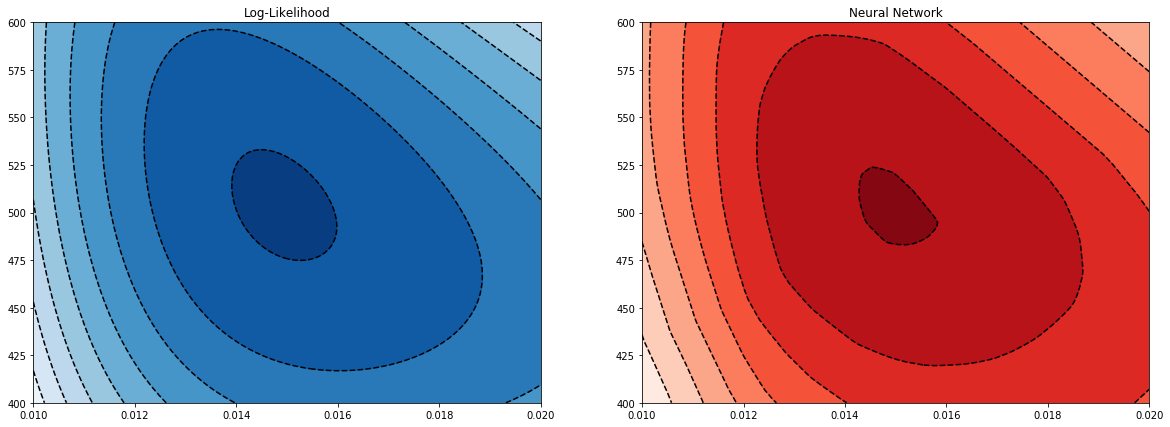

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

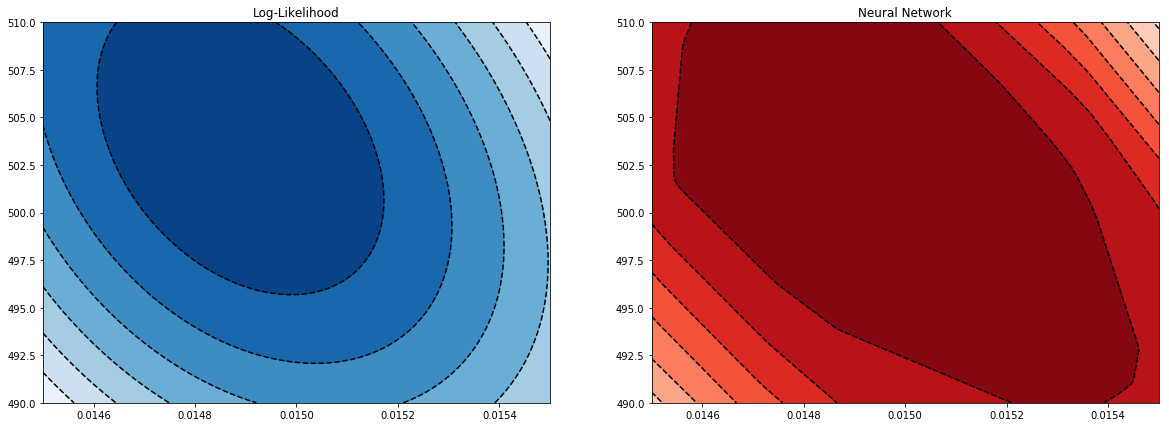

In [24]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [26]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [27]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[1.80119134e-02 4.47098130e+02]
-2781.371953425494
accepted


[2.99683192e-02 5.23135477e+02]
-inf


[4.05555405e-03 5.75479882e+02]
-inf


[2.16697397e-03 4.45911422e+02]
-inf


[3.80721732e-02 5.25248582e+02]
-inf


[2.82773069e-02 5.70293120e+02]
-inf


[2.99258836e-02 4.42522082e+02]
-inf


[-1.15248440e-02  5.25997915e+02]
-inf


[1.30564889e-02 5.70095300e+02]
-2639.427046126592
accepted


[1.00777646e-02 4.50816969e+02]
-7846.235608617819


[4.52291266e-03 5.22142762e+02]
-inf


[1.04317960e-02 5.68757507e+02]
-5566.376768882334


[6.05532193e-03 4.48046312e+02]
-inf


[1.66997000e-02 5.24890101e+02]
-2454.4120101065596


[1.58641553e-02 5.69578286e+02]
-2960.8046020133756


[4.70578261e-03 4.47504313e+02]
-inf


[1.03483935e-02 5.22622485e+02]
-5961.059738785041


[-2.71923695e-03  5.71955807e+02]
-inf


[1.19238471e-02 4.47879553e+02]
-4356.005783814222


[1.19931216e-02 5.25496848e+02]
-3215.9120061736785


[2.84595455e-02 5.68179234e+02]
-inf


[3.09682069e-02 4.5

[9.25940026e-03 5.21434397e+02]
-inf


[2.65715670e-02 5.64619821e+02]
-inf


[3.48457045e-02 4.52083882e+02]
-inf


[1.64815403e-02 5.18770275e+02]
-2288.989154874179


[3.79517964e-02 5.63455098e+02]
-inf


[1.18959171e-02 4.49584647e+02]
-4352.641556348359


[2.22346579e-02 5.22561267e+02]
-inf


[3.48323480e-02 5.58672234e+02]
-inf


[-6.05205523e-03  4.52429350e+02]
-inf


[1.68628171e-02 5.20493220e+02]
-2466.783243377967


[4.33802741e-03 5.64945507e+02]
-inf


[4.26036413e-02 4.48641865e+02]
-inf


[-2.87945191e-03  5.19657815e+02]
-inf


[1.45097257e-02 5.66881726e+02]
-2452.4824864092325


[-2.34391124e-03  4.51203931e+02]
-inf


[3.92106649e-02 5.20171917e+02]
-inf


[2.15745222e-02 5.64415407e+02]
-inf


[1.19954945e-02 4.47036062e+02]
-4283.117995722987


[2.53047560e-02 5.18558958e+02]
-inf


[1.21719521e-02 5.64309282e+02]
-3113.6060136276287


[6.14406645e-03 4.50121661e+02]
-inf


[3.87715391e-02 5.21882163e+02]
-inf


[-6.19992192e-03  5.64177782e+02]
-inf


[1.064995

[1.25225314e-02 4.59975866e+02]
-3403.7204134534177


[4.10853543e-02 5.14036088e+02]
-inf


[9.36524391e-03 5.65978616e+02]
-inf


[1.52515082e-02 4.53863598e+02]
-2250.375933143847
accepted


[6.99686301e-03 5.17651516e+02]
-inf


[6.74835193e-03 5.66224854e+02]
-inf


[6.24453506e-03 4.57473653e+02]
-inf


[3.89835389e-04 5.14903338e+02]
-inf


[3.21168501e-02 5.65591819e+02]
-inf


[9.63712273e-04 4.49932460e+02]
-inf


[2.31169856e-02 5.15832070e+02]
-inf


[3.40197852e-02 5.64346554e+02]
-inf


[1.03009799e-02 4.55115825e+02]
-7176.428877721154


[-7.63075750e-03  5.15217866e+02]
-inf


[3.87931930e-02 5.64925383e+02]
-inf


[-4.13599967e-03  4.53521216e+02]
-inf


[-2.03274100e-02  5.18787387e+02]
-inf


[1.56548453e-02 5.66842975e+02]
-2796.0402801277687


[9.09313375e-03 4.52736194e+02]
-inf


[2.66822636e-02 5.16411850e+02]
-inf


[-3.94477776e-04  5.62476101e+02]
-inf


[1.05787037e-02 4.53004268e+02]
-6579.21607857565


[2.70929074e-02 5.14238149e+02]
-inf


[-2.00773464e-0



[1.57021255e-02 4.54693655e+02]
-2232.432405904391


[1.47317814e-02 5.14287557e+02]
-1897.549429440413
accepted


[1.41757544e-02 5.64232639e+02]
-2375.6264179084037


[1.55739015e-02 4.54781266e+02]
-2228.4199349152295
accepted


[1.47666902e-02 5.14238610e+02]
-1897.446804403978
accepted


[1.36677792e-02 5.64116158e+02]
-2402.1051615666356


[1.54958999e-02 4.54880439e+02]
-2226.8970008626256
accepted


[1.48687059e-02 5.14215038e+02]
-1899.3647357088016


[1.39630568e-02 5.64350177e+02]
-2378.1260055531993


[1.55643358e-02 4.54962538e+02]
-2225.754712071328
accepted


[1.46043905e-02 5.14487883e+02]
-1900.7434941923736


[1.39198734e-02 5.64157290e+02]
-2377.227187870337


[1.54520720e-02 4.54899521e+02]
-2227.107103036601


[1.49528451e-02 5.14214032e+02]
-1903.064950994159


[1.43477293e-02 5.64189481e+02]
-2385.2434655900333


[1.56233748e-02 4.54831204e+02]
-2228.4058239467936


[1.46432973e-02 5.14153474e+02]
-1898.5952346090469


[1.38786444e-02 5.64221733e+02]
-2380.7686

[1.49146042e-02 5.11052363e+02]
-1891.563866253456


[1.48522865e-02 5.06400244e+02]
-1882.805292650838


[1.40620818e-02 5.63657489e+02]
-2365.0686505375506
accepted


[1.48967908e-02 4.87891811e+02]
-1921.6879774109198


[1.47232737e-02 5.12590003e+02]
-1893.165229677796


[1.41061877e-02 5.63946617e+02]
-2369.6162994010356


[1.46120043e-02 5.09619687e+02]
-1891.871445710201


[1.49557612e-02 5.00655167e+02]
-1883.1221230527042


[1.40712186e-02 5.63670013e+02]
-2365.2037757218213


[1.46562592e-02 5.09877675e+02]
-1890.0858804059744


[1.45965637e-02 5.13092225e+02]
-1897.892673584352


[1.40557912e-02 5.63758680e+02]
-2366.703862854438


[1.48712004e-02 4.89929183e+02]
-1913.1121494664924


[1.48876210e-02 5.07707794e+02]
-1884.4691337811216


[1.40241529e-02 5.63332269e+02]
-2360.6246697946835
accepted


[1.43476132e-02 5.06204181e+02]
-1917.819947598129


[1.47437546e-02 5.05027663e+02]
-1884.010744264812


[1.40289704e-02 5.63440326e+02]
-2362.179820316841


[1.47831096e-02 5.0

[1.49482005e-02 5.00217486e+02]
-1883.4333324861786


[1.36854677e-02 5.29314592e+02]
-2090.4636588231233


[1.48799341e-02 5.02768095e+02]
-1881.8819408088675
accepted


[1.50074056e-02 4.99081348e+02]
-1885.1630849005176


[1.36494316e-02 5.13593617e+02]
-2081.5639288536922


[1.49732201e-02 4.98687674e+02]
-1885.267311714042


[1.48260336e-02 5.06580409e+02]
-1883.0007532285915
accepted


[1.38358990e-02 5.27320916e+02]
-2043.6695216153169


[1.48843229e-02 5.03261748e+02]
-1881.7632972620006
accepted


[1.49846797e-02 5.01899991e+02]
-1882.9206073896971
accepted


[1.36564124e-02 5.15799524e+02]
-2077.4140344803627


[1.48182367e-02 5.07126611e+02]
-1883.4947963059856


[1.48836002e-02 5.06236960e+02]
-1882.8230269435483
accepted


[1.32282370e-02 4.94383851e+02]
-2368.7027655837774


[1.49628958e-02 5.05942731e+02]
-1884.0045540138901


[1.47869445e-02 5.08123719e+02]
-1884.7496005309047


[1.41607153e-02 5.08968762e+02]
-1946.7096801767682
accepted


[1.46804665e-02 5.04762742e+0

[1.49671541e-02 5.04140388e+02]
-1882.7916105670079
accepted


[1.50925939e-02 5.12358284e+02]
-1905.980626693562


[1.53520283e-02 4.88694408e+02]
-1922.045482923652


[1.49156377e-02 5.05694017e+02]
-1882.7635159895535
accepted


[1.49609395e-02 5.14040394e+02]
-1902.8772983473589


[1.47977135e-02 5.14429979e+02]
-1898.3648107066244


[1.49685921e-02 5.06621307e+02]
-1884.9496383702503
accepted


[1.48465098e-02 5.07328266e+02]
-1883.6536881598545
accepted


[1.46393538e-02 5.08677107e+02]
-1889.6379009424884


[1.50864173e-02 5.07594072e+02]
-1892.2264824131564


[1.48374225e-02 5.09382703e+02]
-1886.4508656409425


[1.50203073e-02 4.96193437e+02]
-1889.7480462407484


[1.49192410e-02 5.09246499e+02]
-1887.676018116314


[1.49272193e-02 5.00694035e+02]
-1882.9647694244784
accepted


[1.43267113e-02 5.24823474e+02]
-1955.1919842317566


[1.49995966e-02 5.09569760e+02]
-1891.525282125266


[1.50382052e-02 4.97294213e+02]
-1888.0330461249998


[1.45506179e-02 5.10233992e+02]
-1896.226

[1.47990627e-02 5.04879698e+02]
-1882.5905802786144
accepted


[1.52988020e-02 4.94227779e+02]
-1904.4106004123626


[1.49323991e-02 5.06433074e+02]
-1883.7567160108276
accepted


[1.47813116e-02 5.02788000e+02]
-1883.5725797231357
accepted


[1.49186279e-02 4.98183887e+02]
-1886.1280356512507


[1.50380088e-02 4.98768415e+02]
-1886.082023001802


[1.48227600e-02 5.04011031e+02]
-1882.1882703516483
accepted


[1.51941907e-02 4.98191146e+02]
-1892.9019442021745


[1.46541791e-02 5.07651341e+02]
-1888.2586631080442


[1.46523975e-02 5.02784875e+02]
-1889.7439752617122


[1.50736961e-02 4.93497151e+02]
-1896.6739934974519


[1.50716860e-02 4.99404841e+02]
-1886.4247653277946


[1.47633868e-02 5.01980868e+02]
-1884.8240773467035


[1.52154672e-02 4.98487821e+02]
-1894.0052029457634


[1.46318236e-02 5.12507661e+02]
-1895.2491945434604


[1.48007024e-02 4.99681488e+02]
-1886.3616765801628


[1.49265716e-02 5.01040583e+02]
-1882.699106153526
accepted


[1.49128277e-02 5.05713233e+02]
-1882.7

[1.48262670e-02 5.01410533e+02]
-1883.4487503484872
accepted


[1.48774025e-02 5.02846600e+02]
-1881.8702129168194
accepted


[1.48296963e-02 5.02156369e+02]
-1882.7789949943106


[1.48927205e-02 5.03610542e+02]
-1881.7458369033866
accepted


[1.48439950e-02 5.02482976e+02]
-1882.3396699804218
accepted


[1.48978544e-02 4.99483192e+02]
-1884.4022471209987
accepted


[1.50731411e-02 5.05003532e+02]
-1887.4449415706392


[1.46975378e-02 4.96682562e+02]
-1898.677284657449


[1.49068554e-02 5.01130247e+02]
-1882.6437905937064
accepted


[1.47101972e-02 5.00903254e+02]
-1888.6321207724661


[1.44686039e-02 5.09921523e+02]
-1902.6636847143425


[1.49469941e-02 5.02818049e+02]
-1882.1721705902535
accepted


[1.50518738e-02 5.07429158e+02]
-1889.8360681067068


[1.46986431e-02 5.04398199e+02]
-1885.9522453005638


[1.49318784e-02 5.04262676e+02]
-1882.1864740417218
accepted


[1.49173846e-02 5.02646241e+02]
-1881.926707867959
accepted


[1.49590403e-02 4.92471808e+02]
-1900.0699284362445


[1.

-1884.1179613837
accepted


[1.48843601e-02 4.99003424e+02]
-1885.2611621767494


[1.46017316e-02 5.06343179e+02]
-1891.0440839788055


[1.48565670e-02 5.02341111e+02]
-1882.2466075863217
accepted


[1.48410791e-02 5.04295489e+02]
-1881.9609567562134
accepted


[1.48176462e-02 5.03005036e+02]
-1882.5451224750962
accepted


[1.48252354e-02 5.05612332e+02]
-1882.4318418788991
accepted


[1.46519649e-02 5.01650173e+02]
-1891.1954890676216


[1.45862339e-02 5.04949029e+02]
-1892.6533513158856


[1.47786971e-02 5.07943362e+02]
-1884.653630184054


[1.48360307e-02 5.01996389e+02]
-1882.7687682589947
accepted


[1.49398853e-02 4.99228157e+02]
-1884.4869536671797


[1.48368714e-02 5.04341813e+02]
-1882.0047471658434
accepted


[1.5050900e-02 5.0318778e+02]
-1885.0352188315273
accepted


[1.45845424e-02 5.06116824e+02]
-1892.2953321651491


[1.46811180e-02 5.03925084e+02]
-1887.07420003544


[1.51564398e-02 5.01102269e+02]
-1889.75265452283


[1.48124552e-02 4.96644440e+02]
-1892.1280323704539


[1.48178555e-02 5.01916697e+02]
-1883.209470429088


[1.47952917e-02 5.01340178e+02]
-1884.3618261687518


[1.45411529e-02 5.10511600e+02]
-1897.163398605667


[1.50078771e-02 5.01317513e+02]
-1883.5853730819715


[1.50077851e-02 4.99289875e+02]
-1884.9516618692398


[1.47831458e-02 5.00489580e+02]
-1885.813215142309


[1.51117868e-02 5.09586344e+02]
-1898.7543595794973


[1.48370184e-02 5.13079136e+02]
-1894.948111831381


[1.46105641e-02 5.00151434e+02]
-1897.038094487753


[1.50627567e-02 4.99905357e+02]
-1885.7909675669798


[1.46903952e-02 4.97157887e+02]
-1897.8606958346306


[1.48328183e-02 5.06125252e+02]
-1882.6512636373614
accepted


[1.48326372e-02 5.03045382e+02]
-1882.2617101992212
accepted


[1.48574556e-02 5.05865759e+02]
-1882.4312441022666


[1.49284871e-02 5.08899501e+02]
-1887.2827034667475


[1.45352817e-02 4.99061787e+02]
-1907.036582512901


[1.49156884e-02 5.03509437e+02]
-1881.8501426651285
accepted


[1.48769170e-02 5.03937687e+02]
-1881.7529798645255
accepted


accepted


[1.50351267e-02 5.01211303e+02]
-1884.344152728396
accepted


[1.46472904e-02 5.14272445e+02]
-1898.7905805912137


[1.48869349e-02 5.06040029e+02]
-1882.6916950107175
accepted


[1.50656117e-02 4.99713096e+02]
-1886.0073241863652


[1.4949802e-02 5.0332542e+02]
-1882.2281996624413
accepted


[1.49071725e-02 5.09985954e+02]
-1888.8486565338371


[1.55855950e-02 4.95851257e+02]
-1932.4601719794907


[1.5098060e-02 5.0685975e+02]
-1891.5883112048236


[1.47639727e-02 5.08450240e+02]
-1885.4148113095005
accepted


[1.49527180e-02 5.02068922e+02]
-1882.3716301916943
accepted


[1.48407727e-02 5.02537979e+02]
-1882.359729744871
accepted


[1.45107480e-02 5.12075502e+02]
-1901.2677009289173


[1.48599258e-02 4.99846642e+02]
-1884.4947937184372


[1.4676904e-02 5.0069080e+02]
-1890.9936924718463


[1.51108210e-02 5.06264884e+02]
-1891.3997786771777


[1.48479275e-02 5.04498187e+02]
-1881.927741642483
accepted


[1.47252831e-02 5.02438081e+02]
-1886.002217623852
accepted


[1.472012

-1887.347078814501


[1.47520259e-02 5.11524954e+02]
-1890.5253310237213


[1.50307411e-02 5.04300554e+02]
-1884.8639761517225


[1.49878088e-02 5.04546613e+02]
-1883.5542258130404


[1.50299929e-02 4.98875468e+02]
-1885.7950116333036


[1.47964713e-02 5.09717536e+02]
-1886.9060420321262


[1.51725741e-02 5.02004722e+02]
-1891.0060103950966


[1.47971690e-02 5.00810784e+02]
-1884.9037649799877
accepted


[1.46456732e-02 5.02755622e+02]
-1890.2236843956912


[1.49609179e-02 5.09327825e+02]
-1889.255338427685


[1.49033475e-02 4.96537655e+02]
-1889.584183065882


[1.52008239e-02 5.01866792e+02]
-1892.8902705344622


[1.48942534e-02 4.99480559e+02]
-1884.4461922024564
accepted


[1.48921684e-02 5.04983122e+02]
-1882.0712688547699
accepted


[1.47629871e-02 5.11902830e+02]
-1891.2841099178165


[1.49287618e-02 4.98464720e+02]
-1885.5955984342797


[1.49772375e-02 4.96160017e+02]
-1889.6508897204797


[1.50819533e-02 5.01808725e+02]
-1885.9968200224134


[1.48456588e-02 5.00841018e+02]
-188

-1886.423714032318


[1.50161418e-02 5.06249062e+02]
-1886.2392681002675


[1.48054900e-02 4.94206473e+02]
-1899.609818229


[1.54213546e-02 4.97096716e+02]
-1912.1813174169167


[1.51162506e-02 5.02241199e+02]
-1887.7423247012705


[1.49216743e-02 5.02184957e+02]
-1882.0774599988554
accepted


[1.49944662e-02 5.01615549e+02]
-1883.193178419507
accepted


[1.49511958e-02 5.05162820e+02]
-1883.0295487389803
accepted


[1.51167545e-02 5.00579679e+02]
-1887.6673527992582


[1.51962799e-02 4.99007312e+02]
-1892.53410602173


[1.50259365e-02 5.07518138e+02]
-1888.6340985173447


[1.49685261e-02 4.94335758e+02]
-1894.1770289579713


[1.49333530e-02 5.01591778e+02]
-1882.389666670948
accepted


[1.49213951e-02 5.04257647e+02]
-1882.049452699074
accepted


[1.50385903e-02 5.02231401e+02]
-1884.3432749794467


[1.50720710e-02 4.98064616e+02]
-1887.7435246346822


[1.51461883e-02 5.02854246e+02]
-1889.774121086507


[1.49497486e-02 5.01829279e+02]
-1882.4165557583826
accepted


[1.50353797e-02 5

[1.51817651e-02 5.07981417e+02]
-1900.4190943528165


[1.49469609e-02 5.09866419e+02]
-1889.8931402444741


[1.51647738e-02 5.03033916e+02]
-1891.109830026285


[1.49195255e-02 4.96919326e+02]
-1888.4895891179722


[1.50343999e-02 4.98675352e+02]
-1886.106147061691


[1.49712772e-02 4.98342744e+02]
-1885.7344165078478


[1.47451014e-02 5.13851098e+02]
-1896.2673040727027


[1.50335735e-02 4.95939948e+02]
-1890.39586322739


[1.51361747e-02 4.96832481e+02]
-1891.5153480207687


[1.50770585e-02 5.00381917e+02]
-1886.042010878562


[1.50816196e-02 4.98048264e+02]
-1888.0438244679642


[1.50921946e-02 5.10162145e+02]
-1898.8684894756968


[1.48826569e-02 5.06679071e+02]
-1883.2170418042647
accepted


[1.50313936e-02 4.97451275e+02]
-1887.6753301402998


[1.48961119e-02 5.02839845e+02]
-1881.82954782238
accepted


[1.47577357e-02 5.12111191e+02]
-1891.7788121699034


[1.47586843e-02 4.96528718e+02]
-1895.1158356588328


[1.46963026e-02 4.97860352e+02]
-1895.5847688499248


[1.48964822e-02 5

[1.46829424e-02 5.09799646e+02]
-1889.013383290666


[1.49594978e-02 5.04519314e+02]
-1882.8064336153368


[1.47483067e-02 4.97357667e+02]
-1893.5377255162434


[1.49952155e-02 5.08481297e+02]
-1888.9752721364027


[1.48877021e-02 5.05295202e+02]
-1882.1999789794238
accepted


[1.47815640e-02 5.05245527e+02]
-1882.9923348720556
accepted


[1.48944500e-02 5.06732214e+02]
-1883.4068115067637
accepted


[1.49652873e-02 5.05459470e+02]
-1883.6132126736145


[1.47449053e-02 5.12609328e+02]
-1893.0186242757654


[1.49780415e-02 5.10015467e+02]
-1891.5448208708651


[1.49529735e-02 5.06985938e+02]
-1884.9458284915515


[1.45386871e-02 5.15608139e+02]
-1906.6379836826202


[1.47884147e-02 5.11479911e+02]
-1890.3201170262018


[1.48873521e-02 5.06996439e+02]
-1883.5994873374914


[1.46545445e-02 4.99199564e+02]
-1895.4842686326404


[1.50513121e-02 5.00869052e+02]
-1884.9568415448985


[1.51134718e-02 5.03934642e+02]
-1888.6188404375314


[1.46442504e-02 4.99215976e+02]
-1896.2549152085603


[1

[1.46651576e-02 5.10530631e+02]
-1890.6276539447797


[1.46767982e-02 5.15635150e+02]
-1902.1022521492005


[1.48620724e-02 4.98123803e+02]
-1887.2053642011958


[1.51592910e-02 5.00215095e+02]
-1889.9590783439432


[1.47032857e-02 5.07858145e+02]
-1886.3604137537948


[1.52049889e-02 4.99358815e+02]
-1892.944413780629


[1.51711938e-02 4.99276256e+02]
-1890.9355404170617


[1.46630333e-02 5.08171200e+02]
-1888.1603600684014


[1.48808505e-02 4.97999726e+02]
-1887.0170813943214


[1.49949424e-02 4.98187547e+02]
-1886.1190606456375


[1.48068721e-02 5.05481338e+02]
-1882.594246079467
accepted


[1.48365673e-02 4.98518462e+02]
-1887.1687514162597


[1.5142115e-02 4.8916249e+02]
-1912.0190375355876


[1.46446677e-02 4.98305651e+02]
-1898.399031723204


[1.48370390e-02 5.03418187e+02]
-1882.0837320244905
accepted


[1.47564868e-02 5.05399521e+02]
-1883.6405662927496


[1.48891732e-02 4.99991729e+02]
-1883.8643479190075


[1.48953378e-02 4.97156323e+02]
-1888.393981939983


[1.49989768e-02 

[1.48712330e-02 4.99299056e+02]
-1885.0447855615787


[1.49310377e-02 5.06941255e+02]
-1884.3129633824813


[1.50907535e-02 5.01217066e+02]
-1886.38462310515


[1.46734180e-02 5.07356423e+02]
-1887.2245345028186


[1.49670803e-02 5.00962805e+02]
-1883.030190757488
accepted


[1.49267566e-02 5.02877982e+02]
-1881.9511995145022
accepted


[1.45560100e-02 5.02579242e+02]
-1897.6730696857344


[1.50492452e-02 5.02074511e+02]
-1884.7097581776484


[1.49552059e-02 5.07730905e+02]
-1886.0967730912678


[1.48182349e-02 5.02563420e+02]
-1882.757744359677


[1.47741544e-02 5.10339665e+02]
-1888.0724394015213


[1.49256299e-02 5.02758949e+02]
-1881.9576218483471
accepted


[1.50600256e-02 4.99619641e+02]
-1885.8970819371855


[1.49329528e-02 5.00667877e+02]
-1882.995026384141
accepted


[1.51492030e-02 4.95595354e+02]
-1893.9704678724736


[1.49414032e-02 5.05756195e+02]
-1883.290736934353
accepted


[1.48528628e-02 5.02804000e+02]
-1882.0799727964923
accepted


[1.49670744e-02 5.01949041e+02]
-1

[1.50007445e-02 5.05493753e+02]
-1884.7615511631063


[1.48021693e-02 4.99682753e+02]
-1886.3077568481217


[1.49633733e-02 5.05417008e+02]
-1883.5257301606657
accepted


[1.47836392e-02 5.05896003e+02]
-1883.1282919671032


[1.49649717e-02 4.99359008e+02]
-1884.3955484613587


[1.48408585e-02 5.02265942e+02]
-1882.5094432442672
accepted


[1.47927984e-02 5.10090371e+02]
-1887.5546437349954


[1.46742932e-02 5.05872205e+02]
-1886.8340357488958


[1.4967591e-02 5.0570935e+02]
-1883.9057506256113
accepted


[1.48632776e-02 5.04423998e+02]
-1881.8409028855585
accepted


[1.52442356e-02 5.00470816e+02]
-1895.6575621943684


[1.47099197e-02 5.07248735e+02]
-1885.7361601164223


[1.48050394e-02 5.01982282e+02]
-1883.4785964819607


[1.51228206e-02 4.97787235e+02]
-1889.7894457491752


[1.48253007e-02 5.02773964e+02]
-1882.5046880704579
accepted


[1.46818454e-02 5.05162760e+02]
-1886.5356941589775


[1.50342229e-02 5.00109455e+02]
-1884.832720973769


[1.50591518e-02 5.04708082e+02]
-1886.44


[1.50992363e-02 5.05898492e+02]
-1890.0873952684096


[1.48260929e-02 5.01612656e+02]
-1883.2718621606175


[1.48852513e-02 5.05187761e+02]
-1882.128958808373
accepted


[1.48838108e-02 5.02846460e+02]
-1881.8455580230243
accepted


[1.48575398e-02 5.01258543e+02]
-1882.9871570794617


[1.47408539e-02 5.03545756e+02]
-1884.5291963297493


[1.48548954e-02 4.99864550e+02]
-1884.5717982069461


[1.49657457e-02 5.02981227e+02]
-1882.4692489348404
accepted


[1.50590008e-02 5.03096095e+02]
-1885.3317058573825


[1.47050955e-02 5.04923447e+02]
-1885.502281477444


[1.50093125e-02 5.03633074e+02]
-1883.7212684555398


[1.51599223e-02 4.92914793e+02]
-1900.2026667405248


[1.49330601e-02 5.01422282e+02]
-1882.478537736715
accepted


[1.50832668e-02 4.99376391e+02]
-1886.840438424267


[1.48956556e-02 5.07157066e+02]
-1883.8958274534066


[1.50431206e-02 5.02193255e+02]
-1884.4978627950768


[1.46039672e-02 5.04742840e+02]
-1891.451367813364


[1.49796785e-02 5.01448283e+02]
-1882.970531089105

[1.48460821e-02 5.01232875e+02]
-1883.2028711328796


[1.50102479e-02 5.08510126e+02]
-1889.7400204080257


[1.51998693e-02 5.05266518e+02]
-1896.4326747511475


[1.50768096e-02 5.00756747e+02]
-1885.9004364797722


[1.48428001e-02 5.11749872e+02]
-1891.4770670735609


[1.48059731e-02 5.03318806e+02]
-1882.6612144405328
accepted


[1.46737884e-02 5.07053071e+02]
-1887.0791703715915


[1.53650357e-02 5.03855509e+02]
-1910.6400861386066


[1.49665821e-02 5.00189646e+02]
-1883.5847963153212
accepted


[1.47190340e-02 5.02004565e+02]
-1886.744295094336


[1.53647448e-02 5.08937499e+02]
-1923.7355397094966


[1.48335254e-02 5.03430700e+02]
-1882.1290788630356
accepted


[1.54255857e-02 4.97096462e+02]
-1912.6313381873201


[1.48358516e-02 5.06874475e+02]
-1883.2064241941173
accepted


[1.50806536e-02 5.02006934e+02]
-1885.9608042205784


[1.48680124e-02 5.10977666e+02]
-1890.1037099500356


[1.45789557e-02 5.06933756e+02]
-1892.612184102626


[1.46544442e-02 5.00537416e+02]
-1892.8128790266

[1.49672627e-02 5.01213440e+02]
-1882.893329098583
accepted


[1.47841780e-02 5.10447741e+02]
-1888.2244155448543


[1.49463862e-02 4.98288252e+02]
-1885.792705427286


[1.48536767e-02 5.04227772e+02]
-1881.8589809568455
accepted


[1.49794679e-02 5.00172695e+02]
-1883.7380011745593


[1.47293715e-02 5.07329100e+02]
-1885.17100890178


[1.50199312e-02 5.01027013e+02]
-1883.9868094216636


[1.48669293e-02 5.08666820e+02]
-1885.577859593826


[1.49005424e-02 5.05822598e+02]
-1882.661576374059
accepted


[1.50141750e-02 5.03948992e+02]
-1884.0341795941765


[1.48423234e-02 5.14011547e+02]
-1897.922519520117


[1.47743297e-02 5.04381009e+02]
-1883.1570424618974


[1.48981110e-02 5.01844372e+02]
-1882.208381484897
accepted


[1.50056810e-02 5.00670315e+02]
-1883.829110422533


[1.48240017e-02 5.00294524e+02]
-1884.7475078949335


[1.50444077e-02 5.03176641e+02]
-1884.772971451662


[1.51427747e-02 5.04039820e+02]
-1890.5395007117747


[1.47826590e-02 5.06621433e+02]
-1883.5077827877574
acce

[1.49194577e-02 4.97158957e+02]
-1888.0010924532678


[1.49398055e-02 5.04756384e+02]
-1882.5404266887276
accepted


[1.52875279e-02 4.94051832e+02]
-1903.961345076727


[1.49343681e-02 5.02136570e+02]
-1882.1706912228324
accepted


[1.49675829e-02 5.04713502e+02]
-1883.1112772755587
accepted


[1.51108727e-02 5.03808279e+02]
-1888.3599155338757


[1.48765317e-02 5.05325238e+02]
-1882.1600192421367
accepted


[1.49942281e-02 5.01704546e+02]
-1883.1636701030668
accepted


[1.44955460e-02 5.06827704e+02]
-1899.6729492067136


[1.46294599e-02 5.09376044e+02]
-1890.7354952245164


[1.46784500e-02 5.00294739e+02]
-1891.573951829151


[1.47314382e-02 5.02525289e+02]
-1885.6415988341869


[1.48928374e-02 5.12929725e+02]
-1896.0483590570939


[1.49423904e-02 4.98906805e+02]
-1884.903835261093


[1.52370167e-02 4.96109406e+02]
-1897.5678660204608


[1.48072060e-02 5.09209688e+02]
-1886.0742631036003


[1.51013736e-02 5.02020124e+02]
-1886.9227609837426


[1.48946309e-02 5.09969767e+02]
-1888.48

-1884.764809410739


[1.51702277e-02 5.00138974e+02]
-1890.6050843964142


[1.45688811e-02 5.08423063e+02]
-1893.6734128550984


[1.47759947e-02 5.04868229e+02]
-1883.086044164919
accepted


[1.52707488e-02 5.00463071e+02]
-1897.7906867662102


[1.46005391e-02 5.01306448e+02]
-1895.7160813636053


[1.45769089e-02 5.08139320e+02]
-1892.9975665953696


[1.49031525e-02 5.08439088e+02]
-1885.8327151134715


[1.49551252e-02 5.07972884e+02]
-1886.485656902977


[1.48600837e-02 5.05464700e+02]
-1882.2036895776928
accepted


[1.49942637e-02 5.05957655e+02]
-1885.024676593345


[1.4865309e-02 5.0528734e+02]
-1882.1180337313845
accepted


[1.50588949e-02 5.05827142e+02]
-1887.6988097431706


[1.46343995e-02 5.01224886e+02]
-1893.1257999006289


[1.48958293e-02 5.04025399e+02]
-1881.7921206645462
accepted


[1.46904274e-02 5.04743258e+02]
-1886.2241213059494


[1.49345551e-02 5.05299285e+02]
-1882.7876648393635
accepted


[1.50361766e-02 5.01744168e+02]
-1884.2732718260795


[1.48971011e-02 5.069

[1.48797415e-02 4.97000337e+02]
-1889.0616581769307


[1.48822483e-02 5.02518803e+02]
-1881.956329135018
accepted


[1.50075011e-02 4.97326054e+02]
-1887.5633907426854


[1.50143795e-02 5.00582517e+02]
-1884.066257691216
accepted


[1.49043758e-02 5.09344524e+02]
-1887.469280717172


[1.49129673e-02 5.06570089e+02]
-1883.5202857079025


[1.51470959e-02 5.02288353e+02]
-1889.5199547271304


[1.49966473e-02 4.94337053e+02]
-1893.9975386784824


[1.46403488e-02 4.98430241e+02]
-1898.4433401135773


[1.51264157e-02 4.98300479e+02]
-1889.4101073320835


[1.48243372e-02 5.02555961e+02]
-1882.6373911797432
accepted


[1.51710291e-02 4.98579912e+02]
-1891.327463036644


[1.51037697e-02 5.11653936e+02]
-1904.4527904194774


[1.49793201e-02 5.02687211e+02]
-1882.7262058358383
accepted


[1.49615124e-02 5.02354066e+02]
-1882.4287451791156
accepted


[1.49720327e-02 4.97202020e+02]
-1887.5936141492766


[1.50871635e-02 4.96754073e+02]
-1889.9828773919007


[1.50058890e-02 5.05276249e+02]
-1884.735

[1.46564448e-02 5.09693174e+02]
-1889.858105703207


[1.49006603e-02 5.06001827e+02]
-1882.8052666944106
accepted


[1.49852096e-02 5.03510059e+02]
-1882.9903617173266
accepted


[1.48897907e-02 5.03712876e+02]
-1881.7436516464816
accepted


[1.51425805e-02 5.05990399e+02]
-1893.1452177337317


[1.49754362e-02 5.05402347e+02]
-1883.8483962821226
accepted


[1.49137060e-02 5.03068134e+02]
-1881.8433624698705
accepted


[1.49059288e-02 5.09889711e+02]
-1888.6096505906903


[1.49112081e-02 5.11700036e+02]
-1893.1427155720698


[1.48212113e-02 5.03938949e+02]
-1882.2199121667643
accepted


[1.49804644e-02 5.11521784e+02]
-1895.6662945817452


[1.49938844e-02 4.99416012e+02]
-1884.6157509496534
accepted


[1.50590851e-02 5.09995466e+02]
-1896.0614684894344


[1.51188374e-02 5.07120725e+02]
-1893.4877652936448


[1.47907913e-02 5.06524329e+02]
-1883.319308667973
accepted


[1.49797697e-02 4.97638554e+02]
-1886.8559416752585


[1.50092480e-02 5.01009496e+02]
-1883.7369771852898
accepted


[1.

-1890.133506388805


[1.48871522e-02 5.03675969e+02]
-1881.739702039293
accepted


[1.50613403e-02 5.01930101e+02]
-1885.1569556082318
accepted


[1.50701944e-02 4.96304615e+02]
-1890.3182038711152


[1.50509472e-02 5.04844233e+02]
-1886.186990604174


[1.50325228e-02 5.02921937e+02]
-1884.2488974749963
accepted


[1.49954283e-02 5.04646450e+02]
-1883.855195418662


[1.47223915e-02 5.01255868e+02]
-1887.4818041646447


[1.53195658e-02 4.92572923e+02]
-1909.0717153925946


[1.48311907e-02 5.05376803e+02]
-1882.285240967519
accepted


[1.49269951e-02 5.13063848e+02]
-1897.8149227163017


[1.50240737e-02 4.97319212e+02]
-1887.7719926205139


[1.48674371e-02 5.03317145e+02]
-1881.8154844290877
accepted


[1.50106652e-02 5.10533752e+02]
-1894.5381330082027


[1.52545541e-02 4.95541582e+02]
-1899.4274484393568


[1.48687730e-02 5.00078683e+02]
-1884.0419140800782


[1.48272750e-02 5.06818576e+02]
-1883.1836964059312


[1.52996425e-02 4.99104923e+02]
-1900.101599627162


[1.48909528e-02 5.022

[1.46071070e-02 5.10273099e+02]
-1892.837694225422


[1.47323081e-02 5.06512311e+02]
-1884.6492764614868


[1.48213509e-02 4.98955967e+02]
-1886.8619159856019


[1.48244915e-02 5.03434279e+02]
-1882.267247933301
accepted


[1.48230368e-02 5.07101340e+02]
-1883.4483252995933
accepted


[1.51224690e-02 4.99667307e+02]
-1888.258291969969


[1.46608023e-02 4.99904823e+02]
-1893.538437277061


[1.46174789e-02 5.10962604e+02]
-1893.220476788711


[1.50213789e-02 5.00079168e+02]
-1884.5421074853632
accepted


[1.47161150e-02 5.13263278e+02]
-1894.8836987038533


[1.50666524e-02 5.04431965e+02]
-1886.5508942947888


[1.53232016e-02 4.95536563e+02]
-1904.309690524394


[1.48406376e-02 5.03888516e+02]
-1881.9675349354313
accepted


[1.48108112e-02 5.13700900e+02]
-1896.3064493301742


[1.51398555e-02 4.97201627e+02]
-1891.177514870604


[1.48990550e-02 5.05853715e+02]
-1882.6684254351428
accepted


[1.47031378e-02 5.16271331e+02]
-1903.9609566254403


[1.51498651e-02 5.00023160e+02]
-1889.484529

[1.48879756e-02 5.03893904e+02]
-1881.752662945635
accepted


[1.49741568e-02 4.93674622e+02]
-1896.01569758616


[1.49291091e-02 5.05048405e+02]
-1882.5270198892113
accepted


[1.49666588e-02 5.06355817e+02]
-1884.56670588984


[1.50660320e-02 5.01390591e+02]
-1885.357639712387


[1.46531093e-02 5.12222834e+02]
-1893.9385339671305


[1.55079255e-02 4.82876711e+02]
-1957.0376926922013


[1.51366337e-02 4.96228749e+02]
-1892.4314751055324


[1.46802784e-02 5.12375425e+02]
-1893.4717637870208


[1.47134567e-02 5.09477712e+02]
-1887.7034934573956


[1.49762812e-02 5.01718267e+02]
-1882.8173569601875
accepted


[1.51747579e-02 5.03249235e+02]
-1891.97634096536


[1.50112864e-02 5.13259028e+02]
-1903.1329091770526


[1.50874253e-02 4.98203811e+02]
-1888.0505416613453


[1.44113292e-02 5.08699026e+02]
-1908.3090123666393


[1.45772636e-02 5.05311695e+02]
-1893.147700102968


[1.49693739e-02 5.04460650e+02]
-1883.004796370393
accepted


[1.46887984e-02 5.03893878e+02]
-1886.6876272555971


[1

[1.46163236e-02 5.05739389e+02]
-1890.173822559029


[1.50262751e-02 5.09114974e+02]
-1891.8781457000002


[1.49210611e-02 5.00334486e+02]
-1883.2875994789695
accepted


[1.48498197e-02 5.05169051e+02]
-1882.094404324897
accepted


[1.47979609e-02 5.07094571e+02]
-1883.6347212751018
accepted


[1.47813073e-02 5.04911911e+02]
-1882.9611473363718
accepted


[1.51683865e-02 5.08410036e+02]
-1900.3148694757365


[1.48101415e-02 5.15303644e+02]
-1901.5245547184584


[1.47257863e-02 4.99831134e+02]
-1889.5122709581217


[1.46672102e-02 5.04654754e+02]
-1887.4582601300267


[1.46859173e-02 5.16193970e+02]
-1903.813309015837


[1.47574880e-02 5.13006233e+02]
-1893.968227687881


[1.48881638e-02 5.05244854e+02]
-1882.1757120830516
accepted


[1.45875170e-02 5.07795716e+02]
-1892.1578248775088


[1.46729270e-02 5.07098941e+02]
-1887.1355656653477


[1.48767062e-02 5.07139227e+02]
-1883.639185035908


[1.49453794e-02 4.95905464e+02]
-1890.4119001026063


[1.48207767e-02 5.05568374e+02]
-1882.4560

[1.49323935e-02 4.99637290e+02]
-1884.0031762027663
accepted


[1.46914002e-02 5.01930208e+02]
-1888.3156921796856


[1.50827295e-02 5.10934400e+02]
-1900.4501389815398


[1.49994753e-02 5.01045497e+02]
-1883.5102792985597
accepted


[1.50907550e-02 4.96858384e+02]
-1889.9219031769728


[1.50090067e-02 4.96250273e+02]
-1889.5445467029897


[1.49994262e-02 5.00070961e+02]
-1884.1130520559304
accepted


[1.49888309e-02 4.99947782e+02]
-1884.0492814413535
accepted


[1.51376686e-02 5.02165753e+02]
-1888.9078676633433


[1.52336805e-02 5.03480092e+02]
-1896.8107301876244


[1.48913425e-02 5.02190392e+02]
-1882.0566970198088
accepted


[1.50243000e-02 4.99014605e+02]
-1885.5331452353118


[1.50060409e-02 4.97993498e+02]
-1886.5143962558082


[1.49120832e-02 4.99801561e+02]
-1883.8884165268507


[1.52692115e-02 5.00869144e+02]
-1897.7993055737452


[1.51441455e-02 4.94464510e+02]
-1895.9945792463582


[1.44212623e-02 5.11360882e+02]
-1908.3753190538116


[1.46987436e-02 5.06951227e+02]
-1885

-1887.5135910401198


[1.47987340e-02 5.08713699e+02]
-1885.3849322180536


[1.50548029e-02 5.08558746e+02]
-1892.2770635851884


[1.49654240e-02 4.97130277e+02]
-1887.7280717319113


[1.51337190e-02 4.98751637e+02]
-1889.3481545724683


[1.49859860e-02 5.01716118e+02]
-1882.9932469360508


[1.48961248e-02 5.04650520e+02]
-1881.958944182747
accepted


[1.47741707e-02 5.05192283e+02]
-1883.1541182593498
accepted


[1.50019837e-02 4.99227446e+02]
-1884.9248520889162


[1.47884022e-02 4.97209146e+02]
-1891.8097530954878


[1.50140149e-02 5.05644491e+02]
-1885.4237515435534


[1.47099116e-02 5.01034036e+02]
-1888.456868883742


[1.49748426e-02 5.11318643e+02]
-1894.797020310273


[1.48190283e-02 5.02547522e+02]
-1882.7502088019442
accepted


[1.49256607e-02 5.00294072e+02]
-1883.3198315620787
accepted


[1.49107612e-02 5.06728033e+02]
-1883.6514710953184


[1.48749786e-02 4.98857241e+02]
-1885.6512634076328


[1.48486222e-02 5.05527422e+02]
-1882.2534133791758
accepted


[1.48601906e-02 5.

[1.4808463e-02 5.0337684e+02]
-1882.5867206144899
accepted


[1.47734889e-02 5.11369736e+02]
-1890.087083980041


[1.50060471e-02 5.15944955e+02]
-1913.5520615055943


[1.48949523e-02 5.06889902e+02]
-1883.5817466577917


[1.48359951e-02 4.98360564e+02]
-1887.4799627209698


[1.51226394e-02 4.97652948e+02]
-1889.935339694879


[1.47327141e-02 5.07285471e+02]
-1885.0474270981929


[1.50131452e-02 5.02402819e+02]
-1883.5548690713238
accepted


[1.52838338e-02 4.99409753e+02]
-1898.7525594635108


[1.50699056e-02 5.00971334e+02]
-1885.5801968583091


[1.51315679e-02 5.00165546e+02]
-1888.4956493112306


[1.49931911e-02 4.95314237e+02]
-1891.5400979392193


[1.50157021e-02 5.00046145e+02]
-1884.4419949066298
accepted


[1.49788836e-02 5.08419651e+02]
-1888.1553804451444


[1.48659752e-02 5.08239285e+02]
-1884.924415349442
accepted


[1.49855605e-02 5.05205836e+02]
-1883.9831163309589
accepted


[1.51973039e-02 4.93636710e+02]
-1899.8677897956024


[1.48197506e-02 5.02851588e+02]
-1882.5738

[1.51215921e-02 4.97984854e+02]
-1889.5257888167137


[1.48692277e-02 5.00888287e+02]
-1883.156686661826
accepted


[1.47385831e-02 5.02554441e+02]
-1885.3042201420976


[1.51303226e-02 4.90219437e+02]
-1907.853811047632


[1.50891744e-02 4.97502244e+02]
-1888.9554830754892


[1.51925526e-02 5.07386801e+02]
-1899.964977249294


[1.4700439e-02 5.0372191e+02]
-1886.203219003309


[1.47415155e-02 5.02022375e+02]
-1885.6746319949777


[1.49867617e-02 5.09305176e+02]
-1890.3085956002174


[1.52366038e-02 5.02993545e+02]
-1896.5357610445026


[1.46952990e-02 5.02033916e+02]
-1887.9700996294362


[1.50171542e-02 4.99151756e+02]
-1885.2554057133661


[1.47352181e-02 4.96988952e+02]
-1895.2729691826241


[1.48815351e-02 5.07437801e+02]
-1884.04142043348
accepted


[1.50946234e-02 5.03017047e+02]
-1886.9487845813362


[1.49895372e-02 5.04013252e+02]
-1883.302375025132
accepted


[1.50014171e-02 5.07813749e+02]
-1888.0062993385886


[1.50523646e-02 4.97936893e+02]
-1887.397588048874


[1.50962515

[1.47872076e-02 4.98336498e+02]
-1889.3399462604514


[1.47997614e-02 5.04452645e+02]
-1882.5606937789255
accepted


[1.49752682e-02 5.12342416e+02]
-1897.879210119337


[1.49473286e-02 5.03262811e+02]
-1882.1840960584034
accepted


[1.46550492e-02 5.06300415e+02]
-1887.8289911440438


[1.49823059e-02 4.98057232e+02]
-1886.210337645299


[1.46980616e-02 5.04834815e+02]
-1885.8380233586593


[1.49387584e-02 5.09428252e+02]
-1888.6516037184256


[1.50904878e-02 5.00367074e+02]
-1886.5709420238659


[1.50305682e-02 5.00594753e+02]
-1884.457555298921


[1.48417597e-02 5.06367368e+02]
-1882.7851531368608
accepted


[1.51955078e-02 4.98659922e+02]
-1892.6690897762846


[1.50410878e-02 5.08895737e+02]
-1892.2181085725522


[1.49264149e-02 5.10858716e+02]
-1891.4895272045485


[1.49960671e-02 5.06793333e+02]
-1886.1581699248013


[1.47379865e-02 5.04118925e+02]
-1884.3880818315315


[1.50516421e-02 5.05318409e+02]
-1886.715726863545


[1.48832183e-02 4.99745406e+02]
-1884.2411965364124


[1.49

[1.48856977e-02 5.12290127e+02]
-1893.9383766064582


[1.48400011e-02 4.98463088e+02]
-1887.1688028883489


[1.49849638e-02 5.04813864e+02]
-1883.6541674131897
accepted


[1.49447872e-02 5.03827419e+02]
-1882.2452483167847
accepted


[1.50764136e-02 5.03393990e+02]
-1886.2611256239006


[1.49390225e-02 5.07162260e+02]
-1884.794873040786


[1.53052718e-02 5.00135964e+02]
-1900.7016005117332


[1.46376819e-02 5.13511087e+02]
-1897.2022243024448


[1.50609629e-02 5.06927565e+02]
-1889.4634872842412


[1.50823648e-02 5.03668138e+02]
-1886.7244775056015


[1.46876984e-02 5.05020065e+02]
-1886.2811984965522


[1.48782893e-02 4.98899453e+02]
-1885.5238574737457


[1.47297229e-02 5.03960668e+02]
-1884.7709141663936


[1.51564886e-02 5.04789004e+02]
-1892.3581516648153


[1.48022646e-02 5.05898858e+02]
-1882.8216790739132
accepted


[1.48627127e-02 5.08122294e+02]
-1884.7260906344807


[1.49301540e-02 5.10319779e+02]
-1890.3200672565908


[1.47231453e-02 5.10547404e+02]
-1889.0747469598352


[1



[1.48394880e-02 4.98757867e+02]
-1886.6548107279912
accepted


[1.47802195e-02 5.03008085e+02]
-1883.4737325381973


[1.45528598e-02 5.04188477e+02]
-1896.0161858401336


[1.49444552e-02 4.96000328e+02]
-1890.202004805592


[1.48249285e-02 4.95714563e+02]
-1894.068352216392


[1.49151584e-02 5.05272392e+02]
-1882.4593252170678
accepted


[1.48110807e-02 4.98059379e+02]
-1888.9339388946646


[1.47217198e-02 5.07273575e+02]
-1885.3646211263338


[1.46467387e-02 4.95470706e+02]
-1906.701693031073


[1.47375751e-02 5.03171623e+02]
-1884.8804681815561
accepted


[1.50190839e-02 5.02649364e+02]
-1883.7514025378207


[1.46084800e-02 5.11693826e+02]
-1894.7680631805613


[1.47837174e-02 4.99950092e+02]
-1886.5780723818045
accepted


[1.49924563e-02 5.01499578e+02]
-1883.1878714743907
accepted


[1.50752023e-02 5.00399705e+02]
-1885.9657052334057


[1.45657729e-02 5.07195671e+02]
-1893.5913112313096


[1.51543671e-02 4.99830078e+02]
-1889.7870085264651


[1.50200686e-02 5.01326066e+02]
-1883.

[1.54074239e-02 5.04168631e+02]
-1916.393283132665


[1.48379313e-02 4.97966823e+02]
-1888.1871216255493


[1.45665614e-02 5.04864029e+02]
-1894.280486253565


[1.51539183e-02 5.18595342e+02]
-1941.70256451766


[1.49881921e-02 4.94956898e+02]
-1892.4172066937897


[1.48676244e-02 4.93845540e+02]
-1898.0194932067309


[1.49861524e-02 5.05595931e+02]
-1884.3621286157793


[1.49892681e-02 4.95690606e+02]
-1890.6718031027801


[1.49622310e-02 4.95558299e+02]
-1891.079967921917


[1.48050447e-02 5.01695365e+02]
-1883.7251523377438


[1.50435011e-02 4.98711577e+02]
-1886.2688447168516


[1.48287442e-02 5.05252790e+02]
-1882.2624799614728


[1.50082278e-02 5.03426599e+02]
-1883.6071635060966


[1.49668303e-02 4.93562521e+02]
-1896.437021976967


[1.48474243e-02 5.05521612e+02]
-1882.2544038510146
accepted


[1.45956646e-02 5.10210583e+02]
-1893.3876129754037


[1.47867979e-02 4.94166152e+02]
-1900.77235907486


[1.45879626e-02 5.02588965e+02]
-1894.8144375490422


[1.50497413e-02 4.98021565e

-1888.1527294668829


[1.48666840e-02 5.10435696e+02]
-1888.8643318338193


[1.49424202e-02 5.07757202e+02]
-1885.745013080544


[1.51622943e-02 4.99370326e+02]
-1890.3996277016224


[1.45319309e-02 5.28994677e+02]
-1970.387824162258


[1.50364989e-02 5.00604617e+02]
-1884.614974175184


[1.50797915e-02 5.08849472e+02]
-1894.5396265017282


[1.50179889e-02 5.07584461e+02]
-1888.3647637349784


[1.46718834e-02 5.11633588e+02]
-1892.2328620887424


[1.49715297e-02 4.92704247e+02]
-1899.0867854253704


[1.50366268e-02 5.10678148e+02]
-1896.4894516166


[1.49155973e-02 4.99213186e+02]
-1884.6026274086748


[1.50540297e-02 5.04782039e+02]
-1886.2706112849935


[1.48170086e-02 5.10491883e+02]
-1888.3597197691236


[1.47073471e-02 5.12001184e+02]
-1892.1054033698347


[1.50378234e-02 4.97600395e+02]
-1887.5627856992094


[1.47770838e-02 5.11459947e+02]
-1890.2731792763443


[1.49545166e-02 5.08164907e+02]
-1886.789414378022


[1.45508970e-02 5.08875021e+02]
-1895.1871905652838


[1.49115167e-

[1.48775011e-02 5.05785755e+02]
-1882.4387710913156
accepted


[1.48531399e-02 5.15779309e+02]
-1904.4800787129466


[1.50214979e-02 5.02350959e+02]
-1883.7983298231907


[1.48101991e-02 5.08717671e+02]
-1885.348908085729


[1.49051507e-02 4.97988345e+02]
-1886.6246235364022


[1.49359141e-02 5.02452871e+02]
-1882.0985406576567
accepted


[1.49133333e-02 5.03796056e+02]
-1881.8619636702401
accepted


[1.48497049e-02 4.96874778e+02]
-1890.1815243433618


[1.46111666e-02 5.13647304e+02]
-1898.46823585497


[1.49884590e-02 5.02832016e+02]
-1882.9374415403227


[1.45310157e-02 5.13345151e+02]
-1901.967804567925


[1.49626023e-02 4.97256213e+02]
-1887.5000954021289


[1.49659975e-02 4.96906893e+02]
-1888.150583836855


[1.44742551e-02 5.14351678e+02]
-1907.9094331462259


[1.49454460e-02 5.07599196e+02]
-1885.5930456741528


[1.52075852e-02 4.96150695e+02]
-1895.815553259745


[1.49310799e-02 5.00688200e+02]
-1882.9747591362227


[1.49248043e-02 5.04826312e+02]
-1882.3350955747903
accepted


[1.47896884e-02 5.02485101e+02]
-1883.5258531813156


[1.53019179e-02 4.92097485e+02]
-1909.0156775644841


[1.4789312e-02 5.0526190e+02]
-1882.83443034712
accepted


[1.48076709e-02 5.07243286e+02]
-1883.6709901877093


[1.48889136e-02 5.04323461e+02]
-1881.825321748179
accepted


[1.46777767e-02 5.00267463e+02]
-1891.6678224603236


[1.49470530e-02 5.05752415e+02]
-1883.4149884652402
accepted


[1.49145706e-02 4.99105540e+02]
-1884.7569348532304


[1.48536116e-02 5.03111509e+02]
-1881.9699002275067
accepted


[1.51965919e-02 4.98831376e+02]
-1892.63986138757


[1.49890347e-02 5.00828327e+02]
-1883.4263483982088


[1.46757519e-02 5.04774941e+02]
-1886.9529982432211


[1.49622198e-02 5.05375051e+02]
-1883.4603475112172
accepted


[1.48295719e-02 5.01697442e+02]
-1883.1247477866646
accepted


[1.45980465e-02 5.12183424e+02]
-1896.09738497655


[1.48987489e-02 5.07934092e+02]
-1884.9689419790377


[1.49216923e-02 4.92588233e+02]
-1900.5194163536657


[1.48548069e-02 5.02687410e+02]
-1882

[1.52162839e-02 4.96723668e+02]
-1895.5795280989178


[1.49686612e-02 4.96570163e+02]
-1888.8122863386645


[1.48977068e-02 5.03705213e+02]
-1881.7631798129014
accepted


[1.49780903e-02 5.07186730e+02]
-1886.0484015118075
accepted


[1.49216362e-02 5.01141125e+02]
-1882.6216985854603
accepted


[1.50015844e-02 5.01025475e+02]
-1883.5629411172415
accepted


[1.51422888e-02 5.04919396e+02]
-1891.5316682479386


[1.47842427e-02 5.03674464e+02]
-1883.06070429954
accepted


[1.50876675e-02 4.97245031e+02]
-1889.2625546747433


[1.51857185e-02 5.07120366e+02]
-1898.7637891434133


[1.47584921e-02 5.00456924e+02]
-1886.8690440622483


[1.50105016e-02 4.92185728e+02]
-1900.4048465719666


[1.51502409e-02 5.05701962e+02]
-1893.2342384610988


[1.47360156e-02 5.00146040e+02]
-1888.4281342687514


[1.50296403e-02 5.03979603e+02]
-1884.6085727161023


[1.48727027e-02 5.08016038e+02]
-1884.687823848325
accepted


[1.47008404e-02 5.06511367e+02]
-1885.7540711887027


[1.51819365e-02 5.03553913e+02]

[1.49335077e-02 5.07749378e+02]
-1885.4837444277612


[1.51080467e-02 5.07440094e+02]
-1893.366232006097


[1.49441592e-02 5.04110068e+02]
-1882.3227726898967
accepted


[1.46540907e-02 5.06253282e+02]
-1887.877035175227


[1.50142033e-02 5.05512400e+02]
-1885.2886010169302


[1.49681944e-02 4.96524554e+02]
-1888.9065770683333


[1.49779960e-02 5.01662153e+02]
-1882.8645975797294
accepted


[1.49447188e-02 5.04262254e+02]
-1882.3905207477808
accepted


[1.49574142e-02 5.09284801e+02]
-1889.0284333137963


[1.49291182e-02 5.08569858e+02]
-1886.7032869778318


[1.49509647e-02 4.98007046e+02]
-1886.227400315997


[1.48338168e-02 5.03918418e+02]
-1882.0443748211085
accepted


[1.45393215e-02 5.09981510e+02]
-1896.7998755584604


[1.49784369e-02 5.01457985e+02]
-1882.9460467805582
accepted


[1.47625651e-02 5.01847501e+02]
-1884.985861894181


[1.49652429e-02 5.03755813e+02]
-1882.6039356244698
accepted


[1.51229632e-02 5.04585582e+02]
-1889.8510077671026


[1.49935717e-02 5.02130106e+02]



[1.48421942e-02 5.02611006e+02]
-1882.3020782711753
accepted


[1.47726594e-02 5.01949873e+02]
-1884.5132808926412


[1.50823174e-02 5.05011304e+02]
-1887.9438232618975


[1.48276668e-02 5.08412469e+02]
-1884.9254319122501


[1.48160758e-02 5.02303047e+02]
-1882.9680155375106


[1.52679272e-02 5.02544461e+02]
-1898.829043904322


[1.47326431e-02 4.99192823e+02]
-1890.3253268874548


[1.48556572e-02 5.12246103e+02]
-1893.0195739235319


[1.50301738e-02 5.00470922e+02]
-1884.5119099597034


[1.48752258e-02 5.05126762e+02]
-1882.0598197324878
accepted


[1.47686705e-02 5.08300467e+02]
-1885.1754676620667


[1.52106070e-02 4.95939978e+02]
-1896.2759786284198


[1.49132412e-02 5.02449860e+02]
-1881.9594850488108
accepted


[1.49129652e-02 4.97805173e+02]
-1886.8506221724097


[1.48622078e-02 5.09649698e+02]
-1887.2073250011197


[1.49963491e-02 4.97341051e+02]
-1887.4435896342745


[1.48108169e-02 5.08272024e+02]
-1884.7594462038498


[1.49759953e-02 4.96862289e+02]
-1888.2286671272295


[

[1.47699808e-02 4.99345427e+02]
-1888.1637016623163


[1.49774149e-02 5.06264990e+02]
-1884.800183478832


[1.44470324e-02 5.00451050e+02]
-1914.2080315998642


[1.47946890e-02 5.02414828e+02]
-1883.432661264864


[1.54283407e-02 5.05816794e+02]
-1922.9563179732156


[1.46730995e-02 5.14757069e+02]
-1899.5301539981313


[1.47651639e-02 5.02142756e+02]
-1884.6078765535108


[1.50643465e-02 5.02662076e+02]
-1885.401920395194


[1.50173012e-02 5.04729649e+02]
-1884.675685483473
accepted


[1.51030960e-02 5.01878116e+02]
-1886.9799473751657


[1.47658461e-02 5.09330798e+02]
-1886.522376878066


[1.48558583e-02 5.03818136e+02]
-1881.8364378396382
accepted


[1.46842120e-02 5.06218782e+02]
-1886.392259975981


[1.48637234e-02 5.01403070e+02]
-1882.7782430893392
accepted


[1.48317673e-02 5.05188051e+02]
-1882.214457731155
accepted


[1.47681033e-02 5.13177417e+02]
-1894.4268526530825


[1.48843157e-02 5.07013228e+02]
-1883.5818737995537


[1.49453763e-02 5.00686004e+02]
-1883.0288839397272
a

[1.49209326e-02 5.04530616e+02]
-1882.1448019536444
accepted


[1.46285122e-02 5.12488968e+02]
-1895.3387767640434


[1.51641402e-02 5.00419088e+02]
-1890.2081434405275


[1.45678275e-02 5.02561003e+02]
-1896.6125994576294


[1.49735674e-02 5.12853188e+02]
-1899.4400165016493


[1.51528850e-02 4.95664527e+02]
-1893.9946257588376


[1.47877114e-02 5.11778733e+02]
-1890.9920721355002


[1.46421336e-02 5.02533249e+02]
-1890.7204323560584


[1.49258164e-02 5.03585285e+02]
-1881.9476126205593
accepted


[1.51489881e-02 4.95499900e+02]
-1894.1313291953236


[1.47800931e-02 5.04878977e+02]
-1882.9877919618482


[1.51536658e-02 5.03616648e+02]
-1890.852498564683


[1.49533327e-02 5.04140697e+02]
-1882.5003649453386


[1.49681551e-02 5.02963808e+02]
-1882.513382507477


[1.46292328e-02 5.06633108e+02]
-1889.2993055046006


[1.48823854e-02 5.04012898e+02]
-1881.7584596261597
accepted


[1.49901121e-02 4.98624545e+02]
-1885.4820270348357


[1.50399890e-02 5.13826062e+02]
-1907.2835036066353


[1.

[1.50348498e-02 4.92077404e+02]
-1900.680134684705


[1.53564252e-02 4.89028912e+02]
-1921.2110371375422


[1.46953515e-02 4.99099726e+02]
-1892.7819730014737


[1.47523840e-02 5.08069692e+02]
-1885.216553279649


[1.48706669e-02 4.97499345e+02]
-1888.2222544827755


[1.50247014e-02 4.95501686e+02]
-1891.2337820501564


[1.49653906e-02 5.01898702e+02]
-1882.590368390249
accepted


[1.49151002e-02 5.01126703e+02]
-1882.6312895553858
accepted


[1.46151167e-02 5.03548274e+02]
-1891.5659996934835


[1.49100479e-02 4.94863410e+02]
-1893.6674165033992


[1.50542466e-02 4.97890043e+02]
-1887.5025158440262


[1.49032569e-02 5.06646154e+02]
-1883.4418979677775
accepted


[1.49746153e-02 5.09126603e+02]
-1889.389071530699


[1.47397275e-02 4.99251425e+02]
-1889.8256574478285


[1.48842767e-02 5.06194701e+02]
-1882.7935818970477
accepted


[1.46136816e-02 5.00668439e+02]
-1895.7554890549884


[1.48443788e-02 5.00491814e+02]
-1884.008626592718


[1.50406414e-02 5.05991192e+02]
-1887.0073115397533

[1.48894546e-02 5.11091891e+02]
-1890.8959909110927


[1.45559708e-02 5.10946780e+02]
-1896.6451484403826


[1.49020973e-02 5.07942530e+02]
-1885.044623423075


[1.47350023e-02 5.09921458e+02]
-1887.8552584662


[1.49930577e-02 5.09070104e+02]
-1890.0879569619851


[1.46286413e-02 5.03144206e+02]
-1890.9894058082095


[1.49030226e-02 5.03947826e+02]
-1881.8151384744033
accepted


[1.44186688e-02 5.16887547e+02]
-1918.232505242788


[1.47901101e-02 5.05954276e+02]
-1883.0349616223627
accepted


[1.49480949e-02 5.00798354e+02]
-1882.962366842423


[1.48580046e-02 5.16741437e+02]
-1908.5057564200974


[1.49291774e-02 5.09250147e+02]
-1887.9784164346931


[1.49578872e-02 5.04580784e+02]
-1882.8046566247074


[1.47289834e-02 5.09322359e+02]
-1887.1327787391272


[1.48055785e-02 5.09096397e+02]
-1885.9048679911525


[1.50361812e-02 5.04489261e+02]
-1885.226660476778


[1.48638126e-02 5.04919905e+02]
-1881.9694688947438
accepted


[1.46723222e-02 4.97359274e+02]
-1898.678800494896


[1.486104

[1.46575669e-02 5.07161118e+02]
-1887.883351726672


[1.47877300e-02 4.99996275e+02]
-1886.3524000517828


[1.47242456e-02 5.02171250e+02]
-1886.3128582935706


[1.48091219e-02 5.02258216e+02]
-1883.16360770359


[1.5000815e-02 5.0593576e+02]
-1885.2406305814368


[1.49187162e-02 5.02947376e+02]
-1881.8851482624777
accepted


[1.46267915e-02 5.06178045e+02]
-1889.4413015577827


[1.48149685e-02 5.05046192e+02]
-1882.3630923251978
accepted


[1.46497281e-02 5.06127179e+02]
-1888.1102907770028


[1.47300301e-02 5.04191360e+02]
-1884.6685883242055


[1.46543388e-02 5.05476827e+02]
-1887.9201716377524


[1.49696595e-02 5.05620251e+02]
-1883.8800787138189


[1.50001943e-02 5.10140262e+02]
-1892.9431628045065


[1.48752198e-02 5.09909152e+02]
-1887.9342061004825


[1.50807546e-02 5.04665542e+02]
-1887.4894040868398


[1.47393429e-02 5.04851854e+02]
-1884.1719944772683


[1.47337096e-02 5.05315800e+02]
-1884.3473030287519
accepted


[1.48674849e-02 5.08878384e+02]
-1885.9254862925145


[1.471

[1.48061851e-02 5.02096021e+02]
-1883.3582282283378
accepted


[1.48555853e-02 5.09899428e+02]
-1887.5865563508073


[1.48721355e-02 5.09503476e+02]
-1887.0931300046047


[1.45323367e-02 5.10691958e+02]
-1897.9818500690362


[1.49524936e-02 5.05646152e+02]
-1883.4494233763187


[1.47461019e-02 5.05278641e+02]
-1883.937826128498
accepted


[1.47034793e-02 5.00592213e+02]
-1889.498017114667


[1.50106689e-02 5.05097460e+02]
-1884.7449273626505


[1.48842765e-02 5.08406255e+02]
-1885.4238630343623


[1.49046871e-02 5.03840834e+02]
-1881.8090477962944
accepted


[1.47882901e-02 5.05720653e+02]
-1882.9776721640542


[1.47353938e-02 5.08388193e+02]
-1885.9031760892665


[1.50948427e-02 4.97198504e+02]
-1889.544399913109


[1.47452823e-02 5.03367694e+02]
-1884.4564728874118


[1.46609268e-02 5.08619475e+02]
-1888.5962859563574


[1.51473487e-02 4.92360329e+02]
-1901.3361354868755


[1.51812664e-02 4.98047772e+02]
-1892.2879316549654


[1.46142929e-02 5.10137813e+02]
-1892.3073861231578


[1.4

[1.46322459e-02 5.09164489e+02]
-1890.3992243122818


[1.45909180e-02 5.06385334e+02]
-1891.7881205937026


[1.50198427e-02 5.07472824e+02]
-1888.2593073951791


[1.49261789e-02 5.07501931e+02]
-1884.937225329702


[1.46813611e-02 4.99353609e+02]
-1893.194722849513


[1.49163976e-02 5.05414569e+02]
-1882.5704716719172


[1.48105612e-02 5.06417884e+02]
-1883.0058731743911
accepted


[1.46847496e-02 5.04970639e+02]
-1886.4368282528524
accepted


[1.46331468e-02 5.13995473e+02]
-1898.5067617902216


[1.48684796e-02 5.03760421e+02]
-1881.76951267113
accepted


[1.45231149e-02 5.01679130e+02]
-1902.4526393071196


[1.47172381e-02 5.09551388e+02]
-1887.7058428038918


[1.49015140e-02 4.97963507e+02]
-1886.7214063235376


[1.47565261e-02 5.09627317e+02]
-1887.0737781093776


[1.46067996e-02 5.03404832e+02]
-1892.3309458332608


[1.50412585e-02 5.06638956e+02]
-1887.954393944594


[1.45834701e-02 5.03700259e+02]
-1893.8774561312646


[1.45853002e-02 5.05252084e+02]
-1892.5573557997125


[1.470



[1.51197536e-02 4.91082815e+02]
-1904.6760187987488


[1.46754241e-02 5.03422033e+02]
-1887.7399309388027


[1.50248222e-02 5.01212700e+02]
-1884.0494496181966


[1.50758768e-02 4.91526028e+02]
-1902.6555506787017


[1.48654463e-02 5.02472104e+02]
-1882.0900748337597
accepted


[1.49117022e-02 4.94363420e+02]
-1895.0612359864433


[1.50647845e-02 5.06540727e+02]
-1889.046162655551


[1.46765946e-02 5.06866673e+02]
-1886.8873815378022


[1.48100974e-02 5.04871710e+02]
-1882.4026534202808
accepted


[1.49873178e-02 5.07058756e+02]
-1886.202347484004


[1.48855252e-02 5.10700172e+02]
-1889.8649495129741


[1.44632980e-02 5.12228717e+02]
-1905.3075807878647


[1.48286121e-02 5.05153762e+02]
-1882.2326266966238
accepted


[1.47441623e-02 5.11758120e+02]
-1891.085379514261


[1.48380516e-02 5.05768260e+02]
-1882.4182088236398
accepted


[1.49218116e-02 5.07756840e+02]
-1885.1986257299734
accepted


[1.49117433e-02 5.05329677e+02]
-1882.4511671813846


[1.45947100e-02 5.07992293e+02]
-1891.

[1.50467389e-02 4.98914254e+02]
-1886.1364379222346


[1.50918176e-02 5.04490685e+02]
-1887.911867875641


[1.49018081e-02 4.98493683e+02]
-1885.8095263345892


[1.46119441e-02 5.06556951e+02]
-1890.3602041243755


[1.48672516e-02 5.02627153e+02]
-1882.0094062088451
accepted


[1.47086381e-02 4.99482607e+02]
-1891.1594343839345


[1.48167063e-02 5.04880413e+02]
-1882.3075968994924
accepted


[1.49515621e-02 5.03198315e+02]
-1882.2428737122677
accepted


[1.49107219e-02 4.99551012e+02]
-1884.1995956343508


[1.47427013e-02 5.05034010e+02]
-1884.045210443961


[1.51469449e-02 4.99942743e+02]
-1889.353457694256


[1.46932021e-02 5.08110831e+02]
-1886.906238927345


[1.47974935e-02 5.08952814e+02]
-1885.7221802206848


[1.47776364e-02 5.03882810e+02]
-1883.174229020495
accepted


[1.50873589e-02 4.98750811e+02]
-1887.4969593244161


[1.45842827e-02 5.16022854e+02]
-1905.698518252383


[1.45938050e-02 5.04183511e+02]
-1892.6120236511051


[1.45783756e-02 4.99579967e+02]
-1901.2482930928209



[1.49478459e-02 5.01412210e+02]
-1882.5831741554937
accepted


[1.47936168e-02 5.06507937e+02]
-1883.2680484916757
accepted


[1.49744457e-02 5.05571094e+02]
-1883.9733145271816
accepted


[1.48488218e-02 4.99439749e+02]
-1885.3070611009616


[1.50164393e-02 5.07396761e+02]
-1887.9692415279312


[1.49463678e-02 5.09327444e+02]
-1888.7082230169003


[1.49568515e-02 5.02901464e+02]
-1882.3134757461683
accepted


[1.48033356e-02 5.06167486e+02]
-1882.9399832001052
accepted


[1.49528527e-02 5.04380944e+02]
-1882.5957114318983
accepted


[1.50497279e-02 4.98762838e+02]
-1886.365805963372


[1.49692021e-02 5.00684923e+02]
-1883.2325089806718


[1.52355029e-02 4.97772540e+02]
-1895.78031460617


[1.46201223e-02 5.01190962e+02]
-1894.2953493232644


[1.48061257e-02 5.03466367e+02]
-1882.6060061240596
accepted


[1.49604952e-02 5.02262829e+02]
-1882.4295652963683
accepted


[1.47765851e-02 5.01235826e+02]
-1885.1157504678695


[1.45547314e-02 5.07275934e+02]
-1894.4401932691258


[1.53486618e



[1.48919298e-02 5.04852770e+02]
-1882.0124244371468
accepted


[1.48907102e-02 4.97636440e+02]
-1887.5152591576177


[1.46174395e-02 5.04245323e+02]
-1890.816782649461


[1.50371905e-02 4.97507789e+02]
-1887.6884135331682


[1.50276365e-02 5.07530127e+02]
-1888.7396214078256


[1.49867078e-02 4.99312686e+02]
-1884.6345904325576


[1.46752354e-02 5.07936592e+02]
-1887.476969282737


[1.48858828e-02 5.01226781e+02]
-1882.6838870754752
accepted


[1.49465072e-02 5.04156335e+02]
-1882.3803021272558
accepted


[1.50866501e-02 4.98833264e+02]
-1887.3979504776783


[1.50075858e-02 5.06651825e+02]
-1886.425699103847


[1.45948875e-02 5.05273601e+02]
-1891.829881807013


[1.47996523e-02 5.04471098e+02]
-1882.5623504091138
accepted


[1.50687044e-02 4.98095903e+02]
-1887.612078372733


[1.48254808e-02 5.04041529e+02]
-1882.1458190226365
accepted


[1.49417636e-02 5.03264882e+02]
-1882.105994746277
accepted


[1.51944382e-02 4.90969616e+02]
-1906.9483076144495


[1.47569928e-02 4.97875607e+02]


[1.45939004e-02 5.04404090e+02]
-1892.4318173248614


[1.47526544e-02 5.09707232e+02]
-1887.2468701818148


[1.49799414e-02 5.02954322e+02]
-1882.7544136053955
accepted


[1.47330381e-02 5.05950054e+02]
-1884.4488312622973
accepted


[1.50502666e-02 5.07056277e+02]
-1889.0934359217745


[1.46341006e-02 5.06036644e+02]
-1889.0102520956796


[1.46714526e-02 5.04465819e+02]
-1887.3087749061385


[1.50635641e-02 5.04277761e+02]
-1886.270670702929


[1.48117332e-02 5.09158911e+02]
-1885.993285857306


[1.4905442e-02 5.0411779e+02]
-1881.863334138451
accepted


[1.50078451e-02 5.01550547e+02]
-1883.513992672768


[1.48321706e-02 5.05907108e+02]
-1882.5258909125187
accepted


[1.47389033e-02 5.05695852e+02]
-1884.2105000600159


[1.53155191e-02 5.09251216e+02]
-1918.4179041731456


[1.49725522e-02 5.03427675e+02]
-1882.6711516917662
accepted


[1.50172388e-02 5.03988871e+02]
-1884.1619869341387
accepted


[1.48943371e-02 5.04987401e+02]
-1882.0879791974683
accepted


[1.50507574e-02 5.0271528

accepted


[1.48164368e-02 5.01174917e+02]
-1883.922945597805
accepted


[1.50934052e-02 5.01872646e+02]
-1886.5177811137703
accepted


[1.51671181e-02 5.00809736e+02]
-1890.371614854662


[1.49147639e-02 5.05604480e+02]
-1882.6826707152134
accepted


[1.50870493e-02 5.07088066e+02]
-1891.2983399557645


[1.49242871e-02 5.07440390e+02]
-1884.8069150186802


[1.49914051e-02 5.08005031e+02]
-1887.9128281255191


[1.51026181e-02 5.06999701e+02]
-1892.1433040019635


[1.48751690e-02 5.08852183e+02]
-1885.994457971443


[1.52273696e-02 5.07309967e+02]
-1903.0368348626819


[1.51567381e-02 4.97294718e+02]
-1891.8070682375906


[1.48465729e-02 5.02272617e+02]
-1882.417052742264
accepted


[1.49134152e-02 5.04199496e+02]
-1881.9487018024229
accepted


[1.50501599e-02 5.03109439e+02]
-1884.9734993772488
accepted


[1.48575651e-02 5.01164754e+02]
-1883.0698864684746
accepted


[1.48686293e-02 5.08189125e+02]
-1884.8827280528735


[1.53176473e-02 5.01151856e+02]
-1902.3408494402913


[1.50112691e

[1.48067333e-02 4.96610402e+02]
-1892.4626041682318


[1.50255112e-02 5.08383995e+02]
-1890.256884025662


[1.48350640e-02 5.06189606e+02]
-1882.6820232551634
accepted


[1.52319547e-02 4.97496546e+02]
-1895.7675242058149


[1.47849541e-02 5.14132910e+02]
-1897.275046849166


[1.48621200e-02 5.08293625e+02]
-1884.9614218857778


[1.46827025e-02 5.04353547e+02]
-1886.7618348622025


[1.49488480e-02 4.99521752e+02]
-1884.1436680663758
accepted


[1.51290766e-02 5.03502133e+02]
-1889.184814767557


[1.53182987e-02 4.95566386e+02]
-1903.8900248573095


[1.48238214e-02 5.02175783e+02]
-1882.8851001928526
accepted


[1.49493770e-02 5.03951224e+02]
-1882.3590286584292
accepted


[1.50915299e-02 5.01888965e+02]
-1886.4332883545997


[1.46956041e-02 4.90769101e+02]
-1921.6039778632328


[1.50210537e-02 5.01637292e+02]
-1883.8375829244949


[1.50675262e-02 4.97678585e+02]
-1888.1096233062003


[1.46992225e-02 5.03554253e+02]
-1886.3698788825307


[1.50083819e-02 5.02923113e+02]
-1883.47560781715

[1.49914088e-02 5.10400799e+02]
-1893.1549738461997


[1.49417336e-02 4.95589265e+02]
-1891.208309713038


[1.50015857e-02 4.99602356e+02]
-1884.5485224160554
accepted


[1.48330159e-02 5.09477182e+02]
-1886.5811021497323


[1.47475346e-02 5.14095577e+02]
-1896.96523693679


[1.53531755e-02 5.00739187e+02]
-1905.6202719135647


[1.48776327e-02 4.96724742e+02]
-1889.7292465967248


[1.48588928e-02 5.00136156e+02]
-1884.1445338356316


[1.45758116e-02 5.06841165e+02]
-1892.8421063719943


[1.48622327e-02 5.00866497e+02]
-1883.2786523804366


[1.50421611e-02 4.97648407e+02]
-1887.5753223928189


[1.51192710e-02 5.01858962e+02]
-1887.7966325379218


[1.51017253e-02 5.07329109e+02]
-1892.7127606177507


[1.48649736e-02 5.06518528e+02]
-1882.939214921968


[1.50530958e-02 5.02426848e+02]
-1884.8936951370622
accepted


[1.49839907e-02 4.96462659e+02]
-1889.0201534243847


[1.47815944e-02 5.04100957e+02]
-1883.014675802173
accepted


[1.50541969e-02 4.98947128e+02]
-1886.2972617494445
accepted

[1.49600804e-02 5.07371983e+02]
-1885.705603842795


[1.52301240e-02 4.96244333e+02]
-1896.978431050271


[1.48447608e-02 5.02924874e+02]
-1882.1324744371518
accepted


[1.50038828e-02 5.08891368e+02]
-1890.2216493195613


[1.51892713e-02 5.02544751e+02]
-1892.4619630202599


[1.47192071e-02 5.05337852e+02]
-1884.8766173381034


[1.48849556e-02 5.03723083e+02]
-1881.7396729008192
accepted


[1.48830211e-02 4.95889689e+02]
-1891.6034588987554


[1.50036897e-02 4.98449048e+02]
-1885.8617759760832


[1.51417655e-02 5.03067024e+02]
-1889.6402819257532


[1.48263303e-02 4.98617850e+02]
-1887.3053716299414


[1.48478041e-02 5.02166011e+02]
-1882.462139176863


[1.50717103e-02 5.11548742e+02]
-1901.5630182298655


[1.50384255e-02 5.07548416e+02]
-1889.3252990924973


[1.49437255e-02 5.03884479e+02]
-1882.2438220423476
accepted


[1.49392740e-02 5.07365104e+02]
-1885.0793565696656


[1.47361681e-02 5.06427096e+02]
-1884.497929014537


[1.45580744e-02 5.07333479e+02]
-1894.1842788023432


[1.46

[1.50442622e-02 4.94208802e+02]
-1894.4750843992847


[1.47596827e-02 5.05739879e+02]
-1883.6185378570897
accepted


[1.47179060e-02 5.07424474e+02]
-1885.5793936674245


[1.49263873e-02 5.01126808e+02]
-1882.638843343231


[1.49864249e-02 5.06100532e+02]
-1884.9118384886992
accepted


[1.49267139e-02 4.94739485e+02]
-1893.6617259715417


[1.49532841e-02 5.03045706e+02]
-1882.2603950492235


[1.49774366e-02 5.03848604e+02]
-1882.9134847949472
accepted


[1.48337382e-02 5.04986868e+02]
-1882.1388356855111


[1.44959751e-02 5.08753901e+02]
-1899.6280477327657


[1.51473457e-02 5.06724559e+02]
-1894.8175568852007


[1.47396257e-02 4.97307669e+02]
-1894.172967724314


[1.47434269e-02 5.03642776e+02]
-1884.3821030435543


[1.50084171e-02 5.02712769e+02]
-1883.444322586165


[1.47938156e-02 5.04361132e+02]
-1882.688341450292
accepted


[1.50471151e-02 5.01404102e+02]
-1884.6789958649645


[1.47441512e-02 5.07211624e+02]
-1884.6943898249488


[1.49344632e-02 5.06932639e+02]
-1884.383717932894



[1.50481664e-02 4.93855878e+02]
-1895.4308407299525


[1.47533077e-02 5.06424809e+02]
-1884.0219031605607
accepted


[1.47936509e-02 5.03842605e+02]
-1882.7769326327646
accepted


[1.51817115e-02 4.95522707e+02]
-1895.473283437183


[1.50519394e-02 5.03267037e+02]
-1885.1121800110934


[1.44065389e-02 5.06387042e+02]
-1909.7620006836758


[1.50803593e-02 4.99787037e+02]
-1886.46456287187


[1.46807206e-02 5.06526206e+02]
-1886.607058248155


[1.51562596e-02 4.99664914e+02]
-1889.9484323017984


[1.49348641e-02 5.05661502e+02]
-1883.0730097345752
accepted


[1.48233244e-02 5.07336630e+02]
-1883.6706032402672
accepted


[1.49272438e-02 5.00455771e+02]
-1883.1693510059727
accepted


[1.49683225e-02 5.07865923e+02]
-1886.764820737463


[1.47132341e-02 5.00679347e+02]
-1888.8011930061027


[1.48157503e-02 5.00494068e+02]
-1884.724190320313


[1.51021922e-02 5.01677533e+02]
-1886.9093090986762


[1.48896402e-02 5.14949148e+02]
-1902.7398753352302


[1.51649089e-02 4.91325446e+02]
-1904.910

[1.49599737e-02 5.08880463e+02]
-1888.303712773213


[1.48576569e-02 5.01496781e+02]
-1882.7872074569138
accepted


[1.50016361e-02 5.10694041e+02]
-1894.4707623792663


[1.49315529e-02 5.07810285e+02]
-1885.5238688070672


[1.47087736e-02 4.98435428e+02]
-1893.3668702152374


[1.46919159e-02 5.11542591e+02]
-1891.5242708219507


[1.49964262e-02 5.05123144e+02]
-1884.2638785449317


[1.48361390e-02 5.00153496e+02]
-1884.615473652746


[1.46891927e-02 5.08955146e+02]
-1887.8180735475403


[1.51068877e-02 5.06782066e+02]
-1892.0296782398282


[1.49767669e-02 4.95774809e+02]
-1890.5008501415655


[1.46948420e-02 5.09064098e+02]
-1887.7470986770961


[1.48801989e-02 5.05284499e+02]
-1882.1536089455412
accepted


[1.49954685e-02 5.07218023e+02]
-1886.7643245171187


[1.49474189e-02 5.09694404e+02]
-1889.5284715499076


[1.47299911e-02 5.00878430e+02]
-1887.6132095596909


[1.50825069e-02 4.97362654e+02]
-1888.9482612236084


[1.50852625e-02 5.03105348e+02]
-1886.5293227161826


[1.49198956e

[1.49850032e-02 4.99574971e+02]
-1884.3443492744627


[1.49334466e-02 4.97466816e+02]
-1887.2579541712112


[1.50026032e-02 5.01058775e+02]
-1883.56932940331


[1.46877709e-02 5.09442538e+02]
-1888.4106801630626


[1.51255797e-02 5.00236757e+02]
-1888.179672797111


[1.50853387e-02 5.04810135e+02]
-1887.8868283835955


[1.48940040e-02 5.07933371e+02]
-1884.8831054033637


[1.48011749e-02 5.05499009e+02]
-1882.6852248397106


[1.50116622e-02 5.02495940e+02]
-1883.5170354108284
accepted


[1.49939121e-02 5.03695498e+02]
-1883.2864735664289


[1.48425314e-02 5.07971905e+02]
-1884.38975446265


[1.51538451e-02 5.06204378e+02]
-1894.3505867720016


[1.48704354e-02 5.01942477e+02]
-1882.3223257419652
accepted


[1.49705711e-02 5.03610733e+02]
-1882.674977456459


[1.47384467e-02 5.06922475e+02]
-1884.667271497573
accepted


[1.49218063e-02 5.01877753e+02]
-1882.2010979740542
accepted


[1.46173603e-02 5.11391441e+02]
-1893.8704741871934


[1.46921744e-02 5.07818047e+02]
-1886.7285578695346



[1.50958528e-02 5.03760331e+02]
-1887.4890342579395


[1.46761452e-02 5.08521568e+02]
-1887.8856150877095


[1.45773658e-02 5.06286115e+02]
-1892.7910566548221


[1.47116756e-02 5.03371019e+02]
-1885.8874042224772


[1.47993425e-02 5.02193281e+02]
-1883.4665810459667
accepted


[1.47473745e-02 5.11433318e+02]
-1890.3758840608075


[1.49503949e-02 5.01286001e+02]
-1882.672324553723
accepted


[1.48606398e-02 5.06380867e+02]
-1882.8069462819922
accepted


[1.46052599e-02 5.01915705e+02]
-1894.3386766862707


[1.48162829e-02 4.99660999e+02]
-1885.8706055712084


[1.5048050e-02 5.0043341e+02]
-1885.036194937999


[1.46060358e-02 5.09590848e+02]
-1892.168079460809


[1.48925012e-02 5.05250120e+02]
-1882.2086388920195
accepted


[1.51303636e-02 5.10279397e+02]
-1902.2691394976348


[1.45735192e-02 5.03853816e+02]
-1894.5511126380395


[1.46572604e-02 5.13963775e+02]
-1897.7368717915379


[1.49309469e-02 5.07319760e+02]
-1884.8018828777347
accepted


[1.50714757e-02 5.07887785e+02]
-1891.8732

[1.51301734e-02 5.01940665e+02]
-1888.4069120419153


[1.49146190e-02 5.05579389e+02]
-1882.6620520583501
accepted


[1.46641872e-02 5.15498018e+02]
-1901.8767675338383


[1.53787583e-02 5.02213470e+02]
-1909.7871398245782


[1.52196499e-02 5.01938221e+02]
-1894.3309150465614


[1.49646099e-02 5.03772094e+02]
-1882.5957776189664
accepted


[1.46934737e-02 5.11446287e+02]
-1891.3062937372517


[1.47338458e-02 5.08638537e+02]
-1886.2041843169436


[1.49975859e-02 5.04554222e+02]
-1883.859558218228


[1.54936444e-02 4.95787637e+02]
-1920.8150843998253


[1.50732650e-02 5.01096736e+02]
-1885.6813224938367


[1.49027051e-02 5.01285055e+02]
-1882.544264609063
accepted


[1.50131439e-02 5.02467349e+02]
-1883.5576713055202
accepted


[1.49957625e-02 5.03781080e+02]
-1883.3741039286642
accepted


[1.47860082e-02 5.09281351e+02]
-1886.264497799739


[1.46875408e-02 5.04937240e+02]
-1886.3090106909817


[1.50503736e-02 5.01542586e+02]
-1884.7692564680008
accepted


[1.49937216e-02 5.00737414e+02]

[1.48891810e-02 5.02837253e+02]
-1881.8353668511113
accepted


[1.49919971e-02 5.03037158e+02]
-1883.0507294213548


[1.47220002e-02 5.10330520e+02]
-1888.7422241498305


[1.47735252e-02 5.02571429e+02]
-1883.966986281681
accepted


[1.52975517e-02 5.01964253e+02]
-1901.0392702151119


[1.48427784e-02 5.02297664e+02]
-1882.4600976429472
accepted


[1.46548767e-02 4.96784946e+02]
-1901.751440645697


[1.44954273e-02 5.17634833e+02]
-1914.8931206736181


[1.46414564e-02 5.08265657e+02]
-1889.2391261584912


[1.46505973e-02 5.02589839e+02]
-1890.078576061558


[1.47381151e-02 5.11757968e+02]
-1891.1453666575133


[1.49107073e-02 5.00032425e+02]
-1883.6361682053177
accepted


[1.48787383e-02 5.03164336e+02]
-1881.7912953462483
accepted


[1.52846042e-02 4.99408480e+02]
-1898.8165870628309


[1.49481977e-02 4.95425458e+02]
-1891.5343774266782


[1.49995413e-02 5.02647592e+02]
-1883.1977628866503


[1.46615180e-02 5.05858346e+02]
-1887.483400247396


[1.47216539e-02 5.08306444e+02]
-1886.172

accepted


[1.50432246e-02 5.08993730e+02]
-1892.5668663943482


[1.47488645e-02 5.04959448e+02]
-1883.8486258315882


[1.49480608e-02 5.03050030e+02]
-1882.1827738035627
accepted


[1.51444502e-02 5.01345243e+02]
-1889.0856945425949


[1.50802468e-02 4.93279386e+02]
-1897.359045461877


[1.49938568e-02 5.00829937e+02]
-1883.5104717589852


[1.49954239e-02 5.06718976e+02]
-1886.0287446874559


[1.52817694e-02 4.90242753e+02]
-1912.9825978538713


[1.47109868e-02 5.03599211e+02]
-1885.772646987781


[1.47789953e-02 5.05447541e+02]
-1883.0875075711454
accepted


[1.55149876e-02 4.95323369e+02]
-1923.6143054420966


[1.51826024e-02 5.06963147e+02]
-1898.155599228611


[1.42824832e-02 5.11972314e+02]
-1925.922299958886


[1.49136577e-02 5.04639144e+02]
-1882.1056734297715
accepted


[1.49075134e-02 5.02037189e+02]
-1882.1018811344
accepted


[1.45410378e-02 5.07238086e+02]
-1895.5362926776859


[1.51393517e-02 5.08423525e+02]
-1897.9131249488944


[1.52085838e-02 5.07667071e+02]
-1902.1037

[1.47778564e-02 4.98614883e+02]
-1889.1912261964285


[1.48561985e-02 5.04151507e+02]
-1881.838232723226
accepted


[1.48090046e-02 5.08362748e+02]
-1884.8801412934456


[1.48207937e-02 5.04645568e+02]
-1882.2200755992087
accepted


[1.48472762e-02 5.13198635e+02]
-1895.5262733680981


[1.52180185e-02 5.02194149e+02]
-1894.3663739134822


[1.48565595e-02 5.10258636e+02]
-1888.3171881870155


[1.47977770e-02 5.03762813e+02]
-1882.7023361986153
accepted


[1.48953071e-02 5.10179373e+02]
-1888.9483803559228


[1.46166180e-02 5.11254545e+02]
-1893.6927552149455


[1.49462365e-02 5.03562109e+02]
-1882.2084937546945
accepted


[1.48709673e-02 5.03187743e+02]
-1881.8197635161919
accepted


[1.48076170e-02 5.07593096e+02]
-1884.0071424647272


[1.49231079e-02 5.04693379e+02]
-1882.245152865376
accepted


[1.48853538e-02 5.02775423e+02]
-1881.8604055275694
accepted


[1.51370776e-02 5.04104427e+02]
-1890.2336603356555


[1.48656526e-02 5.08006511e+02]
-1884.5969229742057


[1.51392178e-02 5.071

[1.50784548e-02 5.01997641e+02]
-1885.8639981221584


[1.49068151e-02 4.98620521e+02]
-1885.5460147015847


[1.50803069e-02 5.04711902e+02]
-1887.5128850370872


[1.46163374e-02 5.02505803e+02]
-1892.6377600162066


[1.49381504e-02 5.11822330e+02]
-1894.5283607296392


[1.48318626e-02 5.08166804e+02]
-1884.6080097650895


[1.51075515e-02 4.93832992e+02]
-1896.4203742113177


[1.46878398e-02 5.00257402e+02]
-1891.0251627201494


[1.51289412e-02 5.03747843e+02]
-1889.3818722246554


[1.48703478e-02 5.08967736e+02]
-1886.11472305316


[1.48886412e-02 5.05926903e+02]
-1882.6193543669876
accepted


[1.48647367e-02 5.05394235e+02]
-1882.1694322350745
accepted


[1.48225711e-02 5.02192864e+02]
-1882.8998749888046
accepted


[1.48308952e-02 4.98300250e+02]
-1887.7552057714652


[1.49074372e-02 5.05276709e+02]
-1882.3658043509154


[1.46012820e-02 5.04980683e+02]
-1891.5103098605973


[1.46966852e-02 5.08239815e+02]
-1886.8879369623064


[1.47644278e-02 5.14095680e+02]
-1897.007007798299


[1.5

[1.49338127e-02 5.02055653e+02]
-1882.1938901699102
accepted


[1.49034791e-02 5.02852434e+02]
-1881.8352177155289
accepted


[1.47700814e-02 5.11947612e+02]
-1891.3684027950633


[1.48981757e-02 5.04928697e+02]
-1882.0892059376522
accepted


[1.49022803e-02 5.02034465e+02]
-1882.1047885378878
accepted


[1.51974858e-02 4.98889968e+02]
-1892.664443294884


[1.51485560e-02 5.05081229e+02]
-1892.187311904617


[1.50619601e-02 5.03371625e+02]
-1885.5884567672106


[1.50965330e-02 5.09875538e+02]
-1898.3856813284663


[1.49252441e-02 5.05635293e+02]
-1882.8729502819997


[1.50103266e-02 5.04457144e+02]
-1884.2176731023073


[1.49522454e-02 5.00655826e+02]
-1883.0949874686294


[1.49876427e-02 5.05268225e+02]
-1884.1032254744462


[1.50316498e-02 4.98110605e+02]
-1886.7399821689946


[1.49473819e-02 5.03387752e+02]
-1882.1986657534335
accepted


[1.47486217e-02 5.08485814e+02]
-1885.7227713024079


[1.48893869e-02 4.97734110e+02]
-1887.3517639233094


[1.50964541e-02 4.91734486e+02]
-1902.1

[1.49971541e-02 5.06199037e+02]
-1885.4157098216397


[1.52574726e-02 5.00344043e+02]
-1896.6766394614392


[1.49859344e-02 5.14342249e+02]
-1905.5118134788568


[1.50101255e-02 5.09738749e+02]
-1892.4723434176344


[1.49466631e-02 5.01148517e+02]
-1882.7213293495656
accepted


[1.48824651e-02 5.08253999e+02]
-1885.163458432553


[1.49580965e-02 5.09201106e+02]
-1888.8803278590833


[1.52555004e-02 4.99330295e+02]
-1896.505291472425


[1.49070398e-02 5.04491837e+02]
-1881.983876887186
accepted


[1.50397846e-02 5.01696520e+02]
-1884.3947913337881


[1.50241478e-02 5.06206336e+02]
-1886.5308404137572


[1.49714503e-02 5.03169526e+02]
-1882.5997700963235
accepted


[1.46727773e-02 5.05684059e+02]
-1886.9156290530898


[1.50647073e-02 5.01830526e+02]
-1885.2850774072506


[1.53082154e-02 4.96481019e+02]
-1902.1278082189651


[1.49388512e-02 4.99733258e+02]
-1883.8930767611032
accepted


[1.50191117e-02 5.01163195e+02]
-1883.9148309075083


[1.50416103e-02 4.96932341e+02]
-1888.67691789205

[1.48470914e-02 4.97135614e+02]
-1889.6679010452299


[1.52876902e-02 5.02233066e+02]
-1900.350830922654


[1.50192482e-02 5.01006662e+02]
-1883.9776679307047
accepted


[1.49978308e-02 5.00531666e+02]
-1883.7593317153826


[1.46764372e-02 5.15155710e+02]
-1900.6375021587291


[1.51526221e-02 4.95653710e+02]
-1894.0028175407585


[1.49769662e-02 4.97995347e+02]
-1886.2764354007302


[1.48297186e-02 5.12816343e+02]
-1894.0612918576585


[1.48639558e-02 4.96773382e+02]
-1889.9852065399546


[1.49722397e-02 5.00294068e+02]
-1883.5557009696727


[1.5104101e-02 5.0369406e+02]
-1887.88686358724


[1.51993625e-02 4.98081775e+02]
-1893.2864366484687


[1.48831519e-02 5.02175508e+02]
-1882.0996236398257
accepted


[1.46982214e-02 5.04734327e+02]
-1885.8578086857701


[1.49609968e-02 5.08184940e+02]
-1887.0478375130285


[1.50238195e-02 5.01034530e+02]
-1884.084708996439


[1.49684168e-02 4.98545766e+02]
-1885.4355518559785


[1.47324569e-02 5.07272469e+02]
-1885.0461515734717
accepted


[1.4929

[1.49947890e-02 4.90109934e+02]
-1908.282743054155


[1.49355520e-02 5.02488617e+02]
-1882.087767379982
accepted


[1.47893555e-02 5.09090744e+02]
-1885.9641038936659


[1.47100314e-02 5.10731666e+02]
-1889.6555810638413


[1.51585560e-02 5.08929691e+02]
-1900.82252320401


[1.47825479e-02 5.02997470e+02]
-1883.4108746456507
accepted


[1.47391139e-02 5.05221582e+02]
-1884.1620507573043
accepted


[1.49341236e-02 5.07847020e+02]
-1885.649357503558


[1.48185599e-02 5.03116945e+02]
-1882.4804368171015
accepted


[1.47462922e-02 4.99805209e+02]
-1888.480161171394


[1.50393280e-02 5.02232694e+02]
-1884.3686425934034
accepted


[1.47091679e-02 4.95032170e+02]
-1902.9887883383155


[1.48165624e-02 4.97952203e+02]
-1888.9499253276826


[1.52823099e-02 4.96606854e+02]
-1900.0428667101232


[1.45759986e-02 5.05442371e+02]
-1893.1819493199823


[1.46068364e-02 5.05410375e+02]
-1890.9181140127341


[1.50316847e-02 5.06486693e+02]
-1887.2628680359353


[1.47425328e-02 5.07519992e+02]
-1884.95624



[1.49136815e-02 4.99893534e+02]
-1883.7740512982152


[1.48682385e-02 5.04250990e+02]
-1881.8002002449296
accepted


[1.45363737e-02 5.13169025e+02]
-1901.3000743052787


[1.48806379e-02 5.06279549e+02]
-1882.8343071973409
accepted


[1.45935013e-02 5.11336853e+02]
-1894.961875398205


[1.46178406e-02 5.18617303e+02]
-1913.5627484469237


[1.49448219e-02 5.02580118e+02]
-1882.16879879888
accepted


[1.49900502e-02 5.00446392e+02]
-1883.6826103345782


[1.48002813e-02 5.08606828e+02]
-1885.2344339425583


[1.49451502e-02 5.05407445e+02]
-1883.0812590495657


[1.49641611e-02 5.02743948e+02]
-1882.436387017452
accepted


[1.46579457e-02 5.11384100e+02]
-1892.2344179737713


[1.49458492e-02 5.02705315e+02]
-1882.166225753743
accepted


[1.51604778e-02 4.90808215e+02]
-1906.4544572199127


[1.47895958e-02 5.04424627e+02]
-1882.7765105788474
accepted


[1.50188107e-02 5.06272154e+02]
-1886.3840868119662


[1.52288191e-02 5.07050119e+02]
-1902.5642037220534


[1.45616266e-02 5.09612945e+02]

[1.46440369e-02 5.07904146e+02]
-1888.8926074574747


[1.50102331e-02 4.95617966e+02]
-1890.8837401983544


[1.46835492e-02 5.08853319e+02]
-1887.9128578441614


[1.4903647e-02 4.9738703e+02]
-1887.7778083093472


[1.50797135e-02 4.95695234e+02]
-1891.6670934762856


[1.49499847e-02 5.03967145e+02]
-1882.375010310799
accepted


[1.46631234e-02 5.08199186e+02]
-1888.1760737212346


[1.47301999e-02 5.06206065e+02]
-1884.6082078766215


[1.47335107e-02 5.08522718e+02]
-1886.0872013446879


[1.49933436e-02 5.03760733e+02]
-1883.2966893166601


[1.48943227e-02 5.04173299e+02]
-1881.8129182680216
accepted


[1.49892356e-02 5.08476342e+02]
-1888.7004459145178


[1.51320424e-02 4.95356269e+02]
-1893.7850901238296


[1.50952746e-02 5.01086163e+02]
-1886.5966929855806
accepted


[1.49615730e-02 5.06305309e+02]
-1884.35763060107


[1.49287132e-02 4.99096566e+02]
-1884.6853509521382


[1.51473476e-02 4.98864977e+02]
-1889.9121373466119


[1.51549017e-02 4.95896681e+02]
-1893.6864100696016


[1.484



[1.48917652e-02 5.05152143e+02]
-1882.1511233031279


[1.48415619e-02 5.04641302e+02]
-1881.997855630157
accepted


[1.49423862e-02 5.05941175e+02]
-1883.4822605686822
accepted


[1.50217461e-02 5.00197009e+02]
-1884.470041356435


[1.50898614e-02 5.07414775e+02]
-1892.0957263285056


[1.49531165e-02 4.99715845e+02]
-1883.945916100424
accepted


[1.50160092e-02 5.02957099e+02]
-1883.7117900399537


[1.49535432e-02 5.03245617e+02]
-1882.2789550701923


[1.49146626e-02 5.01778636e+02]
-1882.2313438818462
accepted


[1.45741815e-02 5.07725045e+02]
-1893.0559789647546


[1.50335990e-02 5.04096718e+02]
-1884.8359877390021


[1.49132604e-02 5.02277365e+02]
-1882.014924027668
accepted


[1.49125838e-02 5.01123898e+02]
-1882.6360974199395


[1.49410993e-02 4.95847229e+02]
-1890.596112677753


[1.49446624e-02 4.97778550e+02]
-1886.6292727764023


[1.49147651e-02 5.07380194e+02]
-1884.5159774690378


[1.48868756e-02 5.03253380e+02]
-1881.7614013325513
accepted


[1.50147231e-02 5.01433311e+02]


[1.49276147e-02 5.01962898e+02]
-1882.1902540189585
accepted


[1.48127687e-02 5.04218313e+02]
-1882.3325708912769
accepted


[1.47106856e-02 5.02598831e+02]
-1886.5584445641857


[1.51791566e-02 5.04029252e+02]
-1893.0809848201495


[1.47374217e-02 5.02241295e+02]
-1885.638105807955


[1.45478573e-02 5.06195391e+02]
-1895.155709573307


[1.51615818e-02 5.05902895e+02]
-1894.4178522680625


[1.49023456e-02 5.07480553e+02]
-1884.408870502975


[1.48702280e-02 5.09708393e+02]
-1887.4483315034495


[1.48003709e-02 5.03225805e+02]
-1882.8262597014655
accepted


[1.46607885e-02 5.01322876e+02]
-1891.0703536710807


[1.46987070e-02 5.06175101e+02]
-1885.7601057207369


[1.43889206e-02 5.01111154e+02]
-1920.7052468584138


[1.51676442e-02 5.02200439e+02]
-1890.7750014110788


[1.46375330e-02 5.08600649e+02]
-1889.6695733760207


[1.49221441e-02 5.01688696e+02]
-1882.2931386679636
accepted


[1.48207088e-02 5.05973756e+02]
-1882.6476138762239
accepted


[1.48002528e-02 5.08216100e+02]
-1884.7

[1.47989929e-02 4.97875047e+02]
-1889.809811355674


[1.47905835e-02 5.03399091e+02]
-1882.9965723901942


[1.52134358e-02 5.05023929e+02]
-1897.1937162424629


[1.48015402e-02 5.02379398e+02]
-1883.271602183002
accepted


[1.49252544e-02 5.02318692e+02]
-1882.0529174395783
accepted


[1.49964559e-02 5.04502330e+02]
-1883.7886462526346


[1.49552341e-02 4.99564839e+02]
-1884.1169509355627
accepted


[1.48060040e-02 5.00786687e+02]
-1884.6535925011424


[1.50414631e-02 5.00872666e+02]
-1884.6456864411975


[1.48220845e-02 4.98174965e+02]
-1888.296481300873
accepted


[1.49420055e-02 5.02423055e+02]
-1882.1645155527942
accepted


[1.48834399e-02 5.01304989e+02]
-1882.6431067095807
accepted


[1.48033047e-02 4.98969525e+02]
-1887.4678675553287
accepted


[1.49370583e-02 5.01112833e+02]
-1882.685146455148


[1.50905883e-02 4.98441689e+02]
-1887.9051898292041


[1.45590984e-02 5.00819914e+02]
-1900.4322990626895


[1.50759840e-02 4.97394662e+02]
-1888.722568278077


[1.49236424e-02 4.933433

[1.50966261e-02 5.08042396e+02]
-1893.8431914410842


[1.47956547e-02 5.07830713e+02]
-1884.3472438821689


[1.45380250e-02 5.07236751e+02]
-1895.785029148618


[1.45142173e-02 5.12670992e+02]
-1901.9173920138219


[1.48584565e-02 5.00501658e+02]
-1883.7235362905187


[1.50011881e-02 4.96641211e+02]
-1888.7314174288126


[1.48317868e-02 5.02655870e+02]
-1882.446629331837
accepted


[1.46865811e-02 5.12095703e+02]
-1892.738525053391


[1.48614695e-02 4.97424923e+02]
-1888.6140571805809


[1.46056698e-02 5.01509748e+02]
-1894.943300950812


[1.47219774e-02 5.01100617e+02]
-1887.7133528714933


[1.50986089e-02 4.97218499e+02]
-1889.634824455857


[1.50206611e-02 4.97550405e+02]
-1887.3614910289791


[1.48775120e-02 5.09044647e+02]
-1886.3592302520021


[1.47247613e-02 5.02451511e+02]
-1886.0140455987575


[1.49181060e-02 5.05339563e+02]
-1882.544209169329
accepted


[1.49648315e-02 5.02870133e+02]
-1882.448081652078
accepted


[1.50837422e-02 5.04192653e+02]
-1887.202355763948
accepted




[1.47363230e-02 5.03085915e+02]
-1884.9896381232295


[1.47700434e-02 5.05607388e+02]
-1883.3283535019366
accepted


[1.49927567e-02 5.07056316e+02]
-1886.4096557732423


[1.46462917e-02 5.10311978e+02]
-1891.045846473052


[1.48150541e-02 5.06295438e+02]
-1882.8850462073328
accepted


[1.45692372e-02 4.99224861e+02]
-1903.013106639817


[1.47410066e-02 5.04129551e+02]
-1884.2725249056418


[1.46716976e-02 5.11905973e+02]
-1892.7518501096683


[1.51939695e-02 5.02420185e+02]
-1892.7166359172943


[1.48801108e-02 5.05942529e+02]
-1882.5647433958104


[1.50062167e-02 5.05853282e+02]
-1885.3518897937377


[1.51008490e-02 5.00694071e+02]
-1886.9114665247548


[1.48194078e-02 5.04915311e+02]
-1882.2779552944764
accepted


[1.48047386e-02 5.09308165e+02]
-1886.2301629796125


[1.48558778e-02 5.01322528e+02]
-1882.9574857283944
accepted


[1.47588397e-02 5.09535331e+02]
-1886.9067248247609


[1.49154644e-02 5.04284996e+02]
-1881.993960486134
accepted


[1.48290353e-02 5.05735237e+02]
-1882.45

[1.52874002e-02 4.89700379e+02]
-1915.001804695629


[1.46121303e-02 5.06591512e+02]
-1890.3486113867089


[1.47852742e-02 5.03690708e+02]
-1883.028171841656


[1.49031932e-02 4.97233700e+02]
-1888.0930352487999


[1.46639138e-02 5.08872254e+02]
-1888.6925696756332


[1.49889420e-02 5.02689081e+02]
-1882.939222909579
accepted


[1.50490057e-02 4.93660317e+02]
-1895.9650426552123


[1.49038083e-02 5.03935825e+02]
-1881.8177838104966
accepted


[1.50535290e-02 5.02233572e+02]
-1884.8817556703007


[1.49184232e-02 5.04939718e+02]
-1882.307458797991
accepted


[1.48742608e-02 5.03992678e+02]
-1881.760506650235
accepted


[1.50279817e-02 5.00505202e+02]
-1884.4366131096592


[1.53634591e-02 4.94288043e+02]
-1909.248826622447


[1.50123996e-02 5.00050051e+02]
-1884.3709425524678


[1.49937094e-02 5.05026265e+02]
-1884.0917102158871
accepted


[1.48769997e-02 5.12164486e+02]
-1893.3349055888912


[1.51473192e-02 5.00513253e+02]
-1889.2444933544452


[1.50077134e-02 5.05338336e+02]
-1884.86252

[1.51380369e-02 5.00069015e+02]
-1888.8513207165734


[1.49666089e-02 4.99907739e+02]
-1883.838179974349
accepted


[1.49254282e-02 5.04921165e+02]
-1882.395438761401


[1.50067175e-02 5.01480288e+02]
-1883.5065524668084


[1.47303155e-02 4.99513350e+02]
-1889.840957152612


[1.47887990e-02 5.10466785e+02]
-1888.249413307525


[1.46968528e-02 5.01717901e+02]
-1888.2663886604605


[1.47514873e-02 5.01287749e+02]
-1886.061225282139
accepted


[1.49150505e-02 5.00691660e+02]
-1882.9752022361868
accepted


[1.51575921e-02 5.06434270e+02]
-1895.0571234399588


[1.45415171e-02 5.05051241e+02]
-1896.3061150031622


[1.50497249e-02 4.98753910e+02]
-1886.3750348002068


[1.48626383e-02 4.96799331e+02]
-1889.9630759753404


[1.48213286e-02 4.98357424e+02]
-1887.9640225700678


[1.48386260e-02 5.02270683e+02]
-1882.543491198388
accepted


[1.47688604e-02 5.04333021e+02]
-1883.315351446253


[1.47320504e-02 4.98422299e+02]
-1891.9669424584736


[1.46669421e-02 5.06911747e+02]
-1887.3475598447524



[1.48048836e-02 5.04501402e+02]
-1882.4632049220113
accepted


[1.48620233e-02 4.92306971e+02]
-1903.6597347835816


[1.48141953e-02 5.01393824e+02]
-1883.761887646142
accepted


[1.49710583e-02 5.09704818e+02]
-1890.504313098092


[1.49064104e-02 5.07763742e+02]
-1884.8719488902032


[1.44077095e-02 5.07348049e+02]
-1909.0418159423564


[1.48066810e-02 4.99099407e+02]
-1887.1141436192718


[1.48728623e-02 5.09500253e+02]
-1887.0995994976265


[1.49068647e-02 5.04774197e+02]
-1882.0948066198264
accepted


[1.48000287e-02 5.03234690e+02]
-1882.830615984691
accepted


[1.47953093e-02 5.03127769e+02]
-1882.9946692584774


[1.49947371e-02 4.98766505e+02]
-1885.3531717413546
accepted


[1.46364647e-02 5.11975160e+02]
-1894.0596534919482


[1.46002467e-02 5.00034666e+02]
-1898.1888161240206


[1.46788211e-02 5.03118323e+02]
-1887.7980574132155


[1.47078967e-02 5.04731800e+02]
-1885.4235669975615


[1.49741884e-02 5.03594317e+02]
-1882.7509531809549


[1.52443605e-02 4.96830338e+02]
-1897.19



[1.48962732e-02 5.03216736e+02]
-1881.7685261605734
accepted


[1.46031643e-02 5.04592488e+02]
-1891.604798608646


[1.46866711e-02 5.18388380e+02]
-1911.9492200051557


[1.47219897e-02 5.07813886e+02]
-1885.7355230813785


[1.47220485e-02 5.05904392e+02]
-1884.8148061131074


[1.51489559e-02 5.06215164e+02]
-1894.0005667526386


[1.46762719e-02 5.07317570e+02]
-1887.0812441146622


[1.47254841e-02 5.03763574e+02]
-1885.0376545368463


[1.47978201e-02 5.09986239e+02]
-1887.3637643577595


[1.52753715e-02 5.05353574e+02]
-1903.585812663828


[1.48435205e-02 5.03356452e+02]
-1882.016834976787
accepted


[1.52846232e-02 4.94848289e+02]
-1902.4277824491535


[1.47379321e-02 5.12801556e+02]
-1893.532077975841


[1.49438431e-02 4.99799864e+02]
-1883.828188894837


[1.49807165e-02 4.97859433e+02]
-1886.5051308547008


[1.53726999e-02 5.09409118e+02]
-1926.4835260146106


[1.4809645e-02 5.0953774e+02]
-1886.5973530861404


[1.47966858e-02 5.07448780e+02]
-1883.9586231891


[1.49198989e-02 4.


[1.49382548e-02 5.05694503e+02]
-1883.169849973139
accepted


[1.46196392e-02 5.14934865e+02]
-1901.3719861438562


[1.49132988e-02 5.02433392e+02]
-1881.9645376288636


[1.50544427e-02 5.09440609e+02]
-1894.323537042074


[1.51439410e-02 4.95709945e+02]
-1893.5693435970484


[1.47847062e-02 5.01781443e+02]
-1884.2603398233778


[1.50019669e-02 5.11870829e+02]
-1897.9090844914026


[1.48516935e-02 5.05559905e+02]
-1882.261780774447
accepted


[1.45837738e-02 5.02400143e+02]
-1895.4340299744763


[1.49198911e-02 5.02792682e+02]
-1881.9133478608667
accepted


[1.47625585e-02 5.00935831e+02]
-1886.0331086809163


[1.46914507e-02 5.02947949e+02]
-1887.2445693767306


[1.45789703e-02 5.07284803e+02]
-1892.6346471847708


[1.50305494e-02 5.02095480e+02]
-1884.0744947155006


[1.49094087e-02 5.03995788e+02]
-1881.8662390218835
accepted


[1.48769718e-02 5.05279091e+02]
-1882.1379552357605


[1.50951126e-02 4.97844528e+02]
-1888.7142043507922


[1.47295645e-02 5.04313954e+02]
-1884.6459637738

[1.47046516e-02 5.03482858e+02]
-1886.1491882211533


[1.48689292e-02 5.03257363e+02]
-1881.817527026807
accepted


[1.46150781e-02 5.10071279e+02]
-1892.1908115750825


[1.48222749e-02 5.03212603e+02]
-1882.3753433008867
accepted


[1.49444041e-02 5.02543939e+02]
-1882.169312450775
accepted


[1.47593815e-02 5.07073164e+02]
-1884.2456140793684
accepted


[1.43860416e-02 5.08377138e+02]
-1911.3699191063024


[1.50390243e-02 4.98796389e+02]
-1886.0748301283531


[1.49543290e-02 5.10346724e+02]
-1891.307790897168


[1.49463436e-02 5.03412984e+02]
-1882.186320856394
accepted


[1.47216308e-02 5.06802167e+02]
-1885.113995609669


[1.51717351e-02 5.02687516e+02]
-1891.3331810192192


[1.50617674e-02 5.08759855e+02]
-1893.157110209407


[1.48530334e-02 5.01634197e+02]
-1882.748729618887
accepted


[1.48258552e-02 5.06269504e+02]
-1882.7837647345489
accepted


[1.46059184e-02 4.96878047e+02]
-1905.9484540832123


[1.47029202e-02 4.99577568e+02]
-1891.3282386497742


[1.48075538e-02 5.02728201

[1.47799402e-02 5.04929211e+02]
-1882.99385067811
accepted


[1.50027241e-02 5.06345206e+02]
-1885.8141461643706


[1.49183729e-02 5.09814439e+02]
-1888.8077747366615


[1.48286611e-02 5.08163931e+02]
-1884.6000901263044


[1.46370033e-02 5.01548822e+02]
-1892.4199643889924


[1.49127923e-02 4.99083394e+02]
-1884.801898180565


[1.47360422e-02 5.08424708e+02]
-1885.9256222894467


[1.49130706e-02 5.04302284e+02]
-1881.9758241977718
accepted


[1.45284474e-02 5.03786601e+02]
-1898.7210405293733


[1.46138756e-02 5.03407640e+02]
-1891.7949309664275


[1.49713337e-02 4.95356545e+02]
-1891.5055883500524


[1.47678228e-02 5.03751289e+02]
-1883.5030391179048


[1.47694358e-02 5.08185693e+02]
-1885.03880514466


[1.49980463e-02 5.03470393e+02]
-1883.3215474868662


[1.48054466e-02 5.09543490e+02]
-1886.6063529746455


[1.45291921e-02 5.06126280e+02]
-1896.7968697879176


[1.46599277e-02 4.95199975e+02]
-1906.4537350997412


[1.50168256e-02 5.00944723e+02]
-1883.9435820479084


[1.46834512e-02

accepted


[1.47791604e-02 5.09035933e+02]
-1885.9664786697901


[1.50656786e-02 5.03270242e+02]
-1885.7009727536658


[1.47226640e-02 5.08927945e+02]
-1886.797810013744


[1.48772824e-02 5.05493494e+02]
-1882.2551875729782
accepted


[1.47829779e-02 5.09132699e+02]
-1886.0697215801288


[1.51267409e-02 5.03922577e+02]
-1889.4039259671008


[1.50129621e-02 5.01728230e+02]
-1883.602328579342


[1.49557435e-02 5.03650430e+02]
-1882.3879808383315
accepted


[1.48917372e-02 4.99231969e+02]
-1884.8186950911124


[1.49076262e-02 4.99141456e+02]
-1884.766516907022


[1.49341759e-02 5.01767471e+02]
-1882.3110859050714
accepted


[1.51782970e-02 4.98937463e+02]
-1891.5078627229993


[1.49226836e-02 4.99949247e+02]
-1883.6760944439275


[1.46514477e-02 5.05805247e+02]
-1888.0322648331482


[1.50505486e-02 5.07777935e+02]
-1890.415828122153


[1.48740535e-02 5.06102813e+02]
-1882.6472909394927


[1.50482458e-02 5.03702860e+02]
-1885.1845582197077
accepted


[1.50485046e-02 5.00198415e+02]
-1885.1


[1.46629222e-02 5.02117673e+02]
-1889.830659674923


[1.48485438e-02 5.01958082e+02]
-1882.5843129703153
accepted


[1.51727345e-02 5.00093308e+02]
-1890.761679042848


[1.48308108e-02 5.13724061e+02]
-1896.747905716393


[1.47612119e-02 4.95185127e+02]
-1898.9340002793645


[1.49353734e-02 5.04119261e+02]
-1882.1873698395966
accepted


[1.49189222e-02 5.06673391e+02]
-1883.740975002777
accepted


[1.50982826e-02 4.95832910e+02]
-1891.8647443919945


[1.49510646e-02 5.09509968e+02]
-1889.2647823588843


[1.49787793e-02 4.99321445e+02]
-1884.5432011009077
accepted


[1.49524546e-02 5.04298341e+02]
-1882.549778429344
accepted


[1.48120620e-02 5.05645385e+02]
-1882.5852089839561


[1.51633637e-02 4.95393315e+02]
-1894.8937288452544


[1.48440740e-02 5.06729463e+02]
-1883.072723256941


[1.48358322e-02 5.06632993e+02]
-1883.0030177605765
accepted


[1.49965412e-02 4.99372382e+02]
-1884.696553150538
accepted


[1.49738293e-02 5.02488460e+02]
-1882.623229329654
accepted


[1.47768090e-02 5

[1.47784813e-02 5.04652504e+02]
-1883.0261858707524


[1.47573971e-02 5.00806373e+02]
-1886.4242667750584


[1.51897225e-02 4.98028433e+02]
-1892.7727400850192


[1.48345467e-02 5.04925755e+02]
-1882.1162781210253
accepted


[1.48756281e-02 5.00175080e+02]
-1883.8225110583835
accepted


[1.45971774e-02 5.10239617e+02]
-1893.3358390889157


[1.50111747e-02 5.00681365e+02]
-1883.940412124993


[1.49592461e-02 5.01103331e+02]
-1882.8601135635008
accepted


[1.47414388e-02 5.08571614e+02]
-1885.9631031427527


[1.47848403e-02 5.06125745e+02]
-1883.2031570886084
accepted


[1.4855974e-02 5.0517048e+02]
-1882.075728944069
accepted


[1.48332477e-02 5.08028167e+02]
-1884.4346580904169


[1.49344315e-02 5.01691429e+02]
-1882.3474009873876
accepted


[1.49379748e-02 5.08329645e+02]
-1886.545446926846


[1.49448018e-02 5.11436783e+02]
-1893.7313557165226


[1.47062630e-02 5.01728915e+02]
-1887.7296275029967


[1.46388173e-02 4.98696547e+02]
-1897.9125161738805


[1.48773936e-02 5.05270160e+02]
-

accepted


[1.49072756e-02 5.07789796e+02]
-1884.9263752052439
accepted


[1.50257754e-02 4.99744835e+02]
-1884.8920996453198
accepted


[1.47274721e-02 4.94006529e+02]
-1905.2330037584911


[1.48858665e-02 5.04827094e+02]
-1881.970824709697
accepted


[1.49444179e-02 4.98198703e+02]
-1885.937881294773


[1.48933037e-02 5.03400959e+02]
-1881.7504192479935
accepted


[1.44963831e-02 5.11146297e+02]
-1901.2335001749336


[1.49231074e-02 5.04828643e+02]
-1882.3122557023928
accepted


[1.48232551e-02 5.01720384e+02]
-1883.244360787567
accepted


[1.49560417e-02 5.05223337e+02]
-1883.1861596273554
accepted


[1.51197500e-02 5.04744002e+02]
-1889.831647860576


[1.46681755e-02 5.02445606e+02]
-1889.1067477887789


[1.48015609e-02 5.07863493e+02]
-1884.333627774492
accepted


[1.49428984e-02 5.05728124e+02]
-1883.2988746498038


[1.48988443e-02 4.92015917e+02]
-1903.3074709806767


[1.46567451e-02 5.05571032e+02]
-1887.7700271179128


[1.48798275e-02 5.10023824e+02]
-1888.2601030813214


[1.4

[1.48526686e-02 5.02945441e+02]
-1882.031096777615
accepted


[1.49016349e-02 5.11664076e+02]
-1892.7224592619186


[1.48101686e-02 5.01858453e+02]
-1883.446201920242
accepted


[1.49416653e-02 4.94583434e+02]
-1893.8339566404486


[1.47427659e-02 5.03542942e+02]
-1884.4572283292453
accepted


[1.47413255e-02 4.97638392e+02]
-1893.2482024575875


[1.46688078e-02 5.15946475e+02]
-1903.2067263491776


[1.47615748e-02 5.03375077e+02]
-1883.868484256628
accepted


[1.48483669e-02 4.97370881e+02]
-1889.108118497848


[1.45010464e-02 5.01457065e+02]
-1905.3028624508122


[1.50047331e-02 4.97826225e+02]
-1886.7455906746834


[1.51959095e-02 5.05978481e+02]
-1897.334955371901


[1.50641910e-02 4.97660634e+02]
-1888.0489597762246


[1.45547872e-02 5.10670443e+02]
-1896.400371402015


[1.45419277e-02 5.10475907e+02]
-1897.0723373952192


[1.49713596e-02 4.96090732e+02]
-1889.8149894382661


[1.49666674e-02 5.00337324e+02]
-1883.4634107947868
accepted


[1.49776799e-02 5.03449592e+02]
-1882.79151

[1.49249675e-02 5.09112545e+02]
-1887.5824884074152


[1.47267542e-02 5.08113858e+02]
-1885.8561415856777


[1.51779018e-02 5.05691560e+02]
-1895.3392686814848


[1.44740204e-02 5.11283304e+02]
-1903.2691880295422


[1.49324889e-02 5.11483397e+02]
-1893.350364737038


[1.48215335e-02 5.13475854e+02]
-1895.8146854869944


[1.49927555e-02 5.08189734e+02]
-1888.3085505673814


[1.48797843e-02 4.99564649e+02]
-1884.528150003555


[1.45773419e-02 5.02626220e+02]
-1895.6760976241935


[1.51699578e-02 5.04879737e+02]
-1893.4710541243596


[1.50439335e-02 5.01467453e+02]
-1884.5624275522334


[1.48386520e-02 5.09779336e+02]
-1887.1624352745037


[1.48491362e-02 5.08812459e+02]
-1885.615843592214


[1.49318134e-02 5.02582877e+02]
-1882.0365171577585
accepted


[1.49478423e-02 5.04867549e+02]
-1882.7598385367103


[1.53771835e-02 5.00419863e+02]
-1907.946170113924


[1.48245525e-02 5.10251610e+02]
-1887.9376463046763


[1.46992643e-02 5.09617172e+02]
-1888.2718775840326


[1.49868657e-02 5.06751



[1.46539505e-02 5.04731646e+02]
-1888.1792926976234


[1.49304924e-02 5.02645160e+02]
-1882.0143160691632
accepted


[1.50701734e-02 4.93222336e+02]
-1897.3855825596672


[1.46713501e-02 5.12401321e+02]
-1893.7560586062546


[1.50145394e-02 5.04285167e+02]
-1884.2487706293746


[1.50278408e-02 4.97185357e+02]
-1888.0421149413467


[1.50212931e-02 5.00281169e+02]
-1884.4048854991677


[1.48801326e-02 5.07013938e+02]
-1883.5367860339445


[1.50920297e-02 4.98760899e+02]
-1887.650864126955


[1.46737265e-02 5.05744966e+02]
-1886.8649155205803


[1.50125905e-02 5.00133623e+02]
-1884.3139481310861
accepted


[1.49906805e-02 4.94820559e+02]
-1892.7536692909384


[1.49892804e-02 5.16917511e+02]
-1916.7530611528698


[1.49565968e-02 5.06139132e+02]
-1884.0356402597351
accepted


[1.51357076e-02 4.95631165e+02]
-1893.4062303665014


[1.46014241e-02 5.07411404e+02]
-1891.139863326469


[1.49316850e-02 5.13646874e+02]
-1899.966011574256


[1.5102642e-02 5.0602773e+02]
-1890.495148849146


[1.48

[1.47971285e-02 5.06753955e+02]
-1883.3840729322562


[1.47807081e-02 4.98381182e+02]
-1889.5369007918318


[1.49542479e-02 5.02730856e+02]
-1882.2783938170805
accepted


[1.48372823e-02 5.08622298e+02]
-1885.250142822247


[1.45481005e-02 5.16050554e+02]
-1907.3614825110371


[1.52149217e-02 5.02885556e+02]
-1894.6629516560636


[1.50379298e-02 5.09442606e+02]
-1893.3169027431325


[1.49098177e-02 5.10061959e+02]
-1889.0880872289072


[1.49058333e-02 4.96277022e+02]
-1890.1353611506793


[1.49391323e-02 5.11114434e+02]
-1892.6292336884162


[1.49280379e-02 5.03768802e+02]
-1882.000446089386
accepted


[1.49390061e-02 5.02840764e+02]
-1882.0733579675882
accepted


[1.50370532e-02 5.02705739e+02]
-1884.3560326649176


[1.50814346e-02 5.01479731e+02]
-1885.9685616825232


[1.48977817e-02 5.04354222e+02]
-1881.8737907585185
accepted


[1.46614107e-02 5.05396869e+02]
-1887.546567310281


[1.50249899e-02 4.98010296e+02]
-1886.75827761908


[1.50048552e-02 4.99661558e+02]
-1884.5486238319247

-1887.6465628645537


[1.49293202e-02 5.08911612e+02]
-1887.3300949229042


[1.49840280e-02 5.08642349e+02]
-1888.800868156696


[1.46442194e-02 5.10863651e+02]
-1891.9093149817


[1.45993494e-02 5.03626227e+02]
-1892.6830488259516


[1.46384359e-02 5.07700586e+02]
-1889.0787415114116


[1.47557509e-02 5.02714605e+02]
-1884.488907537584


[1.51600116e-02 5.00968154e+02]
-1889.953389914516


[1.51643994e-02 5.04244684e+02]
-1892.2506653728678


[1.51231334e-02 4.96045654e+02]
-1892.2479038776307


[1.50125119e-02 5.03670373e+02]
-1883.8404679919836


[1.52405771e-02 4.91913344e+02]
-1906.0934011771399


[1.48709212e-02 5.05475007e+02]
-1882.2223796572703
accepted


[1.52062139e-02 5.03407929e+02]
-1894.4779506045638


[1.48331979e-02 5.02687617e+02]
-1882.406795918848
accepted


[1.51711070e-02 4.99218303e+02]
-1890.9578899009766


[1.48618439e-02 5.13169691e+02]
-1895.812475598527


[1.48861824e-02 5.01321085e+02]
-1882.608983992867


[1.48808363e-02 5.02853785e+02]
-1881.8536916864346

accepted


[1.49727165e-02 5.00914910e+02]
-1883.1295292436068
accepted


[1.49366544e-02 5.04089232e+02]
-1882.196503772448
accepted


[1.50890069e-02 5.01893253e+02]
-1886.3184992512647


[1.49350605e-02 5.02525985e+02]
-1882.075862132143
accepted


[1.50664802e-02 5.00103514e+02]
-1885.7987893338807


[1.52130792e-02 5.07278937e+02]
-1901.5964960996773


[1.48680559e-02 5.01907663e+02]
-1882.3673902400208
accepted


[1.48042260e-02 5.03668578e+02]
-1882.586155404437


[1.51733039e-02 5.08231926e+02]
-1900.2941062189627


[1.46864313e-02 5.05727125e+02]
-1886.2572866647977


[1.48769672e-02 5.08601611e+02]
-1885.614960178403


[1.47587067e-02 5.04716470e+02]
-1883.561261510164


[1.50029659e-02 5.05263997e+02]
-1884.618046287617


[1.50155646e-02 5.06611599e+02]
-1886.7094305992814


[1.47043582e-02 5.08940205e+02]
-1887.315426731857


[1.49552070e-02 5.00829981e+02]
-1882.993777074523


[1.49552466e-02 5.03121350e+02]
-1882.2957883775407


[1.51020823e-02 5.08624703e+02]
-1895.55821

[1.49221183e-02 5.01350930e+02]
-1882.484491971792
accepted


[1.49043082e-02 5.04842979e+02]
-1882.101876370624
accepted


[1.50170580e-02 4.98905585e+02]
-1885.5153183617847


[1.49926543e-02 4.99328164e+02]
-1884.6900607840078
accepted


[1.50174578e-02 4.98902137e+02]
-1885.526149382009


[1.50074011e-02 4.97463500e+02]
-1887.3379341747338


[1.50416106e-02 5.03042660e+02]
-1884.6164881774405
accepted


[1.49086755e-02 4.98280888e+02]
-1886.0742454958133


[1.47133388e-02 4.93351939e+02]
-1908.799579189148


[1.49738632e-02 4.98582752e+02]
-1885.4114348190255


[1.49179499e-02 5.08337064e+02]
-1886.0083013738742
accepted


[1.50227234e-02 5.02362463e+02]
-1883.8362922651038


[1.50527618e-02 5.04222282e+02]
-1885.7298136917661


[1.50525940e-02 5.12274276e+02]
-1902.5625913484168


[1.50726892e-02 5.03972499e+02]
-1886.4676275293705


[1.51762520e-02 5.01148392e+02]
-1890.9756605549626


[1.46047411e-02 5.07562543e+02]
-1890.970393079793


[1.48399889e-02 5.01957704e+02]
-1882.7248

accepted


[1.47891373e-02 4.98425400e+02]
-1889.0750825254274


[1.48359434e-02 5.00488559e+02]
-1884.2017109966744


[1.47049819e-02 4.97874192e+02]
-1894.9542116754528


[1.46498417e-02 5.08718095e+02]
-1889.172563483092


[1.48678231e-02 5.04378836e+02]
-1881.8216102059025
accepted


[1.48361677e-02 5.04848901e+02]
-1882.0841238000826
accepted


[1.49400568e-02 5.02285251e+02]
-1882.176529200627
accepted


[1.47897187e-02 5.06557300e+02]
-1883.3556943197905


[1.48226568e-02 5.11907493e+02]
-1891.566507196731


[1.48639851e-02 5.10472436e+02]
-1888.8928856132918


[1.49524124e-02 5.03675873e+02]
-1882.3346679343372
accepted


[1.51718376e-02 5.02247263e+02]
-1891.0757446699183


[1.48927515e-02 5.05598667e+02]
-1882.4222911366085
accepted


[1.49270641e-02 5.00695540e+02]
-1882.9634033987988
accepted


[1.48046414e-02 5.03209299e+02]
-1882.7342367102588
accepted


[1.46323191e-02 5.13824499e+02]
-1898.1177569399445


[1.50404792e-02 4.96799908e+02]
-1888.882580184113


[1.51361020e

[1.49535980e-02 5.01064014e+02]
-1882.828949871128


[1.49962955e-02 4.97593665e+02]
-1887.0273234474896


[1.49467327e-02 4.98506552e+02]
-1885.463069577503


[1.51211897e-02 4.99142964e+02]
-1888.5074801613016


[1.51607502e-02 5.05543221e+02]
-1893.7640831564731


[1.49416786e-02 5.02129159e+02]
-1882.2353381096361
accepted


[1.47815376e-02 5.00591424e+02]
-1885.7354206032576


[1.48212477e-02 5.12309798e+02]
-1892.566007003774


[1.51399947e-02 4.90764716e+02]
-1906.1267566328659


[1.50138237e-02 4.95711482e+02]
-1890.6988266201045


[1.46301399e-02 5.09036845e+02]
-1890.3911586895344


[1.52040055e-02 5.07812973e+02]
-1902.0338322556895


[1.47507543e-02 5.04433242e+02]
-1883.8516284797429


[1.49777078e-02 5.01323211e+02]
-1882.9906976857824


[1.50567991e-02 5.03985491e+02]
-1885.7356618671824


[1.50014502e-02 5.01871227e+02]
-1883.289346605719


[1.49462942e-02 5.04047591e+02]
-1882.337322109619
accepted


[1.50989178e-02 4.93460264e+02]
-1897.18934390507


[1.46573249e-02 5

[1.49142001e-02 5.06630293e+02]
-1883.606085828386


[1.49712405e-02 5.03610431e+02]
-1882.6895932726075
accepted


[1.47878679e-02 5.08384861e+02]
-1885.0434506166932


[1.50288617e-02 4.99687556e+02]
-1885.008475338388


[1.49409313e-02 5.07570080e+02]
-1885.4200314999816


[1.51418947e-02 4.99137461e+02]
-1889.4702249928866


[1.47014098e-02 5.13490790e+02]
-1895.652519433552


[1.48748280e-02 5.03510783e+02]
-1881.7594125888936
accepted


[1.46582250e-02 5.10002549e+02]
-1890.1636929501344


[1.48812653e-02 5.02770110e+02]
-1881.875852278999
accepted


[1.47303736e-02 5.06336695e+02]
-1884.6444318517463


[1.47748108e-02 4.97669099e+02]
-1891.3750194823726


[1.46509462e-02 5.07106294e+02]
-1888.1975878306657


[1.48652575e-02 5.08409215e+02]
-1885.163966436474
accepted


[1.48312400e-02 5.04945088e+02]
-1882.151401000834
accepted


[1.47735440e-02 5.04807939e+02]
-1883.1468699507197
accepted


[1.51498501e-02 5.07072738e+02]
-1895.7025668915308


[1.46702017e-02 5.04204033e+02]
-1

[1.49633202e-02 5.04788426e+02]
-1883.0546798641058


[1.51432906e-02 5.00288977e+02]
-1889.0665700190063


[1.49792191e-02 4.99751712e+02]
-1884.1069619091818


[1.50826601e-02 5.03325688e+02]
-1886.5224898447684


[1.48673785e-02 5.06132126e+02]
-1882.637210062477


[1.50429837e-02 5.02970680e+02]
-1884.644433935104


[1.50891688e-02 5.03992951e+02]
-1887.3183450643182


[1.50880269e-02 5.03214863e+02]
-1886.723978546173


[1.48486506e-02 5.05727346e+02]
-1882.3574689440952


[1.49513445e-02 5.02953880e+02]
-1882.2291316401067
accepted


[1.46283180e-02 5.05409145e+02]
-1889.4903004360383


[1.48011607e-02 5.02014495e+02]
-1883.5577036939471


[1.49587378e-02 4.97074451e+02]
-1887.8483753466994


[1.48654184e-02 4.98122588e+02]
-1887.126763099945


[1.47065008e-02 5.12393259e+02]
-1892.962612101454


[1.51755408e-02 5.04186506e+02]
-1892.995168965529


[1.47639225e-02 5.02434896e+02]
-1884.4046101247648


[1.47365375e-02 5.02418335e+02]
-1885.5120532814851


[1.51149521e-02 5.0117961

[1.51225686e-02 5.02594436e+02]
-1888.229794340708


[1.47802604e-02 5.10496821e+02]
-1888.3289560713788


[1.50416902e-02 5.07908118e+02]
-1890.1755280827638


[1.48385769e-02 5.06877618e+02]
-1883.2055569271058


[1.49689434e-02 5.07583807e+02]
-1886.3288728847358


[1.49140226e-02 5.04784261e+02]
-1882.1747612725849
accepted


[1.49469015e-02 5.14545207e+02]
-1903.9748893036867


[1.46886710e-02 5.06621213e+02]
-1886.284370288119


[1.51512164e-02 5.00011708e+02]
-1889.5605684261282


[1.52342068e-02 5.08890187e+02]
-1907.9548522788139


[1.50290180e-02 5.08085319e+02]
-1889.843515790945


[1.48706909e-02 4.97535436e+02]
-1888.1477677609644


[1.48156513e-02 5.02585303e+02]
-1882.8006478231657
accepted


[1.48762148e-02 5.02878569e+02]
-1881.8668655385586
accepted


[1.50935161e-02 4.96012707e+02]
-1891.4083642637327


[1.46982472e-02 5.01667285e+02]
-1888.2514828430637


[1.44709835e-02 4.98991453e+02]
-1914.9950560977948


[1.50934065e-02 5.08789872e+02]
-1895.336170921629


[1.48

accepted


[1.47992265e-02 5.05791415e+02]
-1882.8203429315492
accepted


[1.51489669e-02 4.92719222e+02]
-1900.3864374701175


[1.50945782e-02 5.03485709e+02]
-1887.2244615117706


[1.47728590e-02 5.05549321e+02]
-1883.248613334777
accepted


[1.50165430e-02 5.02923713e+02]
-1883.7210002785819
accepted


[1.48656079e-02 4.99610739e+02]
-1884.705472936397
accepted


[1.47112441e-02 5.02297608e+02]
-1886.8256174950118


[1.50597724e-02 5.03679180e+02]
-1885.6662694078311


[1.46029497e-02 4.96384370e+02]
-1907.8282542907511


[1.46506815e-02 5.07238159e+02]
-1888.2553274260486


[1.49441154e-02 5.07474559e+02]
-1885.3702258983337


[1.47489015e-02 4.99461644e+02]
-1888.9572203730088


[1.47015275e-02 5.03515234e+02]
-1886.2811159235491


[1.48679644e-02 5.01160109e+02]
-1882.9259689107053
accepted


[1.49032281e-02 4.92746768e+02]
-1900.5089085742404


[1.47127523e-02 5.03689807e+02]
-1885.6374322888842


[1.48683143e-02 5.09304496e+02]
-1886.668110949607


[1.49414279e-02 4.98571506e+0

[1.51138227e-02 5.04265770e+02]
-1888.9505981506559


[1.47671168e-02 5.07618402e+02]
-1884.5209623185929


[1.45189127e-02 5.12038511e+02]
-1900.6197158873708


[1.49433944e-02 5.10092820e+02]
-1890.2743682513772


[1.50383049e-02 4.98683317e+02]
-1886.1814869217028


[1.44154161e-02 5.10117344e+02]
-1908.1702941627511


[1.51464559e-02 5.02295110e+02]
-1889.4841570295123


[1.50898461e-02 4.97864949e+02]
-1888.5183095647271


[1.47581263e-02 5.14611877e+02]
-1898.5445529136787


[1.47213853e-02 5.11439894e+02]
-1890.7260492781313


[1.51018895e-02 5.02600441e+02]
-1887.126515911779


[1.47456908e-02 5.09267494e+02]
-1886.730728432495


[1.52020082e-02 5.05624081e+02]
-1897.217581939301


[1.52074097e-02 5.00093834e+02]
-1892.9635731192584


[1.47277858e-02 5.09903473e+02]
-1887.966698737436


[1.51453694e-02 4.97597617e+02]
-1890.9483537892438


[1.48459510e-02 5.05589107e+02]
-1882.2925700890012
accepted


[1.49981360e-02 5.09164699e+02]
-1890.5346613877055


[1.51432621e-02 5.06716

-1885.071293800651


[1.49678098e-02 4.99352012e+02]
-1884.4213980602863
accepted


[1.49033623e-02 5.05532621e+02]
-1882.4844596968753
accepted


[1.46234409e-02 5.05061549e+02]
-1889.9354982927791


[1.48596127e-02 5.06760585e+02]
-1883.1326414629746
accepted


[1.51945031e-02 5.08353401e+02]
-1902.5274794017087


[1.50478209e-02 5.01676085e+02]
-1884.666842679208


[1.49164008e-02 5.01061414e+02]
-1882.677859198893
accepted


[1.51264006e-02 5.16085532e+02]
-1925.041201987414


[1.49315489e-02 4.95043365e+02]
-1892.7499360410704


[1.48530629e-02 4.97012367e+02]
-1889.7600735530284


[1.50114884e-02 5.02421535e+02]
-1883.5086745799101
accepted


[1.49308151e-02 5.00309760e+02]
-1883.3040235258916


[1.51527779e-02 5.10877220e+02]
-1906.155130961722


[1.48131574e-02 5.02808203e+02]
-1882.7325249583257
accepted


[1.46151266e-02 5.06351167e+02]
-1890.1612751938762


[1.48679205e-02 5.00372865e+02]
-1883.7109191825919
accepted


[1.46662997e-02 4.96382742e+02]
-1902.0161762552877


[1


[1.46401520e-02 5.02187192e+02]
-1891.290278262339


[1.47799045e-02 5.00016640e+02]
-1886.62667197421


[1.50164106e-02 4.99564803e+02]
-1884.846640807645


[1.47305193e-02 5.04117503e+02]
-1884.6761509955907


[1.49052363e-02 5.00739587e+02]
-1882.9672876550485
accepted


[1.48948795e-02 5.08602151e+02]
-1885.9292919923598


[1.42962474e-02 5.02940616e+02]
-1931.1324857883847


[1.48790561e-02 4.93520773e+02]
-1898.674242937095


[1.50356034e-02 5.03125215e+02]
-1884.4220052195153


[1.45343415e-02 5.13077758e+02]
-1901.2611069061682


[1.49952093e-02 5.01930035e+02]
-1883.1350270184555
accepted


[1.48507917e-02 5.02483568e+02]
-1882.2456788434858
accepted


[1.45800544e-02 5.10698075e+02]
-1894.8534583108997


[1.50024234e-02 5.03788813e+02]
-1883.5751357613462
accepted


[1.50661042e-02 5.00684827e+02]
-1885.5261703740978


[1.47059004e-02 5.06662735e+02]
-1885.6091089717643


[1.49208687e-02 5.01016983e+02]
-1882.7098239911318
accepted


[1.49936316e-02 5.03982870e+02]
-1883.404

accepted


[1.49692323e-02 4.93016628e+02]
-1898.1048325347256


[1.46352057e-02 5.07400563e+02]
-1889.1296265721717


[1.50702419e-02 4.98404487e+02]
-1887.3027493544716


[1.47580752e-02 4.97349176e+02]
-1893.011203219772


[1.49137527e-02 5.01995946e+02]
-1882.1270134339486
accepted


[1.5104804e-02 5.0320339e+02]
-1887.585476386327


[1.46126864e-02 5.03875641e+02]
-1891.4487810735966


[1.51487180e-02 4.97963144e+02]
-1890.7211849014934


[1.47027183e-02 5.13194178e+02]
-1894.891647338255


[1.48940611e-02 4.99009383e+02]
-1885.1105684012912


[1.48897518e-02 5.05160254e+02]
-1882.1417386891362
accepted


[1.48964353e-02 5.03744273e+02]
-1881.761473733417
accepted


[1.45565397e-02 5.09466557e+02]
-1895.1598395446085


[1.51153225e-02 4.99545582e+02]
-1888.0019423536473


[1.48404177e-02 5.05983545e+02]
-1882.5305896140405
accepted


[1.48990847e-02 5.07067825e+02]
-1883.8433667789914


[1.50829910e-02 5.06276996e+02]
-1889.6789516087977


[1.50990061e-02 5.05369311e+02]
-1889.335

[1.48329355e-02 5.00381327e+02]
-1884.4048118139765


[1.47693574e-02 5.09951836e+02]
-1887.4420415842453


[1.47404943e-02 5.05752314e+02]
-1884.170289200911


[1.48248872e-02 5.04872585e+02]
-1882.2029405141427
accepted


[1.49454295e-02 4.99081999e+02]
-1884.6707700022941


[1.47745897e-02 5.08492375e+02]
-1885.31600697135


[1.47040922e-02 5.06101036e+02]
-1885.5284341018842


[1.47654359e-02 5.11486239e+02]
-1890.362130632188


[1.47965955e-02 5.11249514e+02]
-1889.8376881338575


[1.49872239e-02 5.02042574e+02]
-1882.943134553596


[1.49888724e-02 5.03729637e+02]
-1883.1612261772248


[1.49231881e-02 5.03306205e+02]
-1881.9026471696445
accepted


[1.47843730e-02 5.09763327e+02]
-1887.0273133115593


[1.49052218e-02 5.08218651e+02]
-1885.5253368610872


[1.52530446e-02 4.98955202e+02]
-1896.4037466271868


[1.49826083e-02 5.08221709e+02]
-1887.9391669971183


[1.47321596e-02 5.05772758e+02]
-1884.4431069924754


[1.50410094e-02 4.95166817e+02]
-1892.1354644081885


[1.46534203e-02

[1.48641762e-02 5.08554720e+02]
-1885.3705123266159
accepted


[1.48521416e-02 4.97928717e+02]
-1887.8416823703903


[1.49452887e-02 4.99449170e+02]
-1884.2203916969759
accepted


[1.47980112e-02 5.06647784e+02]
-1883.2995425103127
accepted


[1.42483231e-02 5.15938487e+02]
-1935.2889865833713


[1.49609427e-02 5.02577177e+02]
-1882.3922577822163
accepted


[1.47673940e-02 5.06731201e+02]
-1883.858923108766
accepted


[1.45353294e-02 5.13751553e+02]
-1902.495963482434


[1.49768096e-02 4.93757460e+02]
-1895.744679437588


[1.48666479e-02 5.01292974e+02]
-1882.830137967429
accepted


[1.49040591e-02 4.97909946e+02]
-1886.7807088178224


[1.48790942e-02 5.03778652e+02]
-1881.743327285051
accepted


[1.48129408e-02 5.02121106e+02]
-1883.1699059973926


[1.46975597e-02 5.07928640e+02]
-1886.6116272519087


[1.46535546e-02 4.96245216e+02]
-1903.5300207268665


[1.45386593e-02 4.97869471e+02]
-1910.042810055442


[1.49782961e-02 5.01888988e+02]
-1882.803564494266
accepted


[1.49309397e-02 5

[1.52018437e-02 4.99940280e+02]
-1892.6078644419033


[1.50899910e-02 5.01595365e+02]
-1886.3395068740738


[1.46102013e-02 5.05920283e+02]
-1890.5388444534397


[1.49879928e-02 5.01167301e+02]
-1883.2345276450746
accepted


[1.52370342e-02 4.90795333e+02]
-1909.1430506921727


[1.49633934e-02 5.03400139e+02]
-1882.4772400967968
accepted


[1.50095474e-02 4.94006546e+02]
-1894.871362377511


[1.47899549e-02 5.02348033e+02]
-1883.6172614793074


[1.51153686e-02 5.03072297e+02]
-1888.084822879209


[1.47884619e-02 4.92356108e+02]
-1907.3830593804873


[1.49154132e-02 5.05795893e+02]
-1882.8407068148447
accepted


[1.48030849e-02 5.06534743e+02]
-1883.1628200551174


[1.48086313e-02 5.03686577e+02]
-1882.4909497489687
accepted


[1.48373821e-02 5.11196793e+02]
-1890.0709175694021


[1.49572540e-02 5.04097093e+02]
-1882.5604773444995
accepted


[1.49084738e-02 5.06284974e+02]
-1883.1626402936524
accepted


[1.51076083e-02 5.04332038e+02]
-1888.6498557765924


[1.50239334e-02 4.98898723e+02

[1.47174538e-02 5.08142874e+02]
-1886.1422405329342


[1.49600113e-02 5.04726371e+02]
-1882.9376723615303


[1.49757993e-02 5.01207675e+02]
-1883.014927279886
accepted


[1.51201039e-02 4.97915962e+02]
-1889.5403388245888


[1.47077013e-02 5.04077869e+02]
-1885.6675461024488


[1.52797387e-02 5.01517090e+02]
-1899.0583589929695


[1.45249837e-02 5.13814124e+02]
-1903.2673538583783


[1.47066296e-02 5.03954612e+02]
-1885.7771974234122


[1.51668485e-02 5.03752506e+02]
-1891.8902500410716


[1.47170073e-02 5.00799435e+02]
-1888.410635299514


[1.49709712e-02 5.04575172e+02]
-1883.1109342759548
accepted


[1.50286638e-02 5.01847424e+02]
-1884.0288329229675


[1.45502161e-02 5.08708567e+02]
-1895.1533106226539


[1.48640529e-02 5.09386582e+02]
-1886.7513885827427


[1.48030180e-02 5.10015628e+02]
-1887.4149391673639


[1.47505865e-02 5.02733372e+02]
-1884.6717056194918


[1.48876511e-02 5.08600694e+02]
-1885.7903541180922


[1.49256809e-02 4.97344534e+02]
-1887.5631216327006


[1.49178494e

[1.48987417e-02 5.04657124e+02]
-1881.9790037266825
accepted


[1.48669071e-02 5.12252612e+02]
-1893.3073732443602


[1.51679570e-02 4.96507001e+02]
-1893.3317506975336


[1.4881726e-02 4.9979079e+02]
-1884.2039990399487


[1.47474389e-02 5.11152692e+02]
-1889.8137845530837


[1.49406494e-02 5.10074966e+02]
-1890.1310168015802


[1.49878022e-02 5.04697347e+02]
-1883.655705978003


[1.46365295e-02 5.04020083e+02]
-1889.67788951439


[1.48065214e-02 5.04395981e+02]
-1882.4346135166418
accepted


[1.49387417e-02 5.04056782e+02]
-1882.2175785731033
accepted


[1.47668703e-02 5.08898910e+02]
-1885.9203245276756


[1.48336461e-02 5.03707762e+02]
-1882.0719421660224
accepted


[1.52215775e-02 5.02746140e+02]
-1895.0697943802825


[1.48654212e-02 5.03225956e+02]
-1881.8446313297381
accepted


[1.48989852e-02 4.99205156e+02]
-1884.7673422987195


[1.48758137e-02 4.99337072e+02]
-1884.9088817160257


[1.46467249e-02 4.97520379e+02]
-1900.3170292589712


[1.49137312e-02 5.05869926e+02]
-1882.8755

[1.50846575e-02 5.00749319e+02]
-1886.2124877431959


[1.47013636e-02 5.04135585e+02]
-1885.9364748898356


[1.48502637e-02 5.08744355e+02]
-1885.5200945067124


[1.51157145e-02 4.98949676e+02]
-1888.4109968777875


[1.49101436e-02 5.07502099e+02]
-1884.5847176321101


[1.48634896e-02 5.07013293e+02]
-1883.398943383155
accepted


[1.48718976e-02 4.97203558e+02]
-1888.8129017072902


[1.48146715e-02 5.05174857e+02]
-1882.397447409138
accepted


[1.48438688e-02 5.03187813e+02]
-1882.0568685653498
accepted


[1.47826734e-02 4.99880352e+02]
-1886.7279681816967


[1.49176091e-02 5.05159887e+02]
-1882.4226605749952
accepted


[1.47482859e-02 5.05249643e+02]
-1883.8684614108495


[1.50976159e-02 5.00772532e+02]
-1886.7519627247118


[1.47246964e-02 5.05624257e+02]
-1884.6827957060998


[1.45765856e-02 5.09625859e+02]
-1893.9499665487817


[1.48481176e-02 4.99446190e+02]
-1885.3141780321268


[1.50366875e-02 5.03589570e+02]
-1884.6605744060412


[1.46005978e-02 5.14004272e+02]
-1899.7187227941

[1.48337125e-02 4.95969893e+02]
-1893.0133288908162


[1.50718597e-02 5.11108801e+02]
-1900.1784170640083


[1.49478122e-02 4.95438935e+02]
-1891.505409000247


[1.49687303e-02 5.03217792e+02]
-1882.5515074528532
accepted


[1.45850470e-02 5.12894941e+02]
-1898.0485625282952


[1.47223658e-02 5.05323618e+02]
-1884.7567145446953


[1.51007104e-02 4.97506161e+02]
-1889.3192766766683


[1.48528086e-02 5.08037795e+02]
-1884.5299204069015


[1.47897846e-02 5.10995765e+02]
-1889.2899208288336


[1.48644921e-02 5.06765727e+02]
-1883.1609313615083


[1.49290635e-02 5.10421197e+02]
-1890.5201160770382


[1.49897496e-02 5.00726510e+02]
-1883.4976748789597
accepted


[1.46499489e-02 5.05111874e+02]
-1888.2672989507867


[1.48132665e-02 5.09379463e+02]
-1886.341790508238


[1.51007578e-02 4.98570480e+02]
-1888.141440199274


[1.51327057e-02 4.98849456e+02]
-1889.2289544301802


[1.49035769e-02 5.10308916e+02]
-1889.4554471947579


[1.50280484e-02 5.06670332e+02]
-1887.3603484307912


[1.49001060e-

[1.48040188e-02 5.02394874e+02]
-1883.1966682537507


[1.48027485e-02 5.07755331e+02]
-1884.2093684964473


[1.49968234e-02 4.97104624e+02]
-1887.8548362183708


[1.49173945e-02 5.09944493e+02]
-1889.057471253499


[1.50060200e-02 5.00880599e+02]
-1883.7255685707937


[1.50607315e-02 4.98913731e+02]
-1886.5097593273124


[1.49294195e-02 4.98575192e+02]
-1885.4231830127997


[1.48061573e-02 5.07451381e+02]
-1883.8771491575733
accepted


[1.50199871e-02 5.05719536e+02]
-1885.7513992717347


[1.47507617e-02 5.05973988e+02]
-1883.921691369167


[1.45000339e-02 5.15317491e+02]
-1908.203667135084


[1.49502445e-02 5.04006950e+02]
-1882.3930669988742
accepted


[1.50271349e-02 4.96339335e+02]
-1889.5342819739742


[1.47935200e-02 4.96248316e+02]
-1894.031609281758


[1.52901096e-02 5.09282572e+02]
-1915.4268113068697


[1.47399917e-02 5.08363295e+02]
-1885.7725777416192


[1.47538565e-02 5.14640831e+02]
-1898.6158085850582


[1.47732184e-02 5.07934990e+02]
-1884.7217834686398


[1.47837349e-0



[1.47693802e-02 5.05850579e+02]
-1883.4121650187935


[1.48962433e-02 4.94511071e+02]
-1895.0266061844372


[1.51757727e-02 4.99890714e+02]
-1890.9851699637654


[1.49633715e-02 5.07465511e+02]
-1885.954032987617


[1.46803032e-02 5.00988896e+02]
-1890.2935986603234


[1.51036163e-02 5.03811732e+02]
-1887.9530390761158


[1.48202463e-02 5.10212781e+02]
-1887.8348596010235


[1.49113775e-02 5.01304899e+02]
-1882.5107553243904


[1.49457280e-02 5.03341345e+02]
-1882.1684008225336
accepted


[1.50451058e-02 4.95686350e+02]
-1891.0621367237488


[1.48365942e-02 5.06892990e+02]
-1883.221658338328


[1.50167584e-02 5.02024158e+02]
-1883.665473939175
accepted


[1.49307742e-02 5.06354504e+02]
-1883.6384532724364


[1.49191130e-02 5.02221999e+02]
-1882.0536520829548
accepted


[1.48321839e-02 5.05992890e+02]
-1882.5745964510306
accepted


[1.49608608e-02 5.10979677e+02]
-1893.2016488674976


[1.50528442e-02 4.97618398e+02]
-1887.840238758368


[1.50628254e-02 5.08276368e+02]
-1892.1518252568

[1.54625448e-02 4.97456193e+02]
-1916.6771866710462


[1.50381702e-02 5.04185298e+02]
-1885.0797603002961


[1.49505149e-02 5.03727328e+02]
-1882.3145134373851
accepted


[1.47014724e-02 5.13749166e+02]
-1896.3197271918361


[1.49518654e-02 4.99711811e+02]
-1883.9451521030971


[1.48515189e-02 5.06788376e+02]
-1883.132692037041
accepted


[1.51753396e-02 5.01848006e+02]
-1891.1212976830593


[1.48007528e-02 5.08025475e+02]
-1884.5188845989626


[1.47385170e-02 5.08109109e+02]
-1885.555838309401


[1.50609313e-02 5.06063096e+02]
-1888.1262925392587


[1.49447392e-02 5.00832114e+02]
-1882.917460924219
accepted


[1.49197431e-02 5.09850831e+02]
-1888.92727103567


[1.50191055e-02 4.96603814e+02]
-1888.9482078294654


[1.48874988e-02 5.08640265e+02]
-1885.852143275027


[1.46081114e-02 5.07606350e+02]
-1890.774649572574


[1.47910170e-02 5.03321386e+02]
-1883.0175745083616
accepted


[1.49311415e-02 5.00456940e+02]
-1883.1705483642
accepted


[1.49687125e-02 5.08614277e+02]
-1888.120490050

[1.48155557e-02 5.04012428e+02]
-1882.303581819602


[1.47213437e-02 5.01804833e+02]
-1886.8538657549636


[1.46588921e-02 5.02685699e+02]
-1889.4291892886001


[1.47127382e-02 5.01952018e+02]
-1887.1227034334058


[1.46952012e-02 5.05373863e+02]
-1885.8751491960656
accepted


[1.50348343e-02 5.06405288e+02]
-1887.2958322320308


[1.49239401e-02 5.01941927e+02]
-1882.1813660005378
accepted


[1.45096389e-02 5.11996790e+02]
-1901.240118155636


[1.45644850e-02 5.09497447e+02]
-1894.6375080553414


[1.51917833e-02 5.04949364e+02]
-1895.273452716727


[1.47919325e-02 5.05732406e+02]
-1882.9166785301948
accepted


[1.47807588e-02 5.13884708e+02]
-1896.4898417527463


[1.49323879e-02 5.02967012e+02]
-1881.9948781633784
accepted


[1.48838685e-02 5.11023424e+02]
-1890.5827873029777


[1.47839836e-02 5.14699064e+02]
-1899.0426130471983


[1.48267602e-02 5.00949591e+02]
-1883.898652172849


[1.49404599e-02 5.01895705e+02]
-1882.3041175714072
accepted


[1.49832936e-02 5.07357096e+02]
-1886.500



[1.47750619e-02 5.08258380e+02]
-1885.0396983309745
accepted


[1.47697772e-02 5.00666229e+02]
-1886.094410105129


[1.49408309e-02 5.03922695e+02]
-1882.209197176503
accepted


[1.46513898e-02 5.04902869e+02]
-1888.2583631708862


[1.47456531e-02 5.03136237e+02]
-1884.5819893529533


[1.47934176e-02 5.05199415e+02]
-1882.743253708782
accepted


[1.50488256e-02 5.04933315e+02]
-1886.1761615282664
accepted


[1.48453816e-02 5.00433964e+02]
-1884.0551397594033


[1.47489363e-02 5.01564831e+02]
-1885.8450655064241


[1.51411057e-02 5.04652170e+02]
-1891.113365275891


[1.48279773e-02 5.09711260e+02]
-1886.9574049614812


[1.48948257e-02 5.01286057e+02]
-1882.5786195354083
accepted


[1.50348668e-02 5.06679817e+02]
-1887.7006387586619


[1.46788446e-02 5.13857007e+02]
-1896.9784797366246


[1.46583880e-02 5.04596376e+02]
-1887.9822906600405


[1.49673276e-02 5.01125269e+02]
-1882.9407075844417
accepted


[1.47997708e-02 5.14158319e+02]
-1897.5383777035725


[1.50039465e-02 5.00291352e+02

[1.51073888e-02 4.97445002e+02]
-1889.6254313134034


[1.51054625e-02 4.99866932e+02]
-1887.4081231791035


[1.48114750e-02 5.02153097e+02]
-1883.1818458899918


[1.51283642e-02 4.95199324e+02]
-1893.9654607587652


[1.50439164e-02 5.03498704e+02]
-1884.897756373746


[1.46583813e-02 4.99289709e+02]
-1894.993354514789


[1.47714160e-02 5.10418898e+02]
-1888.2318877207204


[1.49918026e-02 4.96972778e+02]
-1888.0632019901584


[1.47681702e-02 4.99523239e+02]
-1887.9317798986515


[1.50331985e-02 5.02190633e+02]
-1884.1609881091485


[1.46795496e-02 5.01400210e+02]
-1889.7285039970272


[1.47215443e-02 5.04467261e+02]
-1884.9198448291652


[1.48506499e-02 5.06970493e+02]
-1883.3012083693668
accepted


[1.50528239e-02 4.93143661e+02]
-1897.4441380153748


[1.49663539e-02 4.98269427e+02]
-1885.8247878019624


[1.49214374e-02 5.11528579e+02]
-1893.0477585464996


[1.48975119e-02 5.06862173e+02]
-1883.5876084992885
accepted


[1.46339737e-02 5.10035169e+02]
-1891.23366657383


[1.48123779e-0

[1.50256706e-02 4.99280618e+02]
-1885.2957485466443


[1.50580929e-02 5.07177748e+02]
-1889.733571438512


[1.51114083e-02 4.95839527e+02]
-1892.230837934083


[1.49229443e-02 5.07890260e+02]
-1885.4253100649796


[1.47002525e-02 5.00246949e+02]
-1890.2666502743525


[1.52020383e-02 5.00965698e+02]
-1892.6573997027235


[1.47193150e-02 5.09319353e+02]
-1887.353670647575


[1.48434610e-02 5.08359822e+02]
-1884.9085568044666


[1.47779826e-02 4.98172787e+02]
-1890.1004822848988


[1.49431229e-02 4.98049787e+02]
-1886.1816012240579


[1.50950504e-02 4.95154497e+02]
-1893.113962545025


[1.47137124e-02 5.10360505e+02]
-1888.9669807033617


[1.51284038e-02 5.07959634e+02]
-1895.9608107793256


[1.50370433e-02 5.03872167e+02]
-1884.8303173105744


[1.49928567e-02 5.02767407e+02]
-1883.0380943364028


[1.48564572e-02 5.09882250e+02]
-1887.5657585944966


[1.49581567e-02 5.03412480e+02]
-1882.3816355107153
accepted


[1.47251152e-02 5.10147238e+02]
-1888.3904551281514


[1.50475706e-02 5.07504

[1.50372603e-02 5.10415040e+02]
-1895.7950577458662


[1.49481943e-02 4.99784466e+02]
-1883.855826408865


[1.51305683e-02 5.01119762e+02]
-1888.3071726005446


[1.49506787e-02 5.05537262e+02]
-1883.3116925540921
accepted


[1.51493809e-02 5.05108205e+02]
-1892.283409616027


[1.4876174e-02 4.9951053e+02]
-1884.6587642619272


[1.50642697e-02 5.01471406e+02]
-1885.2819149174181


[1.48494413e-02 5.10479477e+02]
-1888.668249451463


[1.46910835e-02 5.09722627e+02]
-1888.6536868441938


[1.47937631e-02 5.06594214e+02]
-1883.3203645919211
accepted


[1.48477799e-02 5.10810377e+02]
-1889.3551418655236


[1.47563286e-02 5.04799417e+02]
-1883.6263507954757


[1.50349947e-02 4.99121106e+02]
-1885.6526626107468


[1.46067972e-02 5.07323146e+02]
-1890.777433962955


[1.50707942e-02 5.06088360e+02]
-1888.6972223660582


[1.47426658e-02 5.04929330e+02]
-1884.052029614092
accepted


[1.49324993e-02 4.97815718e+02]
-1886.6373368813797


[1.48792040e-02 5.02569059e+02]
-1881.9523560400448
accepted



[1.48823918e-02 4.99203198e+02]
-1884.9951140488547
accepted


[1.51986636e-02 4.90817207e+02]
-1907.5758209506282


[1.50653754e-02 5.05520259e+02]
-1887.6428469411671


[1.49749365e-02 5.07173369e+02]
-1885.9158377024837
accepted


[1.50070146e-02 5.04859135e+02]
-1884.4064463544848


[1.49390381e-02 5.07903880e+02]
-1885.8759346425527


[1.50113899e-02 5.04908329e+02]
-1884.6050634992894
accepted


[1.50412417e-02 5.06914896e+02]
-1888.3863002119976


[1.48431167e-02 5.05337034e+02]
-1882.1905476364477
accepted


[1.50559642e-02 5.05958041e+02]
-1887.7224741067178


[1.49642825e-02 5.00364155e+02]
-1883.4193170841625
accepted


[1.48503581e-02 5.09542907e+02]
-1886.854173993517


[1.49150741e-02 5.09428157e+02]
-1887.9161206069205


[1.49966384e-02 4.95777520e+02]
-1890.4851253245904


[1.50083238e-02 5.03971590e+02]
-1883.8513639376472
accepted


[1.48434292e-02 5.14325474e+02]
-1898.97878308901


[1.51007178e-02 4.95784685e+02]
-1892.0207535194788


[1.48987427e-02 5.06657744e+02]



[1.48317420e-02 5.06672641e+02]
-1883.0472127774622
accepted


[1.48934221e-02 5.00061436e+02]
-1883.7383520311323
accepted


[1.49663120e-02 5.02300533e+02]
-1882.5130647298304
accepted


[1.50437812e-02 5.09123041e+02]
-1892.9005702736742


[1.50231908e-02 4.91743796e+02]
-1901.8348327087858


[1.47561645e-02 5.04049753e+02]
-1883.7721272307901


[1.48418440e-02 5.14730294e+02]
-1900.3072015031546


[1.47921443e-02 4.99180226e+02]
-1887.521003696634
accepted


[1.48175913e-02 4.97897351e+02]
-1889.026534846438


[1.4643394e-02 5.1610813e+02]
-1904.1851839627234


[1.45128781e-02 5.03340989e+02]
-1900.8500134226026


[1.49747215e-02 5.01351740e+02]
-1882.9317176745521
accepted


[1.46079978e-02 5.09388800e+02]
-1891.8723243034801


[1.51114092e-02 4.96104011e+02]
-1891.7662900972032


[1.48244110e-02 5.07635622e+02]
-1883.9781200597122
accepted


[1.47280087e-02 5.05359186e+02]
-1884.5491794524514
accepted


[1.47725143e-02 5.01026752e+02]
-1885.5186612062084
accepted


[1.4897802e-

[1.48259168e-02 5.04758354e+02]
-1882.1708027004365
accepted


[1.48672620e-02 5.04179152e+02]
-1881.793524954301
accepted


[1.49373049e-02 5.07813468e+02]
-1885.6856272568684


[1.45894758e-02 5.07831163e+02]
-1892.0391470379227


[1.49368286e-02 5.07938378e+02]
-1885.8673403883708


[1.47097204e-02 5.00643490e+02]
-1889.0552536028692


[1.48486868e-02 5.08962561e+02]
-1885.849250106948


[1.48549801e-02 5.03572317e+02]
-1881.8638214624923
accepted


[1.51858099e-02 5.03364145e+02]
-1892.8791023938952


[1.48600516e-02 5.05236648e+02]
-1882.0964351968364
accepted


[1.48462650e-02 5.02742579e+02]
-1882.185490470525
accepted


[1.47291922e-02 5.12228476e+02]
-1892.2696861749544


[1.48098345e-02 5.04674822e+02]
-1882.385188421082
accepted


[1.45453655e-02 5.03570698e+02]
-1897.359657449876


[1.48450186e-02 5.11659513e+02]
-1891.2919331979085


[1.47317189e-02 5.01297795e+02]
-1886.9597724965224


[1.48973656e-02 5.00605211e+02]
-1883.136367418758


[1.54175034e-02 4.98592129e+02]
-1

[1.49068110e-02 4.92962049e+02]
-1899.6534980842366


[1.48124720e-02 4.99502569e+02]
-1886.2411832945384


[1.49683595e-02 5.02338046e+02]
-1882.5414463267539
accepted


[1.49473810e-02 5.07443672e+02]
-1885.419733337436


[1.48205813e-02 5.02025626e+02]
-1883.0631236771524
accepted


[1.49906934e-02 5.09475676e+02]
-1890.874057519612


[1.49866627e-02 5.00743689e+02]
-1883.4364484300834


[1.46832582e-02 5.02890507e+02]
-1887.7511085192125


[1.50996491e-02 5.02124574e+02]
-1886.8619812177467


[1.48925672e-02 5.00042936e+02]
-1883.7681801360063
accepted


[1.50820833e-02 5.01720067e+02]
-1885.9971957704397


[1.48982471e-02 5.00318128e+02]
-1883.4154200723863
accepted


[1.47819752e-02 5.03852915e+02]
-1883.0655248822002
accepted


[1.47868078e-02 5.01765455e+02]
-1884.2070489216728


[1.50280934e-02 5.01584945e+02]
-1884.0485917499834


[1.47971229e-02 4.96784328e+02]
-1892.454549837175


[1.48642536e-02 4.94424488e+02]
-1896.308708767924


[1.50801310e-02 4.96246213e+02]
-1890.651

[1.46438308e-02 5.08718269e+02]
-1889.45406911359


[1.48793651e-02 5.03220273e+02]
-1881.7800034743416
accepted


[1.49820695e-02 5.11810626e+02]
-1896.6055440534965


[1.48361913e-02 5.05940766e+02]
-1882.5230588959505
accepted


[1.48165574e-02 5.07400087e+02]
-1883.7616756849336


[1.50101359e-02 4.98246743e+02]
-1886.2137007507222
accepted


[1.47124484e-02 5.07099305e+02]
-1885.5679502960704


[1.49157032e-02 5.02430254e+02]
-1881.9739006138145
accepted


[1.50002921e-02 4.96631046e+02]
-1888.7455155847354


[1.49585981e-02 5.04913737e+02]
-1883.0249432535838
accepted


[1.50506032e-02 4.95135116e+02]
-1892.3230896140765


[1.48606499e-02 4.94504851e+02]
-1896.193533683718


[1.50054843e-02 5.06639731e+02]
-1886.3215391730632


[1.47338106e-02 5.02671463e+02]
-1885.411381787563


[1.52518516e-02 5.03617145e+02]
-1898.5705294766879


[1.49301471e-02 4.99324998e+02]
-1884.3837853631505
accepted


[1.50073578e-02 5.04540259e+02]
-1884.1737626276079


[1.49382972e-02 4.91963486e+02]


[1.48900013e-02 5.09324699e+02]
-1887.1007556322265


[1.46755168e-02 5.04824995e+02]
-1886.9481626897775


[1.46729181e-02 5.11325570e+02]
-1891.649151726757


[1.49524658e-02 5.01155540e+02]
-1882.7643549865581


[1.49071501e-02 5.03731399e+02]
-1881.810695662101
accepted


[1.44730440e-02 5.05631775e+02]
-1902.615265801274


[1.46037955e-02 5.09412224e+02]
-1892.1285482245835


[1.48673753e-02 5.10696239e+02]
-1889.4485906388177


[1.50589921e-02 5.02175467e+02]
-1885.085101028969


[1.49838052e-02 5.02173123e+02]
-1882.8524367028538


[1.48836824e-02 5.06407506e+02]
-1882.971884245256


[1.49105069e-02 5.05054314e+02]
-1882.272215604991
accepted


[1.49212504e-02 5.06647628e+02]
-1883.758000003612
accepted


[1.45936285e-02 5.09182392e+02]
-1892.5302382020857


[1.49264358e-02 5.08582090e+02]
-1886.6489976467697


[1.49733796e-02 5.03177340e+02]
-1882.641120850013
accepted


[1.52115428e-02 5.11377147e+02]
-1913.8032878009199


[1.50937937e-02 5.00640784e+02]
-1886.6196905651484




[1.50474371e-02 4.99262471e+02]
-1885.826244247887


[1.50893026e-02 4.95161654e+02]
-1892.9639702383583


[1.52221397e-02 5.02924009e+02]
-1895.2742975990486


[1.52857385e-02 4.99209600e+02]
-1898.922834717885


[1.49342984e-02 5.03016074e+02]
-1882.012180775726
accepted


[1.48208960e-02 5.07357383e+02]
-1883.7000868197508


[1.47723383e-02 5.03022765e+02]
-1883.70872693399


[1.51442222e-02 4.96453373e+02]
-1892.3824486784422


[1.48126235e-02 4.97581104e+02]
-1889.8994041938158


[1.49263218e-02 5.04240954e+02]
-1882.103796482411
accepted


[1.52327962e-02 4.94317233e+02]
-1900.1878584877625


[1.52426912e-02 5.00826216e+02]
-1895.6235132697182


[1.49114229e-02 5.04923797e+02]
-1882.2136527513574
accepted


[1.49692779e-02 5.01206311e+02]
-1882.923331937381


[1.49256568e-02 5.01298130e+02]
-1882.5250956238194


[1.47383974e-02 5.05109698e+02]
-1884.1870739948768


[1.47694192e-02 5.05703333e+02]
-1883.3677629024216


[1.48728664e-02 5.07793690e+02]
-1884.390483100962


[1.492313

[1.47675471e-02 5.05581479e+02]
-1883.3823699751858
accepted


[1.50031840e-02 5.07269288e+02]
-1887.1673328491436


[1.51359164e-02 5.03877479e+02]
-1889.9361601924845


[1.47552096e-02 5.03844106e+02]
-1883.8746534025063


[1.48245543e-02 5.03771441e+02]
-1882.1919595647562


[1.48289836e-02 4.97082544e+02]
-1890.4098905421845


[1.49495571e-02 5.04823979e+02]
-1882.7684465362634
accepted


[1.49324718e-02 4.95398242e+02]
-1891.8133608924186


[1.45535474e-02 5.03434384e+02]
-1896.7654024003593


[1.49205269e-02 5.02549086e+02]
-1881.9649885285073
accepted


[1.47231053e-02 5.04482331e+02]
-1884.8522196390734


[1.49479507e-02 5.04214230e+02]
-1882.4288209330034


[1.48892629e-02 5.04808996e+02]
-1881.9797935965325
accepted


[1.51418725e-02 5.03184287e+02]
-1889.730790357156


[1.48001126e-02 4.97900643e+02]
-1889.7075707538934


[1.49552909e-02 5.06789016e+02]
-1884.7573886906032


[1.47986421e-02 5.06563194e+02]
-1883.2354122577735


[1.50886087e-02 4.94891941e+02]
-1893.526739217

[1.47708394e-02 5.00878978e+02]
-1885.770354551245


[1.47145674e-02 4.96102988e+02]
-1899.1635335651283


[1.46290346e-02 5.09747276e+02]
-1891.137522880489


[1.44751517e-02 5.04140146e+02]
-1903.8768094233972


[1.49840828e-02 5.06534519e+02]
-1885.3599806932536


[1.50694028e-02 5.00658921e+02]
-1885.6541316281332


[1.47709211e-02 5.03149558e+02]
-1883.6818532326731


[1.47738920e-02 4.94204835e+02]
-1901.402646032792


[1.48117586e-02 5.11351098e+02]
-1890.1443275454853


[1.49509192e-02 5.11042469e+02]
-1892.929617288378


[1.47860415e-02 5.05120439e+02]
-1882.8772114715555
accepted


[1.48617455e-02 5.04560443e+02]
-1881.8726068051496
accepted


[1.47409772e-02 4.94832235e+02]
-1901.3845523767882


[1.48715599e-02 5.04177744e+02]
-1881.7838563091677
accepted


[1.48211102e-02 5.04444775e+02]
-1882.2009542455874
accepted


[1.47481922e-02 5.03988156e+02]
-1884.0634814150997


[1.52479750e-02 4.93332614e+02]
-1903.0215643097647


[1.49083594e-02 5.05364034e+02]
-1882.431307857843

[1.48304884e-02 5.06344207e+02]
-1882.8073844095093
accepted


[1.48255202e-02 5.06711170e+02]
-1883.1044122395215
accepted


[1.48260103e-02 5.04559265e+02]
-1882.1442461308393


[1.49908641e-02 5.09584318e+02]
-1891.1313024713859


[1.48840793e-02 5.11566460e+02]
-1891.9394723247585


[1.48379281e-02 4.98130170e+02]
-1887.8632959895385


[1.48611089e-02 5.02315854e+02]
-1882.2083363227687
accepted


[1.47758352e-02 5.06919682e+02]
-1883.8192193723228
accepted


[1.48763078e-02 5.12199118e+02]
-1893.4109046907759


[1.47587832e-02 5.00207557e+02]
-1887.2313394506218


[1.48720724e-02 5.06839954e+02]
-1883.282942096023
accepted


[1.48170311e-02 5.07390070e+02]
-1883.7494714828176


[1.49357365e-02 5.12377257e+02]
-1896.055602054989


[1.49417076e-02 4.98930968e+02]
-1884.8720871106882


[1.50117407e-02 4.99140576e+02]
-1885.171164462357


[1.47960101e-02 5.00340981e+02]
-1885.5529223477986


[1.48357213e-02 5.02823144e+02]
-1882.3031401414853
accepted


[1.48599249e-02 5.03644802e+02]


[1.50105877e-02 5.05475186e+02]
-1885.108911853693


[1.46846324e-02 5.06378649e+02]
-1886.4007244119914


[1.46351348e-02 5.12783353e+02]
-1895.687265291563


[1.47225359e-02 5.07570343e+02]
-1885.5365864433973


[1.48420769e-02 5.04368502e+02]
-1881.9574763901162
accepted


[1.50554557e-02 5.04341493e+02]
-1885.945770308679


[1.47435222e-02 5.04865412e+02]
-1884.0284937999659


[1.54097882e-02 4.96930024e+02]
-1911.0391608017944


[1.49717115e-02 5.00993834e+02]
-1883.0703341277085


[1.44928924e-02 5.06022446e+02]
-1900.2907504687944


[1.49073323e-02 5.01341248e+02]
-1882.4926707788122
accepted


[1.49061137e-02 5.08045067e+02]
-1885.2775517076736


[1.47053818e-02 5.06236429e+02]
-1885.5043317893235


[1.49046879e-02 4.95261785e+02]
-1892.7030653966594


[1.47108690e-02 5.03499187e+02]
-1885.840704355368


[1.49972417e-02 4.93786208e+02]
-1895.5186777999256


[1.52678259e-02 4.93751070e+02]
-1903.289053894701


[1.46341314e-02 5.07318614e+02]
-1889.160829608287


[1.47269236e-02

-1884.663653806985


[1.50154361e-02 5.05177617e+02]
-1885.000050196771


[1.45603151e-02 5.09034269e+02]
-1894.6012074637974


[1.47911732e-02 5.05292694e+02]
-1882.8046636991742
accepted


[1.49337424e-02 4.96876710e+02]
-1888.4071272771255


[1.49459187e-02 5.04942146e+02]
-1882.7674064674777
accepted


[1.47537547e-02 5.00688435e+02]
-1886.7478705601109


[1.50157399e-02 5.03613483e+02]
-1883.9215581885373


[1.47046743e-02 5.08490277e+02]
-1886.8474038381923


[1.48060206e-02 5.06798097e+02]
-1883.3169999645745
accepted


[1.48900579e-02 5.00428243e+02]
-1883.3728110019624


[1.52262542e-02 5.06051527e+02]
-1900.1746675596607


[1.47818219e-02 5.10203107e+02]
-1887.789247172922


[1.48994394e-02 5.10282673e+02]
-1889.2830405336058


[1.50597899e-02 5.05688761e+02]
-1887.5654929808247


[1.46519283e-02 5.14298845e+02]
-1898.7375833295346


[1.52612208e-02 5.03640489e+02]
-1899.4551572579571


[1.47252376e-02 5.08090148e+02]
-1885.8758593203986


[1.45087376e-02 5.04860083e+02]
-189



[1.48422132e-02 5.03151028e+02]
-1882.0886757488668
accepted


[1.48279291e-02 4.95810981e+02]
-1893.6763610178884


[1.49040055e-02 5.01703954e+02]
-1882.2733702365042


[1.47155942e-02 5.01982205e+02]
-1886.942222542197


[1.45523451e-02 5.03142176e+02]
-1897.239691807931


[1.50296124e-02 5.04973881e+02]
-1885.3748798254633


[1.48564662e-02 5.06899387e+02]
-1883.25120218056
accepted


[1.48301506e-02 5.03756175e+02]
-1882.1120971872135
accepted


[1.48526585e-02 5.06068953e+02]
-1882.5630827805528
accepted


[1.49665538e-02 5.02080238e+02]
-1882.5601400924609
accepted


[1.44981919e-02 5.07781916e+02]
-1899.2759248105035


[1.46880333e-02 5.12916066e+02]
-1894.4924398877688


[1.50884460e-02 5.03209261e+02]
-1886.741709440039


[1.47716233e-02 5.13040350e+02]
-1894.0707235830394


[1.50907213e-02 5.02932449e+02]
-1886.7116677884817


[1.52344450e-02 4.97172573e+02]
-1896.2178089040221


[1.47429197e-02 4.99571769e+02]
-1889.061957981195


[1.45103711e-02 5.04304515e+02]
-1899.938



[1.46821032e-02 5.02315371e+02]
-1888.408186321652


[1.50073975e-02 5.05305511e+02]
-1884.8188725747027


[1.49649632e-02 5.10596717e+02]
-1892.389123914049


[1.48050231e-02 5.02956087e+02]
-1882.841055732349
accepted


[1.46299009e-02 5.12557780e+02]
-1895.4214560974465


[1.48387775e-02 5.02333303e+02]
-1882.5037005760173
accepted


[1.48000996e-02 5.02834709e+02]
-1883.02422072394
accepted


[1.45952816e-02 5.00632323e+02]
-1897.411801476986


[1.49289643e-02 5.06855867e+02]
-1884.1613875386183


[1.49828349e-02 4.97219016e+02]
-1887.584093551344


[1.49076877e-02 5.05672803e+02]
-1882.636355608918
accepted


[1.46718422e-02 5.08654307e+02]
-1888.1719298376286


[1.50055683e-02 5.03400730e+02]
-1883.5175506722023
accepted


[1.49723098e-02 5.06985009e+02]
-1885.5553036882445


[1.47916477e-02 5.07579192e+02]
-1884.1350280344786


[1.50295677e-02 5.07160038e+02]
-1888.2021331332433


[1.52698447e-02 5.03951200e+02]
-1900.689606991419


[1.47784917e-02 5.04708271e+02]
-1883.024343

-1892.6090587699844


[1.47391389e-02 5.07287432e+02]
-1884.874413548451
accepted


[1.47697759e-02 5.13754753e+02]
-1896.037386536773


[1.50680722e-02 5.08677404e+02]
-1893.367536217037


[1.46038385e-02 5.10665671e+02]
-1893.4933892713148


[1.49907961e-02 5.02714060e+02]
-1882.9843195988253
accepted


[1.48795214e-02 5.04712058e+02]
-1881.9085915197568
accepted


[1.49272739e-02 4.99416347e+02]
-1884.2790103214238
accepted


[1.50786871e-02 5.04370010e+02]
-1887.0979734501254


[1.52519775e-02 5.02277426e+02]
-1897.1921159674741


[1.48169914e-02 5.02881480e+02]
-1882.6150748176217
accepted


[1.50318173e-02 4.93401036e+02]
-1896.5963126593783


[1.46638081e-02 5.05336229e+02]
-1887.4295328525463


[1.46865614e-02 5.02740060e+02]
-1887.7074966862322


[1.51238118e-02 4.97004892e+02]
-1890.8015831184302


[1.49670209e-02 5.03856564e+02]
-1882.675509425014
accepted


[1.46804423e-02 5.07446028e+02]
-1886.967349929207


[1.50858936e-02 4.99083338e+02]
-1887.158385468717


[1.48804924e

[1.47446084e-02 5.01176943e+02]
-1886.5060195793897


[1.48225115e-02 5.05747559e+02]
-1882.517589073665


[1.49587542e-02 5.04086912e+02]
-1882.5869476004252


[1.47177768e-02 5.07188600e+02]
-1885.4394040460081


[1.46719720e-02 5.04437525e+02]
-1887.2936612663177


[1.51106236e-02 5.05243407e+02]
-1889.8803264001917


[1.48290393e-02 4.98640327e+02]
-1887.177723316305


[1.49155906e-02 4.99589617e+02]
-1884.1201407305343


[1.46180199e-02 5.01823371e+02]
-1893.4545259193524


[1.50965059e-02 4.99231582e+02]
-1887.4329568379972


[1.47132189e-02 5.14841019e+02]
-1899.283706088136


[1.48604385e-02 5.02561670e+02]
-1882.0984590543803
accepted


[1.46736878e-02 5.08339359e+02]
-1887.8337655233597


[1.49023876e-02 5.00170303e+02]
-1883.5404159103039


[1.48362789e-02 5.09945701e+02]
-1887.4495768105692


[1.48708888e-02 4.99456132e+02]
-1884.8249743983508


[1.47228541e-02 5.02657774e+02]
-1885.9168456531825


[1.45414100e-02 4.98984429e+02]
-1906.5648184259123


[1.48230734e-02 4.9817

[1.51086039e-02 5.06093147e+02]
-1890.9781472574157


[1.47101815e-02 5.10962869e+02]
-1890.0510983083557


[1.48112756e-02 4.99293914e+02]
-1886.6215208742815


[1.48318843e-02 5.12103114e+02]
-1892.1890703180898


[1.48814564e-02 5.04246234e+02]
-1881.7921756383846
accepted


[1.50021127e-02 5.03882334e+02]
-1883.6092520015907


[1.51693564e-02 5.04447754e+02]
-1892.855762096488


[1.50111100e-02 5.02070905e+02]
-1883.5068370109627


[1.48428229e-02 5.03985115e+02]
-1881.939905604154
accepted


[1.49767055e-02 4.93878662e+02]
-1895.3927793701405


[1.49372557e-02 4.98988619e+02]
-1884.8026360457313


[1.49549647e-02 5.15710015e+02]
-1909.0734362127657


[1.48642662e-02 5.03867033e+02]
-1881.7865652289809
accepted


[1.51620915e-02 5.02154986e+02]
-1890.3940282461153


[1.48523354e-02 5.11107131e+02]
-1890.1000431321752


[1.49883012e-02 5.06719600e+02]
-1885.7585508823502


[1.48236920e-02 5.04828008e+02]
-1882.2088114536311
accepted


[1.48606108e-02 5.00052962e+02]
-1884.2159524426

[1.47462856e-02 5.00874367e+02]
-1886.829757722799


[1.48568449e-02 5.07614401e+02]
-1884.0243565946555
accepted


[1.47210971e-02 4.98797263e+02]
-1891.8009762922743


[1.50617438e-02 4.96405404e+02]
-1889.9605871357076


[1.50816491e-02 4.98133578e+02]
-1887.9461921443576


[1.50877403e-02 5.01911681e+02]
-1886.2634630036548


[1.49110898e-02 5.01130297e+02]
-1882.6338379423858


[1.49591908e-02 5.09348421e+02]
-1889.2312811112129


[1.48977737e-02 4.99410894e+02]
-1884.4990390469636


[1.51560516e-02 5.01798988e+02]
-1889.8756070435275


[1.48684332e-02 5.16944434e+02]
-1909.790755147898


[1.49688426e-02 4.99256778e+02]
-1884.5364894081456


[1.49715153e-02 5.08007691e+02]
-1887.122934097804


[1.46942756e-02 5.07442549e+02]
-1886.4129074213522


[1.51955118e-02 5.02336807e+02]
-1892.774164259735


[1.48538226e-02 5.07227439e+02]
-1883.5719863061572
accepted


[1.48787425e-02 5.12150614e+02]
-1893.345669907417


[1.49285217e-02 5.00642551e+02]
-1883.0085279028076
accepted


[1.485



[1.49496299e-02 5.02966142e+02]
-1882.2042215574877
accepted


[1.49879301e-02 5.02941226e+02]
-1882.9364861072772


[1.49409150e-02 5.07699747e+02]
-1885.6136874445888


[1.52374601e-02 5.02915703e+02]
-1896.5310947123476


[1.47684637e-02 4.97781212e+02]
-1891.4328303821142


[1.50110237e-02 4.97817162e+02]
-1886.8321472529433


[1.49946410e-02 5.06378104e+02]
-1885.5449849327042


[1.49355891e-02 5.13328009e+02]
-1899.0729244531585


[1.50768623e-02 4.95711667e+02]
-1891.5724559570278


[1.50855995e-02 5.12245461e+02]
-1905.0052405974113


[1.50116532e-02 5.03545318e+02]
-1883.7594875790041


[1.49118059e-02 5.02646147e+02]
-1881.902929245656
accepted


[1.50135952e-02 5.06959338e+02]
-1887.1365752572412


[1.50316255e-02 5.02811152e+02]
-1884.1899257108637


[1.4743304e-02 5.0529234e+02]
-1884.027114075946


[1.51349788e-02 5.04759041e+02]
-1890.833587552722


[1.50171819e-02 5.02978336e+02]
-1883.7533277504535


[1.48315635e-02 5.00744626e+02]
-1884.0083654809926


[1.50843588e-

[1.46192746e-02 5.01730458e+02]
-1893.496145999812


[1.48559503e-02 5.00785163e+02]
-1883.463147951262


[1.50145001e-02 5.10673803e+02]
-1895.1380535100823


[1.45402719e-02 5.12394599e+02]
-1899.7089209550434


[1.50670135e-02 4.95809992e+02]
-1891.1774619764599


[1.49380997e-02 5.09091085e+02]
-1887.9489374863724


[1.46212947e-02 5.12016803e+02]
-1894.7466569897636


[1.50478984e-02 5.04917920e+02]
-1886.1184412350592


[1.49209616e-02 5.04521859e+02]
-1882.1415523369606
accepted


[1.48589671e-02 4.99330799e+02]
-1885.2411941262258


[1.49558219e-02 4.98818761e+02]
-1885.0262433696244


[1.51235674e-02 5.06847248e+02]
-1893.2988585719208


[1.48262236e-02 4.97827873e+02]
-1888.8612264136511


[1.47414042e-02 5.01942332e+02]
-1885.7618153660255


[1.47559922e-02 5.09866275e+02]
-1887.447039933799


[1.49445823e-02 5.07636727e+02]
-1885.6242494090066


[1.46706996e-02 5.03146805e+02]
-1888.2457944961975


[1.47507336e-02 5.12832469e+02]
-1893.5406984767376


[1.45015226e-02 5.0282



[1.45879262e-02 5.08870198e+02]
-1892.6563937985006


[1.49000364e-02 5.01906213e+02]
-1882.1711115567116
accepted


[1.49537625e-02 4.96233090e+02]
-1889.5966859053347


[1.48425014e-02 5.01760465e+02]
-1882.8248862291744


[1.50817720e-02 4.98633214e+02]
-1887.4214059295718


[1.47926571e-02 5.04065950e+02]
-1882.752247923804
accepted


[1.47099800e-02 4.98030489e+02]
-1894.239475611291


[1.48458612e-02 4.99003259e+02]
-1886.0654781827309


[1.48457659e-02 5.00647078e+02]
-1883.8030382255074


[1.49428837e-02 5.02050812e+02]
-1882.2711566446221
accepted


[1.4753769e-02 5.0840261e+02]
-1885.534240891088


[1.49926591e-02 5.03201022e+02]
-1883.1000375044325


[1.52557281e-02 5.01224728e+02]
-1896.8279295682416


[1.50453951e-02 4.96973609e+02]
-1888.6748994811908


[1.50163921e-02 4.91867894e+02]
-1901.4440875682624


[1.50900943e-02 5.01414747e+02]
-1886.3438918002723


[1.49861592e-02 5.01129224e+02]
-1883.220032012269


[1.48435770e-02 5.07073907e+02]
-1883.3888057017355
accepte

In [28]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[2.57380823e-02 4.48526793e+02]
-inf


[-1.22306864e-02  5.24602687e+02]
-inf


[1.55604560e-02 5.75943444e+02]
-3048.001708984375
accepted


[-1.18561938e-03  4.49720483e+02]
-inf


[1.77239211e-02 5.26247114e+02]
-3025.701171875


[9.99559618e-03 5.74646280e+02]
-inf


[2.04438398e-02 4.50262850e+02]
-inf


[8.4514863e-03 5.2786038e+02]
-inf


[8.39113164e-03 5.79465355e+02]
-inf


[1.92285778e-02 4.53446399e+02]
-3278.9228515625


[2.30960883e-03 5.23334855e+02]
-inf


[3.47721764e-02 5.74734785e+02]
-inf


[1.24140482e-02 4.48818384e+02]
-3753.093505859375


[3.37553604e-02 5.25019429e+02]
-inf


[-8.33060478e-04  5.74105540e+02]
-inf


[1.19967851e-02 4.46679657e+02]
-4350.96142578125


[3.23868431e-02 5.26062968e+02]
-inf


[-1.17106871e-02  5.74245794e+02]
-inf


[1.58229976e-02 4.48139239e+02]
-2428.77880859375
accepted


[7.77596357e-03 5.22952654e+02]
-inf


[2.15333141e-02 5.74921492e+02]
-inf


[9.39420409e-03 4.47494936e+02]
-inf


[-4.49457691e-03  5.22575543e+

[1.13560143e-02 4.55603493e+02]
-5219.75732421875


[8.01680501e-03 5.26756745e+02]
-inf


[4.95003811e-02 5.70728610e+02]
-inf


[2.22318636e-02 4.53741882e+02]
-inf


[-3.51387261e-03  5.26761241e+02]
-inf


[2.11123985e-02 5.72344308e+02]
-inf


[-8.33613986e-03  4.55664499e+02]
-inf


[9.16462274e-03 5.28542813e+02]
-inf


[5.32203255e-03 5.68257501e+02]
-inf


[1.53943988e-02 4.59450856e+02]
-2243.1953125
accepted


[1.85897393e-02 5.27786607e+02]
-3559.15234375


[5.10389860e-04 5.68703114e+02]
-inf


[1.29330889e-02 4.60250483e+02]
-3034.17626953125


[3.83594527e-02 5.27351067e+02]
-inf


[1.29390081e-02 5.71469608e+02]
-2797.159423828125


[1.28317550e-03 4.60814039e+02]
-inf


[9.89967656e-03 5.28595582e+02]
-inf


[2.85540459e-02 5.73203474e+02]
-inf


[2.92541538e-02 4.60132524e+02]
-inf


[2.37554575e-02 5.29797140e+02]
-inf


[3.07978683e-02 5.65341952e+02]
-inf


[1.34779764e-02 4.59498406e+02]
-2728.513671875


[-2.04351179e-02  5.27332986e+02]
-inf


[-6.84543737e-03  

[1.19559271e-02 5.67493358e+02]
-3372.15234375


[3.43430087e-02 4.64530595e+02]
-inf


[1.91517066e-02 5.30237520e+02]
-4035.635009765625


[4.17889850e-03 5.62275471e+02]
-inf


[3.77224430e-03 4.62769975e+02]
-inf


[2.35715378e-02 5.24550988e+02]
-inf


[2.82062311e-02 5.67849709e+02]
-inf


[2.92745022e-02 4.59875225e+02]
-inf


[1.94610897e-03 5.26229708e+02]
-inf


[-1.73471488e-02  5.64905237e+02]
-inf


[1.45141168e-02 4.58995585e+02]
-2379.8154296875


[1.67271939e-03 5.21737031e+02]
-inf


[2.53972815e-02 5.65368786e+02]
-inf


[1.89551515e-02 4.60115368e+02]
-3140.287841796875


[2.41440507e-02 5.24586677e+02]
-inf


[1.47095282e-02 5.67102802e+02]
-2536.04248046875


[2.57940494e-02 4.62721162e+02]
-inf


[-2.06421144e-02  5.25898705e+02]
-inf


[-8.52053103e-03  5.65388941e+02]
-inf


[1.10221983e-02 4.58054757e+02]
-5750.04443359375


[2.65209382e-02 5.29574917e+02]
-inf


[2.73290513e-02 5.69578248e+02]
-inf


[1.44340061e-02 4.61747017e+02]
-2352.06689453125


[1.62341

accepted


[1.45832568e-02 5.25122203e+02]
-2009.6475830078125
accepted


[1.43570064e-02 5.63249580e+02]
-2379.618896484375


[1.57092836e-02 4.64079383e+02]
-2184.8583984375


[1.46041541e-02 5.25118770e+02]
-2010.77099609375
accepted


[1.41217406e-02 5.63023190e+02]
-2377.63623046875


[1.56190741e-02 4.63861910e+02]
-2183.5703125


[1.45876316e-02 5.25121539e+02]
-2009.8831787109375
accepted


[1.41296151e-02 5.63243080e+02]
-2380.737060546875


[1.55918751e-02 4.64086330e+02]
-2180.58544921875
accepted


[1.45220081e-02 5.25094330e+02]
-2008.12451171875
accepted


[1.43051456e-02 5.63127170e+02]
-2374.2099609375
accepted


[1.55953553e-02 4.64120278e+02]
-2180.317626953125
accepted


[1.45550791e-02 5.25082033e+02]
-2008.7471923828125


[1.41276202e-02 5.62947383e+02]
-2375.9248046875


[1.56501403e-02 4.64150691e+02]
-2181.328369140625


[1.45944044e-02 5.25108985e+02]
-2010.1597900390625


[1.42062021e-02 5.63069464e+02]
-2374.37353515625
accepted


[1.57032918e-02 4.64152825e+

[1.44733833e-02 5.25138507e+02]
-2008.24267578125
accepted


[1.39852370e-02 5.24838029e+02]
-2051.25439453125
accepted


[1.56186261e-02 5.35809503e+02]
-2299.02880859375


[1.44283040e-02 5.25164034e+02]
-2010.8970947265625


[1.39906651e-02 5.32790443e+02]
-2068.777099609375


[1.55359290e-02 4.78524864e+02]
-2052.386962890625


[1.44587872e-02 5.25172873e+02]
-2009.0584716796875
accepted


[1.44114393e-02 5.77495532e+02]
-2672.720458984375


[1.55580478e-02 4.49423746e+02]
-2396.40283203125


[1.44695942e-02 5.25172485e+02]
-2008.5213623046875
accepted


[1.39645915e-02 5.16324702e+02]
-2052.58984375


[1.58069877e-02 4.81199919e+02]
-2058.5927734375


[1.44862328e-02 5.25144052e+02]
-2007.8673095703125
accepted


[1.36516824e-02 4.77372994e+02]
-2347.158203125


[1.56352482e-02 4.99726329e+02]
-1988.1749267578125


[1.45009728e-02 5.25134067e+02]
-2007.9332275390625
accepted


[1.40157736e-02 5.22242353e+02]
-2044.75732421875
accepted


[1.54711815e-02 4.84200878e+02]
-2005.560546

[1.44996693e-02 5.24540150e+02]
-2004.61181640625


[1.41855106e-02 5.39094997e+02]
-2096.072265625


[1.44593277e-02 5.20846908e+02]
-1994.481201171875


[1.41382411e-02 5.23562099e+02]
-2029.6527099609375


[1.48723210e-02 5.09043475e+02]
-1953.10546875
accepted


[1.42349408e-02 5.57996018e+02]
-2287.312744140625


[1.41877272e-02 5.21236632e+02]
-2019.7630615234375


[1.43164752e-02 5.34579740e+02]
-2067.620361328125


[1.45297472e-02 5.24773817e+02]
-2006.224853515625


[1.47571752e-02 5.13117126e+02]
-1956.9505615234375


[1.49361169e-02 5.04502767e+02]
-1952.0902099609375
accepted


[1.45412831e-02 5.16171338e+02]
-1974.7362060546875


[1.48381704e-02 5.05259136e+02]
-1951.23291015625


[1.50941859e-02 5.00890359e+02]
-1953.600341796875


[1.49010257e-02 4.97252878e+02]
-1955.913818359375


[1.44821829e-02 5.12041163e+02]
-1971.6375732421875


[1.57158159e-02 4.72060376e+02]
-2118.031494140625


[1.50903951e-02 4.94086155e+02]
-1957.2269287109375


[1.45266055e-02 5.13540422e+02

[1.47812520e-02 5.03075443e+02]
-1951.4268798828125


[1.49608251e-02 5.00398159e+02]
-1952.51611328125


[1.46985420e-02 5.10260968e+02]
-1953.3958740234375


[1.49142391e-02 4.98775772e+02]
-1953.800048828125


[1.45817533e-02 5.12157580e+02]
-1963.6829833984375


[1.47482468e-02 5.07653342e+02]
-1950.91162109375
accepted


[1.49063735e-02 5.01034920e+02]
-1952.2501220703125
accepted


[1.47627463e-02 5.03915723e+02]
-1951.279052734375
accepted


[1.48557203e-02 5.08289881e+02]
-1952.1119384765625
accepted


[1.50875084e-02 5.02323727e+02]
-1954.028076171875


[1.45352013e-02 5.08541981e+02]
-1963.518310546875


[1.48764653e-02 5.01484895e+02]
-1952.06298828125
accepted


[1.47270340e-02 5.04508733e+02]
-1951.3763427734375
accepted


[1.48442994e-02 4.93450399e+02]
-1962.2982177734375


[1.49309446e-02 5.04759854e+02]
-1952.037353515625
accepted


[1.48152465e-02 4.99166112e+02]
-1954.7130126953125


[1.44051113e-02 5.02971068e+02]
-1982.4422607421875


[1.50776573e-02 5.06538981e+02


[1.49107583e-02 5.01065126e+02]
-1952.23828125


[1.48713190e-02 5.13279328e+02]
-1957.1639404296875


[1.50578457e-02 5.00227898e+02]
-1953.2845458984375


[1.46062226e-02 5.04781013e+02]
-1954.357177734375


[1.49223941e-02 5.07891839e+02]
-1953.62744140625
accepted


[1.50408480e-02 4.98625563e+02]
-1953.2666015625
accepted


[1.48275170e-02 4.97977859e+02]
-1956.0413818359375


[1.48901689e-02 5.12121028e+02]
-1956.47705078125


[1.50470235e-02 4.97235856e+02]
-1954.0103759765625


[1.43136218e-02 5.14367087e+02]
-1996.435791015625


[1.48419677e-02 5.06636400e+02]
-1951.218994140625
accepted


[1.49203131e-02 5.04875837e+02]
-1951.9434814453125
accepted


[1.42627327e-02 5.16355543e+02]
-2004.7774658203125


[1.48259571e-02 5.05264574e+02]
-1951.12939453125
accepted


[1.47848832e-02 5.03777798e+02]
-1951.14306640625
accepted


[1.44692726e-02 5.11700100e+02]
-1972.9166259765625


[1.46452928e-02 5.00337689e+02]
-1958.379150390625


[1.47792237e-02 5.05210704e+02]
-1950.870483398

[1.50759109e-02 4.97648197e+02]
-1953.682373046875
accepted


[1.45062753e-02 5.16714847e+02]
-1978.298095703125


[1.47345465e-02 5.10232802e+02]
-1951.317138671875
accepted


[1.51863401e-02 5.04084405e+02]
-1958.06494140625


[1.47785244e-02 5.11900908e+02]
-1953.15234375


[1.48566481e-02 4.97102925e+02]
-1956.734130859375


[1.51090968e-02 4.94040107e+02]
-1957.01953125


[1.47554483e-02 5.06581973e+02]
-1950.894287109375
accepted


[1.46073616e-02 5.01055356e+02]
-1958.8421630859375


[1.51005257e-02 5.09608331e+02]
-1962.157958984375


[1.49370117e-02 4.99055756e+02]
-1953.2149658203125


[1.45301632e-02 5.07214461e+02]
-1963.5989990234375


[1.50460642e-02 4.94200124e+02]
-1957.713134765625


[1.50086147e-02 4.99957755e+02]
-1952.863037109375


[1.49877281e-02 5.00555362e+02]
-1952.660400390625


[1.51331385e-02 4.92990515e+02]
-1958.00537109375


[1.46265833e-02 5.06153338e+02]
-1953.0933837890625


[1.46559502e-02 5.15983956e+02]
-1968.3096923828125


[1.47925371e-02 5.088415

[1.48159960e-02 5.08353222e+02]
-1951.0992431640625
accepted


[1.49670804e-02 5.00601434e+02]
-1952.4837646484375
accepted


[1.43743986e-02 5.08614458e+02]
-1985.3955078125


[1.47108363e-02 5.10684385e+02]
-1953.309326171875


[1.50455384e-02 4.89391434e+02]
-1963.9005126953125


[1.47578799e-02 5.02639458e+02]
-1952.139892578125
accepted


[1.4924085e-02 5.0852074e+02]
-1954.14306640625


[1.50357467e-02 5.02158185e+02]
-1953.0220947265625
accepted


[1.46933453e-02 5.02762241e+02]
-1953.214599609375
accepted


[1.52492113e-02 5.04673921e+02]
-1960.310302734375


[1.47501378e-02 5.04400755e+02]
-1951.21533203125
accepted


[1.46499348e-02 5.02085628e+02]
-1955.319091796875


[1.45187933e-02 5.11688209e+02]
-1967.386474609375


[1.40832065e-02 5.12111125e+02]
-2033.70849609375


[1.46480357e-02 5.12238056e+02]
-1959.48046875


[1.51103014e-02 5.01074859e+02]
-1953.78564453125


[1.43227773e-02 5.05499852e+02]
-1994.3385009765625


[1.50338668e-02 4.93968525e+02]
-1958.17919921875




[1.48419378e-02 5.08844895e+02]
-1952.1448974609375


[1.48622395e-02 5.12049234e+02]
-1955.50390625


[1.48084941e-02 5.10180911e+02]
-1952.3408203125
accepted


[1.44214801e-02 5.18865714e+02]
-1990.4652099609375


[1.46197344e-02 5.07080661e+02]
-1954.3297119140625


[1.47263493e-02 5.19053328e+02]
-1975.23388671875


[1.47403988e-02 5.09776866e+02]
-1950.9444580078125
accepted


[1.48009622e-02 5.01147336e+02]
-1952.742919921875


[1.43156996e-02 5.05862615e+02]
-1995.3094482421875


[1.51720814e-02 5.00302440e+02]
-1954.8519287109375


[1.47305590e-02 5.09021093e+02]
-1950.9351806640625
accepted


[1.46507918e-02 5.14927992e+02]
-1965.7977294921875


[1.51003835e-02 4.97777770e+02]
-1953.74462890625


[1.48359308e-02 5.01597128e+02]
-1952.0750732421875
accepted


[1.49598748e-02 5.13968649e+02]
-1964.5927734375


[1.50706923e-02 5.11107510e+02]
-1964.4144287109375


[1.50202038e-02 4.96311218e+02]
-1955.410888671875


[1.46225505e-02 5.18368557e+02]
-1976.687744140625


[1.5255144

[1.54326202e-02 4.88208235e+02]
-1973.7705078125


[1.47804083e-02 5.08138890e+02]
-1950.912841796875
accepted


[1.50928730e-02 5.00628323e+02]
-1953.576904296875


[1.48001696e-02 5.02165331e+02]
-1951.939453125
accepted


[1.46064549e-02 5.04196561e+02]
-1954.4547119140625


[1.52503437e-02 4.94968661e+02]
-1955.2913818359375


[1.45424900e-02 5.05120709e+02]
-1961.4527587890625


[1.46616521e-02 5.08616738e+02]
-1953.364013671875


[1.49696820e-02 5.02268485e+02]
-1952.449951171875


[1.48653047e-02 4.96339306e+02]
-1957.5772705078125


[1.44663029e-02 5.15825955e+02]
-1978.433837890625


[1.48749999e-02 5.09843591e+02]
-1953.7755126953125
accepted


[1.46678157e-02 5.08057749e+02]
-1952.2086181640625
accepted


[1.47711423e-02 5.11096756e+02]
-1952.3802490234375


[1.49392262e-02 5.08402954e+02]
-1954.4722900390625


[1.47181696e-02 5.04178533e+02]
-1951.70263671875
accepted


[1.46143539e-02 5.14104851e+02]
-1965.3466796875


[1.48587100e-02 5.09041772e+02]
-1952.734619140625
acc

-1964.6968994140625


[1.50226304e-02 4.94006968e+02]
-1958.29052734375


[1.49273948e-02 5.09644083e+02]
-1955.0712890625


[1.49335075e-02 4.94741955e+02]
-1958.6278076171875


[1.48042548e-02 5.05355489e+02]
-1950.94189453125
accepted


[1.47588327e-02 5.09696381e+02]
-1951.1005859375
accepted


[1.50361947e-02 5.04001240e+02]
-1953.8641357421875


[1.45598707e-02 5.16845577e+02]
-1975.6895751953125


[1.46340675e-02 5.12400011e+02]
-1960.4708251953125


[1.43384815e-02 5.10756900e+02]
-1991.5054931640625


[1.45321100e-02 4.98313475e+02]
-1971.123046875


[1.47588695e-02 5.11591986e+02]
-1953.1622314453125


[1.45787141e-02 5.04417545e+02]
-1957.135009765625


[1.56876421e-02 4.84530307e+02]
-2023.7235107421875


[1.45344619e-02 5.12258727e+02]
-1967.116455078125


[1.48169601e-02 5.06410058e+02]
-1951.01416015625
accepted


[1.44894297e-02 4.99116520e+02]
-1972.767822265625


[1.48485757e-02 5.12719306e+02]
-1955.804443359375


[1.49284485e-02 5.06687154e+02]
-1952.896240234375




[1.47445744e-02 4.98784551e+02]
-1956.6446533203125


[1.48211676e-02 5.05104353e+02]
-1951.0936279296875
accepted


[1.49269184e-02 5.09789392e+02]
-1955.166748046875


[1.47177692e-02 5.07404732e+02]
-1950.9136962890625
accepted


[1.49078392e-02 4.98850772e+02]
-1953.7962646484375
accepted


[1.51504443e-02 4.97868531e+02]
-1954.179443359375


[1.47189816e-02 5.08747639e+02]
-1950.9329833984375
accepted


[1.48834864e-02 4.92797038e+02]
-1961.977783203125


[1.49147282e-02 5.06511821e+02]
-1952.40234375


[1.48115949e-02 5.08211162e+02]
-1950.9085693359375
accepted


[1.52510516e-02 4.96797755e+02]
-1955.1419677734375


[1.49619740e-02 5.12746618e+02]
-1960.989990234375


[1.48535664e-02 5.10720554e+02]
-1953.8387451171875
accepted


[1.49749890e-02 4.94943395e+02]
-1957.7838134765625


[1.52236898e-02 5.03837788e+02]
-1958.910888671875


[1.48680061e-02 5.16641271e+02]
-1966.7086181640625


[1.56024933e-02 4.83791770e+02]
-2020.7457275390625


[1.48020410e-02 5.08664955e+02]
-1951.

[1.47832291e-02 5.07082459e+02]
-1950.89697265625
accepted


[1.43204325e-02 5.15997809e+02]
-1996.0079345703125


[1.47995105e-02 5.04222037e+02]
-1950.9404296875
accepted


[1.48048757e-02 5.06118575e+02]
-1950.9215087890625
accepted


[1.48488659e-02 5.04494837e+02]
-1951.349609375


[1.48057119e-02 4.96796588e+02]
-1957.8458251953125


[1.48071426e-02 5.04254693e+02]
-1951.0032958984375
accepted


[1.51750285e-02 5.00537654e+02]
-1955.108642578125


[1.49026670e-02 4.99475383e+02]
-1953.1846923828125


[1.46178113e-02 5.11126590e+02]
-1959.690185546875


[1.47623781e-02 5.07430725e+02]
-1950.9058837890625
accepted


[1.49167671e-02 5.05411859e+02]
-1951.8948974609375
accepted


[1.49529071e-02 5.12999681e+02]
-1961.041259765625


[1.47578492e-02 5.02221375e+02]
-1952.451904296875


[1.46360979e-02 5.00048290e+02]
-1959.2496337890625


[1.50066812e-02 5.11258477e+02]
-1960.095458984375


[1.45995193e-02 5.09204051e+02]
-1958.144775390625


[1.50521618e-02 5.01562292e+02]
-1953.18701

[1.48111760e-02 5.12742482e+02]
-1954.8646240234375


[1.54269108e-02 4.96489342e+02]
-1961.3848876953125


[1.46195005e-02 5.08452644e+02]
-1955.79443359375


[1.48130128e-02 4.97815179e+02]
-1956.45361328125


[1.54368235e-02 5.09009738e+02]
-2004.497314453125


[1.45347921e-02 5.04428968e+02]
-1962.06396484375


[1.4457105e-02 5.0870057e+02]
-1973.3792724609375


[1.49693407e-02 5.12899063e+02]
-1961.90625


[1.46163813e-02 5.06902330e+02]
-1954.4537353515625


[1.48713740e-02 4.97203467e+02]
-1956.397705078125


[1.52242491e-02 4.97517736e+02]
-1954.87939453125


[1.47002985e-02 5.03825475e+02]
-1952.2806396484375
accepted


[1.49667057e-02 5.05157182e+02]
-1952.8114013671875


[1.53549742e-02 4.97617517e+02]
-1958.0233154296875


[1.47004983e-02 5.03719530e+02]
-1952.3564453125
accepted


[1.43385044e-02 5.03371442e+02]
-1995.1417236328125


[1.45643323e-02 4.96090247e+02]
-1976.2508544921875


[1.45759621e-02 5.03154240e+02]
-1957.014892578125


[1.47225121e-02 5.04025360e+02]
-1

-1952.8709716796875


[1.48151390e-02 5.12651703e+02]
-1954.8505859375


[1.43728504e-02 5.09086704e+02]
-1985.7840576171875


[1.48133977e-02 5.03967102e+02]
-1951.06591796875
accepted


[1.49514551e-02 5.06559418e+02]
-1953.435546875


[1.55711628e-02 4.91792209e+02]
-1969.84814453125


[1.47864435e-02 5.01584279e+02]
-1952.519775390625


[1.48763640e-02 5.08567479e+02]
-1952.86279296875


[1.53342940e-02 4.92495574e+02]
-1956.78955078125
accepted


[1.47325847e-02 4.99458849e+02]
-1956.051513671875


[1.47139330e-02 5.12168135e+02]
-1956.391845703125


[1.55482087e-02 4.87598476e+02]
-1989.0538330078125


[1.49567913e-02 5.11875966e+02]
-1958.5548095703125


[1.48467995e-02 5.06900257e+02]
-1951.25146484375
accepted


[1.47350063e-02 5.02578048e+02]
-1952.5906982421875
accepted


[1.49828745e-02 4.99962202e+02]
-1952.6966552734375


[1.49553308e-02 5.10542364e+02]
-1956.8311767578125


[1.43421370e-02 5.13629191e+02]
-1991.90087890625


[1.44910001e-02 5.03304704e+02]
-1967.30090332

[1.48112476e-02 5.09661919e+02]
-1951.990478515625


[1.49335061e-02 5.02603561e+02]
-1952.1312255859375


[1.44155847e-02 5.04586814e+02]
-1978.3077392578125


[1.47331764e-02 5.08431188e+02]
-1950.9259033203125
accepted


[1.50562998e-02 5.07278081e+02]
-1956.86083984375


[1.45453250e-02 5.15289824e+02]
-1971.951171875


[1.46470985e-02 5.14799774e+02]
-1965.6348876953125


[1.47378676e-02 5.08587456e+02]
-1950.9273681640625
accepted


[1.49228936e-02 5.05099952e+02]
-1951.9576416015625
accepted


[1.50132469e-02 4.93816030e+02]
-1958.6656494140625


[1.44205761e-02 5.21790357e+02]
-2000.0640869140625


[1.51373302e-02 4.95616280e+02]
-1954.96533203125


[1.49317428e-02 5.06038874e+02]
-1952.51513671875


[1.41768069e-02 5.19151367e+02]
-2018.845947265625


[1.49028975e-02 5.01810639e+02]
-1951.934814453125
accepted


[1.47499669e-02 5.09930167e+02]
-1951.123046875
accepted


[1.50453326e-02 4.99811153e+02]
-1953.1898193359375


[1.46249781e-02 5.01024524e+02]
-1958.13232421875


[1

-2000.662353515625


[1.51334586e-02 5.12459398e+02]
-1976.96044921875


[1.4953706e-02 5.0898925e+02]
-1955.308837890625


[1.46645252e-02 5.04295381e+02]
-1952.56689453125


[1.46957425e-02 5.09317556e+02]
-1952.2545166015625
accepted


[1.45437424e-02 5.03630844e+02]
-1960.7691650390625


[1.48641715e-02 5.00649353e+02]
-1952.5760498046875
accepted


[1.46290174e-02 5.14395305e+02]
-1965.421875


[1.45846929e-02 5.03827151e+02]
-1956.311767578125


[1.47508387e-02 5.04228345e+02]
-1951.270263671875
accepted


[1.50949081e-02 4.92051102e+02]
-1959.7371826171875


[1.46019583e-02 5.04537994e+02]
-1954.727294921875


[1.48061625e-02 4.98332273e+02]
-1955.896728515625


[1.45793645e-02 5.07223861e+02]
-1958.085205078125


[1.42883270e-02 5.17164676e+02]
-2001.3433837890625


[1.47576258e-02 5.03242027e+02]
-1951.6973876953125
accepted


[1.49346737e-02 5.11868211e+02]
-1957.652099609375


[1.46718220e-02 5.02778979e+02]
-1953.6483154296875


[1.48886871e-02 5.04868814e+02]
-1951.6748046

[1.46710760e-02 5.20062387e+02]
-1979.865966796875


[1.44704839e-02 5.09520529e+02]
-1971.8966064453125


[1.49079069e-02 5.09167913e+02]
-1954.1793212890625


[1.46404420e-02 5.12897193e+02]
-1961.22509765625


[1.45139810e-02 4.97016475e+02]
-1978.30859375


[1.47871335e-02 5.17287181e+02]
-1968.0699462890625


[1.47001481e-02 5.14810414e+02]
-1963.5355224609375


[1.47302368e-02 5.11615319e+02]
-1954.4638671875


[1.50001221e-02 5.03208007e+02]
-1952.6766357421875


[1.48165343e-02 5.13441785e+02]
-1955.789794921875


[1.47538165e-02 5.04733265e+02]
-1951.064208984375
accepted


[1.43271392e-02 5.14206262e+02]
-1994.346923828125


[1.42828050e-02 5.12846162e+02]
-2000.5889892578125


[1.50986087e-02 4.91756624e+02]
-1960.056884765625


[1.50004605e-02 5.07577860e+02]
-1955.54541015625


[1.48810968e-02 5.04273467e+02]
-1951.630859375
accepted


[1.46056405e-02 5.13437793e+02]
-1964.21923828125


[1.49638651e-02 4.95450140e+02]
-1957.3006591796875


[1.47907716e-02 5.07089680e+02]
-

[1.46737783e-02 5.17272481e+02]
-1970.9176025390625


[1.49874947e-02 5.05036297e+02]
-1953.2933349609375


[1.44595939e-02 5.14951250e+02]
-1977.3890380859375


[1.45685669e-02 5.20824930e+02]
-1987.4864501953125


[1.48813065e-02 5.08001015e+02]
-1952.5860595703125


[1.45496039e-02 5.10474445e+02]
-1963.4764404296875


[1.46373942e-02 5.14021284e+02]
-1964.0576171875


[1.50276734e-02 4.93057472e+02]
-1959.4195556640625


[1.42740079e-02 5.22113051e+02]
-2012.5474853515625


[1.44679239e-02 5.17739228e+02]
-1983.7813720703125


[1.45491558e-02 5.11305444e+02]
-1964.6883544921875


[1.52424432e-02 5.12422804e+02]
-1991.5631103515625


[1.47959684e-02 5.06961332e+02]
-1950.8929443359375
accepted


[1.46545153e-02 5.07342739e+02]
-1952.1182861328125
accepted


[1.48116883e-02 5.14812951e+02]
-1959.1693115234375


[1.45981836e-02 5.14187801e+02]
-1966.322998046875


[1.48834634e-02 4.95733435e+02]
-1958.085205078125


[1.48031750e-02 5.17398979e+02]
-1968.745849609375


[1.48039590e-02 

accepted


[1.46975171e-02 5.03422654e+02]
-1952.6307373046875


[1.49069941e-02 4.90065350e+02]
-1967.450927734375


[1.48460599e-02 5.04565284e+02]
-1951.3233642578125
accepted


[1.48277062e-02 4.95681944e+02]
-1958.942626953125


[1.51685450e-02 4.91798549e+02]
-1959.010009765625


[1.49817860e-02 4.99489779e+02]
-1952.895263671875


[1.46577816e-02 5.09420082e+02]
-1954.73876953125


[1.51172556e-02 4.96525526e+02]
-1954.2769775390625


[1.48636128e-02 5.15200341e+02]
-1960.7713623046875


[1.46361920e-02 5.04668913e+02]
-1952.79931640625
accepted


[1.50270307e-02 5.00122052e+02]
-1953.01806640625
accepted


[1.49289771e-02 5.10856310e+02]
-1956.33203125


[1.47808222e-02 5.02681888e+02]
-1951.710205078125
accepted


[1.53059447e-02 5.05648320e+02]
-1966.252685546875


[1.46586989e-02 5.10080255e+02]
-1955.6143798828125


[1.46946389e-02 5.04783309e+02]
-1951.6708984375
accepted


[1.49473453e-02 4.92869496e+02]
-1960.7991943359375


[1.49136032e-02 5.03028593e+02]
-1951.94799804

-1989.547607421875


[1.49766518e-02 5.00264742e+02]
-1952.5762939453125


[1.47750467e-02 5.09936122e+02]
-1951.5556640625


[1.49730888e-02 5.09042324e+02]
-1955.88232421875


[1.49397378e-02 4.94968446e+02]
-1958.2528076171875


[1.47965347e-02 5.16396197e+02]
-1964.523193359375


[1.49994789e-02 5.02937522e+02]
-1952.6800537109375


[1.40378430e-02 5.19774911e+02]
-2039.87158203125


[1.44966676e-02 5.11908122e+02]
-1969.80517578125


[1.51103771e-02 5.14767782e+02]
-1986.1446533203125


[1.45446213e-02 5.07448057e+02]
-1962.0631103515625


[1.47226074e-02 4.99908896e+02]
-1955.74267578125


[1.50628226e-02 5.11243241e+02]
-1964.183837890625


[1.44217943e-02 5.07711864e+02]
-1977.9669189453125


[1.49594290e-02 5.13438923e+02]
-1962.665771484375


[1.50671438e-02 5.06677115e+02]
-1956.71142578125


[1.49677210e-02 4.98709239e+02]
-1953.222900390625


[1.52837492e-02 5.19184517e+02]
-2039.7440185546875


[1.51573083e-02 5.07353638e+02]
-1960.2532958984375


[1.46149339e-02 5.131532

[1.48023166e-02 4.99478240e+02]
-1954.5020751953125


[1.50126158e-02 5.12859864e+02]
-1965.42041015625


[1.46728181e-02 4.97838548e+02]
-1961.322509765625


[1.47280256e-02 5.08056876e+02]
-1950.9212646484375
accepted


[1.44646913e-02 5.18210108e+02]
-1985.5196533203125


[1.45944662e-02 5.03160856e+02]
-1956.144287109375


[1.44408665e-02 5.09125639e+02]
-1975.7535400390625


[1.45653566e-02 5.06223451e+02]
-1959.29150390625


[1.46044231e-02 5.09189380e+02]
-1957.7852783203125


[1.47364126e-02 5.04914432e+02]
-1951.150146484375


[1.49048871e-02 5.04123240e+02]
-1951.8377685546875
accepted


[1.46896286e-02 5.03171436e+02]
-1952.9678955078125
accepted


[1.4953889e-02 5.0584478e+02]
-1952.9693603515625
accepted


[1.48630774e-02 5.06287814e+02]
-1951.4100341796875
accepted


[1.46508964e-02 5.06757313e+02]
-1951.772216796875
accepted


[1.51124222e-02 5.09729582e+02]
-1963.302978515625


[1.45322676e-02 5.06833230e+02]
-1963.224365234375


[1.50203469e-02 4.98788800e+02]
-1953.19

[1.48141200e-02 5.08235362e+02]
-1950.977294921875
accepted


[1.45742680e-02 5.05025914e+02]
-1957.854736328125


[1.48832981e-02 5.02213734e+02]
-1951.7677001953125
accepted


[1.47092743e-02 5.15103260e+02]
-1963.9237060546875


[1.5041877e-02 4.9338467e+02]
-1958.8040771484375


[1.49841068e-02 4.99892219e+02]
-1952.72607421875


[1.51620824e-02 5.08427446e+02]
-1963.2470703125


[1.50206455e-02 4.99658648e+02]
-1952.97900390625


[1.47639245e-02 5.08617798e+02]
-1950.9229736328125
accepted


[1.46885414e-02 5.13117068e+02]
-1959.6629638671875


[1.49930237e-02 4.98144750e+02]
-1953.49072265625


[1.48120437e-02 5.10268311e+02]
-1952.471435546875
accepted


[1.47465325e-02 5.06390168e+02]
-1950.8935546875
accepted


[1.52648298e-02 4.96828737e+02]
-1955.2943115234375


[1.53114894e-02 4.99143104e+02]
-1957.830810546875


[1.47794211e-02 5.02062944e+02]
-1952.2034912109375


[1.53216018e-02 4.96337470e+02]
-1956.0179443359375


[1.49396321e-02 5.06269423e+02]
-1952.8931884765625


[

[1.48736598e-02 4.99783432e+02]
-1953.19677734375
accepted


[1.50477873e-02 5.19294241e+02]
-2003.2738037109375


[1.46599513e-02 5.05188456e+02]
-1951.9864501953125
accepted


[1.44334227e-02 4.97877542e+02]
-1987.17041015625


[1.48264469e-02 5.06375528e+02]
-1951.095703125
accepted


[1.43277937e-02 5.07311435e+02]
-1992.3994140625


[1.46734147e-02 5.03077402e+02]
-1953.3380126953125


[1.46641328e-02 5.07949340e+02]
-1952.28125
accepted


[1.50371173e-02 5.00959949e+02]
-1953.07666015625


[1.50354147e-02 4.96316095e+02]
-1955.1884765625
accepted


[1.45874547e-02 5.06132635e+02]
-1956.780029296875


[1.47210379e-02 4.99741476e+02]
-1956.084716796875


[1.48393336e-02 5.00022802e+02]
-1953.3140869140625
accepted


[1.45072536e-02 5.14249618e+02]
-1972.3309326171875


[1.52701881e-02 4.99942410e+02]
-1957.2880859375


[1.49063026e-02 4.98847985e+02]
-1953.8212890625
accepted


[1.47890865e-02 5.02670676e+02]
-1951.637451171875
accepted


[1.48132745e-02 5.06494849e+02]
-1950.98010

[1.49798928e-02 5.01042760e+02]
-1952.5780029296875


[1.45868513e-02 5.08046006e+02]
-1957.84765625


[1.49579719e-02 5.01203449e+02]
-1952.3861083984375
accepted


[1.47116631e-02 5.18474656e+02]
-1972.79248046875


[1.48417821e-02 4.98840376e+02]
-1954.748046875


[1.51302011e-02 5.00277839e+02]
-1953.9688720703125


[1.44480441e-02 5.07629298e+02]
-1974.2391357421875


[1.47031566e-02 4.98673268e+02]
-1958.604248046875


[1.48421338e-02 5.07084390e+02]
-1951.205322265625
accepted


[1.47463899e-02 5.10400797e+02]
-1951.402587890625
accepted


[1.47688588e-02 5.02728982e+02]
-1951.8826904296875


[1.51245078e-02 5.05371703e+02]
-1957.3201904296875


[1.44985213e-02 5.13049897e+02]
-1971.1048583984375


[1.47872207e-02 5.00357111e+02]
-1953.6048583984375


[1.47818916e-02 5.09590196e+02]
-1951.4110107421875
accepted


[1.44154261e-02 5.13786474e+02]
-1981.2774658203125


[1.51849934e-02 5.01432647e+02]
-1956.0511474609375


[1.51340578e-02 5.11003881e+02]
-1970.0977783203125


[1.519

[1.44883698e-02 5.17824163e+02]
-1982.780517578125


[1.45925826e-02 5.07022376e+02]
-1956.546875


[1.43618142e-02 5.23887561e+02]
-2010.7373046875


[1.50675428e-02 5.20175009e+02]
-2011.3450927734375


[1.51039396e-02 5.02513534e+02]
-1954.622802734375


[1.47028577e-02 4.97672817e+02]
-1960.254150390625


[1.46944779e-02 5.15584792e+02]
-1965.7401123046875


[1.48098097e-02 5.18677310e+02]
-1975.3878173828125


[1.47793157e-02 5.08016589e+02]
-1950.911376953125
accepted


[1.46082557e-02 5.14048392e+02]
-1965.4830322265625


[1.46398834e-02 5.11131740e+02]
-1958.26806640625


[1.44570579e-02 5.15729824e+02]
-1978.9915771484375


[1.51687457e-02 4.97238750e+02]
-1954.3623046875


[1.47598600e-02 5.04911869e+02]
-1950.948486328125
accepted


[1.49223216e-02 5.04609678e+02]
-1951.96923828125


[1.50416942e-02 5.06733781e+02]
-1956.052734375


[1.43518134e-02 5.04292081e+02]
-1990.6209716796875


[1.46407879e-02 5.14109215e+02]
-1964.12939453125


[1.48955918e-02 5.07964065e+02]
-1952.

[1.47794228e-02 5.03433713e+02]
-1951.3128662109375


[1.47313294e-02 5.07069648e+02]
-1950.9058837890625
accepted


[1.40748074e-02 5.22380703e+02]
-2036.26025390625


[1.50821296e-02 5.04045488e+02]
-1955.1627197265625


[1.53210634e-02 4.97588432e+02]
-1956.9359130859375


[1.43092374e-02 5.06799018e+02]
-1995.90234375


[1.47499575e-02 4.99576544e+02]
-1955.2568359375


[1.47226560e-02 5.17190184e+02]
-1968.8048095703125


[1.39235880e-02 5.01221865e+02]
-2095.48876953125


[1.47057523e-02 5.11216959e+02]
-1954.670654296875


[1.42588957e-02 5.17046857e+02]
-2005.5845947265625


[1.47577682e-02 5.08055179e+02]
-1950.915771484375
accepted


[1.49308557e-02 5.05745005e+02]
-1952.2791748046875


[1.46117422e-02 5.07805141e+02]
-1955.6700439453125


[1.44576571e-02 5.10869422e+02]
-1974.0577392578125


[1.49870505e-02 4.98003478e+02]
-1953.741455078125


[1.43713629e-02 5.12408265e+02]
-1987.100830078125


[1.46312868e-02 5.07045531e+02]
-1953.45947265625


[1.46420509e-02 5.01494171e+

[1.47525609e-02 4.98832921e+02]
-1956.223876953125


[1.50413220e-02 4.94446718e+02]
-1957.4691162109375


[1.49026966e-02 5.05153644e+02]
-1951.7843017578125


[1.42221385e-02 5.20842771e+02]
-2015.0128173828125


[1.48414761e-02 5.03364436e+02]
-1951.32421875
accepted


[1.45799722e-02 5.15602364e+02]
-1970.9437255859375


[1.45762438e-02 5.08587695e+02]
-1959.28515625


[1.48956638e-02 4.93949195e+02]
-1960.16845703125


[1.49774872e-02 5.11424450e+02]
-1958.7584228515625


[1.46418422e-02 5.04425803e+02]
-1952.882568359375
accepted


[1.51780836e-02 4.96198598e+02]
-1954.48095703125


[1.53084091e-02 4.96482998e+02]
-1955.762939453125


[1.44861058e-02 5.09393096e+02]
-1969.789794921875


[1.48457107e-02 5.01802124e+02]
-1951.9296875


[1.45872428e-02 5.04648197e+02]
-1956.3023681640625


[1.43156097e-02 5.08069398e+02]
-1994.174072265625


[1.50678483e-02 4.95297412e+02]
-1956.0159912109375


[1.49316304e-02 5.09414068e+02]
-1955.0164794921875


[1.45980240e-02 5.11035973e+02]
-19

-1956.8134765625
accepted


[1.48305058e-02 5.03161449e+02]
-1951.3758544921875
accepted


[1.48915701e-02 5.08438518e+02]
-1953.1851806640625


[1.49251721e-02 5.03648214e+02]
-1952.02587890625
accepted


[1.48775199e-02 4.97160850e+02]
-1956.364501953125


[1.45165021e-02 5.01703794e+02]
-1964.3094482421875


[1.48147353e-02 4.98034578e+02]
-1956.1517333984375


[1.46242036e-02 5.10668124e+02]
-1958.5869140625


[1.48347182e-02 5.12571134e+02]
-1955.205078125


[1.47689255e-02 4.97750993e+02]
-1957.418701171875


[1.48962574e-02 5.04141109e+02]
-1951.7633056640625
accepted


[1.50003743e-02 5.07009102e+02]
-1955.1187744140625


[1.49218377e-02 5.12956796e+02]
-1958.8134765625


[1.46458125e-02 5.10552921e+02]
-1957.08251953125


[1.47873544e-02 5.06994850e+02]
-1950.8946533203125
accepted


[1.44641323e-02 5.12752538e+02]
-1974.3431396484375


[1.48789810e-02 5.00412032e+02]
-1952.63330078125


[1.48102705e-02 5.04884421e+02]
-1951.0086669921875
accepted


[1.51672069e-02 5.00638080e

[1.48115657e-02 5.05769655e+02]
-1950.989990234375
accepted


[1.50144326e-02 5.15229867e+02]
-1975.891357421875


[1.4244990e-02 5.1308275e+02]
-2006.378662109375


[1.45998457e-02 5.03951550e+02]
-1954.998291015625


[1.46126310e-02 4.98345554e+02]
-1964.009033203125


[1.44377958e-02 5.17482494e+02]
-1984.996826171875


[1.48654928e-02 5.10389769e+02]
-1953.9208984375


[1.50770792e-02 4.96579837e+02]
-1954.4293212890625


[1.49628678e-02 5.00392511e+02]
-1952.5186767578125


[1.49786679e-02 5.03930026e+02]
-1952.477783203125


[1.48455005e-02 5.09055393e+02]
-1952.3919677734375
accepted


[1.48499494e-02 4.98401332e+02]
-1955.187255859375


[1.46938291e-02 5.04225013e+02]
-1952.099609375


[1.47202839e-02 5.18679647e+02]
-1973.5745849609375


[1.50505305e-02 5.00309528e+02]
-1953.217529296875
accepted


[1.47643102e-02 5.09594447e+02]
-1951.115966796875
accepted


[1.48183100e-02 5.05947625e+02]
-1951.04150390625
accepted


[1.50929136e-02 5.04783365e+02]
-1956.0103759765625


[1.4

[1.50601301e-02 4.96831536e+02]
-1954.2958984375


[1.45767968e-02 5.09019258e+02]
-1959.718017578125


[1.49833942e-02 4.95907281e+02]
-1956.44482421875
accepted


[1.50393802e-02 4.94160662e+02]
-1957.858154296875


[1.46805527e-02 5.08077303e+02]
-1951.470947265625


[1.52939644e-02 4.91758008e+02]
-1957.53076171875
accepted


[1.46050958e-02 5.00068000e+02]
-1960.5556640625


[1.48602831e-02 5.13084913e+02]
-1956.577392578125


[1.59559191e-02 4.76604897e+02]
-2105.479736328125


[1.49560698e-02 5.06930876e+02]
-1953.8392333984375


[1.49316904e-02 4.99863520e+02]
-1952.7320556640625


[1.51596106e-02 5.08580552e+02]
-1963.48583984375


[1.49174875e-02 5.05740259e+02]
-1951.919189453125
accepted


[1.48134698e-02 5.04870022e+02]
-1951.036865234375
accepted


[1.50623975e-02 4.91270216e+02]
-1961.1868896484375


[1.48096482e-02 5.07466836e+02]
-1950.916748046875
accepted


[1.51134543e-02 5.00881050e+02]
-1953.811279296875


[1.49987488e-02 4.95540984e+02]
-1956.689697265625
accepte

[1.5321290e-02 4.9703145e+02]
-1956.527099609375
accepted


[1.45763505e-02 5.13052177e+02]
-1965.3619384765625


[1.43389983e-02 5.13399936e+02]
-1992.29736328125


[1.53414252e-02 4.86694043e+02]
-1978.3507080078125


[1.47893118e-02 5.02123277e+02]
-1952.068603515625


[1.53648538e-02 4.97500441e+02]
-1958.3404541015625


[1.50843587e-02 5.05849813e+02]
-1956.5699462890625
accepted


[1.50958937e-02 5.00479675e+02]
-1953.6082763671875
accepted


[1.53456407e-02 4.99460931e+02]
-1959.081787109375


[1.50725081e-02 5.06139168e+02]
-1956.45849609375
accepted


[1.52165476e-02 4.95093628e+02]
-1955.10693359375


[1.47949382e-02 5.11820877e+02]
-1953.435546875


[1.48984436e-02 5.08083701e+02]
-1953.10986328125
accepted


[1.49492792e-02 4.98231919e+02]
-1953.989990234375
accepted


[1.48902277e-02 5.05866556e+02]
-1951.654541015625
accepted


[1.51158549e-02 5.02334326e+02]
-1954.8170166015625
accepted


[1.50179420e-02 4.89345125e+02]
-1964.6707763671875


[1.52630600e-02 5.00767797e+0

[1.48191409e-02 4.88678634e+02]
-1980.361328125


[1.50544342e-02 4.88556261e+02]
-1965.1951904296875


[1.50562123e-02 5.06721301e+02]
-1956.4437255859375


[1.45733530e-02 5.12279615e+02]
-1964.44091796875


[1.45155633e-02 5.12437212e+02]
-1968.7421875


[1.50132072e-02 4.99590101e+02]
-1952.9166259765625


[1.45270302e-02 5.02968919e+02]
-1962.617431640625


[1.50754077e-02 4.96331567e+02]
-1954.6531982421875


[1.47026102e-02 5.10846611e+02]
-1954.030517578125


[1.49349767e-02 4.99420947e+02]
-1952.934326171875


[1.51524111e-02 5.01147894e+02]
-1954.9405517578125


[1.47960384e-02 5.11297866e+02]
-1952.981689453125


[1.46166334e-02 4.99719347e+02]
-1960.628173828125


[1.46832219e-02 5.11468816e+02]
-1956.2376708984375


[1.48508771e-02 5.08788248e+02]
-1952.3424072265625


[1.4834551e-02 4.9883522e+02]
-1954.8570556640625


[1.45169142e-02 5.04206241e+02]
-1964.0147705078125


[1.49327869e-02 5.02387349e+02]
-1952.1329345703125


[1.49462629e-02 5.09548787e+02]
-1955.520263671

[1.49909778e-02 4.92675673e+02]
-1960.4246826171875


[1.47773115e-02 5.05443283e+02]
-1950.8739013671875
accepted


[1.41059569e-02 5.31185329e+02]
-2053.56201171875


[1.45225896e-02 5.01322721e+02]
-1963.728759765625


[1.53855248e-02 4.95428111e+02]
-1957.6676025390625


[1.48551489e-02 5.03744577e+02]
-1951.4278564453125
accepted


[1.47322701e-02 4.97226126e+02]
-1959.72705078125


[1.43572872e-02 5.04347080e+02]
-1989.4757080078125


[1.45988278e-02 5.08336994e+02]
-1957.22119140625


[1.47260971e-02 5.18504481e+02]
-1972.86279296875


[1.51278083e-02 4.95398443e+02]
-1955.20166015625


[1.48789768e-02 5.00360324e+02]
-1952.675537109375
accepted


[1.51603262e-02 5.06310835e+02]
-1959.00732421875


[1.48927457e-02 5.04864703e+02]
-1951.709716796875


[1.45847713e-02 4.98041705e+02]
-1967.3721923828125


[1.47723649e-02 5.13334959e+02]
-1956.9071044921875


[1.47350898e-02 5.01853055e+02]
-1953.1456298828125


[1.47511988e-02 5.05065530e+02]
-1950.968017578125
accepted


[1.51692

[1.47678276e-02 4.95983669e+02]
-1960.4395751953125


[1.44679538e-02 5.09857076e+02]
-1972.34716796875


[1.46485153e-02 4.96491972e+02]
-1966.8560791015625


[1.44273202e-02 5.18914831e+02]
-1990.2279052734375


[1.52932392e-02 4.95221932e+02]
-1955.535888671875


[1.49648473e-02 4.99154326e+02]
-1953.03466796875
accepted


[1.48440885e-02 5.02282057e+02]
-1951.73486328125
accepted


[1.50243359e-02 4.94463092e+02]
-1957.6895751953125


[1.54178561e-02 4.88347454e+02]
-1971.6602783203125


[1.51640724e-02 5.10267245e+02]
-1970.156982421875


[1.52576033e-02 4.95258937e+02]
-1955.2115478515625


[1.50119599e-02 4.99659891e+02]
-1952.9029541015625
accepted


[1.45461571e-02 4.98683040e+02]
-1968.63623046875


[1.47277912e-02 5.08718136e+02]
-1950.931396484375
accepted


[1.53467177e-02 4.78360221e+02]
-2042.216796875


[1.46826853e-02 5.10098899e+02]
-1954.1514892578125


[1.46087013e-02 5.13146153e+02]
-1963.42626953125


[1.51868758e-02 5.03082739e+02]
-1957.332763671875


[1.4975316

[1.49676080e-02 5.10274755e+02]
-1956.9310302734375


[1.49358862e-02 5.16244611e+02]
-1971.4306640625


[1.43333598e-02 5.21074750e+02]
-2004.0274658203125


[1.46486697e-02 5.10550180e+02]
-1956.901123046875


[1.47326754e-02 5.05233455e+02]
-1951.0687255859375
accepted


[1.45473411e-02 5.14398257e+02]
-1969.44970703125


[1.46998536e-02 5.11774347e+02]
-1956.14013671875


[1.49131943e-02 4.98261792e+02]
-1954.464599609375


[1.44933134e-02 5.27464421e+02]
-2022.7750244140625


[1.49314193e-02 5.04587778e+02]
-1952.046875
accepted


[1.51080030e-02 4.99400051e+02]
-1953.75341796875


[1.43656105e-02 5.18498722e+02]
-1994.01708984375


[1.48842665e-02 5.06487092e+02]
-1951.5849609375
accepted


[1.46926496e-02 5.02604240e+02]
-1953.348388671875


[1.51328567e-02 4.91066974e+02]
-1960.4425048828125
accepted


[1.47471529e-02 5.06701550e+02]
-1950.8978271484375
accepted


[1.45928188e-02 5.00274191e+02]
-1960.7484130859375


[1.56559945e-02 4.85486098e+02]
-2014.16796875


[1.47488997e

[1.46253170e-02 5.10003597e+02]
-1957.5792236328125


[1.53646242e-02 5.04025090e+02]
-1966.388427734375


[1.49030007e-02 5.10600765e+02]
-1955.2197265625


[1.49520265e-02 5.00045299e+02]
-1952.657958984375


[1.46716116e-02 5.06833015e+02]
-1951.0257568359375
accepted


[1.45894088e-02 5.11989661e+02]
-1962.909423828125


[1.52297865e-02 4.94987116e+02]
-1955.2071533203125


[1.47499306e-02 5.13414091e+02]
-1957.996826171875


[1.46569348e-02 5.10313036e+02]
-1956.052978515625


[1.43933142e-02 5.14947496e+02]
-1985.2298583984375


[1.46493482e-02 5.19069632e+02]
-1977.3714599609375


[1.50063402e-02 4.99171854e+02]
-1953.0322265625


[1.45353663e-02 5.09974255e+02]
-1964.1990966796875


[1.47974986e-02 5.06454651e+02]
-1950.8861083984375
accepted


[1.47961761e-02 4.94684222e+02]
-1961.8028564453125


[1.49831055e-02 4.96912180e+02]
-1955.1778564453125


[1.43329474e-02 5.11259064e+02]
-1992.5032958984375


[1.45426227e-02 4.89944372e+02]
-2007.8519287109375


[1.43164633e-02 5.261

[1.48396832e-02 5.01735092e+02]
-1951.9560546875
accepted


[1.48432637e-02 5.19083773e+02]
-1980.0269775390625


[1.47163558e-02 5.10098486e+02]
-1952.085693359375
accepted


[1.49571345e-02 5.11252028e+02]
-1957.685302734375


[1.47230667e-02 5.09183385e+02]
-1950.938720703125
accepted


[1.49306403e-02 5.05152842e+02]
-1952.0218505859375
accepted


[1.50714413e-02 5.02156494e+02]
-1953.460693359375
accepted


[1.46813465e-02 4.99532646e+02]
-1958.139404296875


[1.47437441e-02 5.01412325e+02]
-1953.325439453125
accepted


[1.51241053e-02 4.99484037e+02]
-1953.8912353515625
accepted


[1.45802552e-02 5.09019498e+02]
-1959.4443359375


[1.47120645e-02 5.03638079e+02]
-1952.2115478515625
accepted


[1.50302898e-02 5.00280073e+02]
-1953.0408935546875
accepted


[1.49522268e-02 5.10850370e+02]
-1957.0701904296875


[1.47071067e-02 5.04000023e+02]
-1952.0311279296875
accepted


[1.52813524e-02 4.93242698e+02]
-1956.3070068359375


[1.47557640e-02 5.02352471e+02]
-1952.390869140625
accepte



[1.45859129e-02 5.02692012e+02]
-1957.090576171875


[1.53617351e-02 5.02231564e+02]
-1962.1986083984375


[1.48763505e-02 5.00899322e+02]
-1952.3004150390625
accepted


[1.46818059e-02 5.08301243e+02]
-1951.7020263671875


[1.49356233e-02 4.99990384e+02]
-1952.6790771484375


[1.49059565e-02 5.10098326e+02]
-1954.8192138671875


[1.47356345e-02 4.98519678e+02]
-1957.4615478515625


[1.47195053e-02 4.95983616e+02]
-1962.634033203125


[1.44275570e-02 5.06135689e+02]
-1976.6025390625


[1.46461662e-02 5.10843471e+02]
-1957.470947265625


[1.48704222e-02 5.00643022e+02]
-1952.526123046875


[1.53420854e-02 4.91773804e+02]
-1957.278076171875


[1.46180190e-02 5.07528279e+02]
-1954.9249267578125


[1.48673040e-02 5.16298007e+02]
-1964.9986572265625


[1.48618313e-02 5.01220866e+02]
-1952.1685791015625
accepted


[1.47087732e-02 5.03480087e+02]
-1952.3868408203125
accepted


[1.46739666e-02 5.11457304e+02]
-1956.6376953125


[1.48712501e-02 4.95236252e+02]
-1958.8878173828125


[1.4902611

[1.49307383e-02 4.96973337e+02]
-1955.8448486328125


[1.48022104e-02 5.07005602e+02]
-1950.8931884765625
accepted


[1.46721197e-02 5.08328991e+02]
-1952.321044921875
accepted


[1.49142186e-02 4.98319576e+02]
-1954.376953125


[1.48085977e-02 5.14587121e+02]
-1958.68115234375


[1.51229728e-02 4.92140432e+02]
-1959.22509765625


[1.45338355e-02 5.16282088e+02]
-1975.4783935546875


[1.51304370e-02 5.03028114e+02]
-1955.7366943359375


[1.46833735e-02 5.05231576e+02]
-1951.538818359375
accepted


[1.49493799e-02 5.02541972e+02]
-1952.268310546875
accepted


[1.42981723e-02 5.08384234e+02]
-1997.08935546875


[1.42263302e-02 5.18658984e+02]
-2011.2386474609375


[1.52513503e-02 5.11812082e+02]
-1989.294189453125


[1.50479449e-02 5.07765429e+02]
-1956.9940185546875


[1.44800225e-02 5.10638744e+02]
-1971.02392578125


[1.46179099e-02 5.03314173e+02]
-1955.0679931640625


[1.45282512e-02 5.12761893e+02]
-1968.3170166015625


[1.43188401e-02 5.08804943e+02]
-1993.819091796875


[1.558008


[1.48752056e-02 5.08251955e+02]
-1952.6046142578125
accepted


[1.44133491e-02 5.13641182e+02]
-1981.442626953125


[1.48893023e-02 5.06040748e+02]
-1951.6409912109375
accepted


[1.48383699e-02 5.05471038e+02]
-1951.2275390625
accepted


[1.52104390e-02 4.99967672e+02]
-1955.659912109375


[1.50066178e-02 5.02081766e+02]
-1952.7698974609375


[1.50801054e-02 5.13422366e+02]
-1975.1026611328125


[1.46665679e-02 4.98923265e+02]
-1959.77490234375


[1.47099588e-02 5.11498056e+02]
-1955.091552734375


[1.48343867e-02 5.06849759e+02]
-1951.14794921875
accepted


[1.47405952e-02 5.11753474e+02]
-1954.3154296875


[1.50557956e-02 4.99962789e+02]
-1953.2760009765625


[1.47521760e-02 5.18400852e+02]
-1972.5015869140625


[1.45378651e-02 5.12943286e+02]
-1967.8983154296875


[1.49307501e-02 4.97298728e+02]
-1955.4327392578125


[1.46542795e-02 5.14627112e+02]
-1964.8797607421875


[1.49120921e-02 4.97124985e+02]
-1955.9180908203125


[1.46491046e-02 5.01296560e+02]
-1956.646240234375


[1.48

[1.49294482e-02 4.96772963e+02]
-1956.116943359375


[1.46271566e-02 5.11474566e+02]
-1959.5528564453125


[1.46237435e-02 5.02824086e+02]
-1955.4287109375


[1.45966236e-02 4.97036635e+02]
-1969.569091796875


[1.51272643e-02 4.95073037e+02]
-1955.486083984375


[1.50679373e-02 5.08654213e+02]
-1958.3836669921875


[1.50177495e-02 5.08724441e+02]
-1956.8765869140625


[1.48208727e-02 5.10317286e+02]
-1952.6669921875
accepted


[1.46876524e-02 5.07182046e+02]
-1950.9158935546875
accepted


[1.51800205e-02 4.93287534e+02]
-1956.96337890625


[1.48987332e-02 5.06959096e+02]
-1952.29931640625
accepted


[1.45796540e-02 5.03351705e+02]
-1956.6900634765625


[1.47045668e-02 5.02094747e+02]
-1953.5208740234375


[1.49072619e-02 5.09835757e+02]
-1954.6597900390625


[1.46893117e-02 5.04785429e+02]
-1951.76416015625
accepted


[1.47719635e-02 5.01710577e+02]
-1952.5882568359375
accepted


[1.50736758e-02 5.15392842e+02]
-1984.531982421875


[1.50081552e-02 5.03789846e+02]
-1952.93359375


[1.5

[1.49405841e-02 5.12363051e+02]
-1958.6484375


[1.49632412e-02 5.03626865e+02]
-1952.3499755859375
accepted


[1.43623240e-02 5.12802222e+02]
-1988.5909423828125


[1.46504910e-02 5.23148392e+02]
-1998.330078125


[1.50135901e-02 5.01002816e+02]
-1952.86962890625


[1.49165543e-02 5.03339427e+02]
-1951.963134765625


[1.49679532e-02 5.18045516e+02]
-1984.5797119140625


[1.47832793e-02 5.05769250e+02]
-1950.8775634765625
accepted


[1.50259418e-02 5.09793579e+02]
-1958.3056640625


[1.47056706e-02 5.05043835e+02]
-1951.3701171875


[1.46049853e-02 5.09168715e+02]
-1957.716064453125


[1.49283906e-02 5.00110458e+02]
-1952.628662109375


[1.49802667e-02 5.04861412e+02]
-1952.9635009765625


[1.51202422e-02 4.97973145e+02]
-1953.9117431640625


[1.48911944e-02 5.09386210e+02]
-1953.8809814453125


[1.46617466e-02 5.26168869e+02]
-2021.9456787109375


[1.47560544e-02 5.07123585e+02]
-1950.9027099609375
accepted


[1.45975344e-02 5.06869017e+02]
-1955.9912109375


[1.46794138e-02 5.1960433

-1958.274658203125


[1.45604436e-02 5.16934343e+02]
-1975.919189453125


[1.49702359e-02 5.01557956e+02]
-1952.478271484375
accepted


[1.46683550e-02 5.05316483e+02]
-1951.741943359375
accepted


[1.46515165e-02 5.10180679e+02]
-1956.202880859375


[1.51964374e-02 5.01302685e+02]
-1956.26904296875


[1.42990027e-02 5.10375476e+02]
-1997.32861328125


[1.50304554e-02 4.97215057e+02]
-1954.122314453125


[1.51075625e-02 4.94145161e+02]
-1956.908935546875


[1.45927751e-02 5.00292903e+02]
-1960.7196044921875


[1.47959425e-02 5.06209030e+02]
-1950.883056640625
accepted


[1.49666779e-02 4.94710496e+02]
-1958.1959228515625


[1.45571640e-02 5.10328626e+02]
-1962.716796875


[1.45053316e-02 5.07166223e+02]
-1966.4788818359375


[1.54619374e-02 5.03143459e+02]
-1975.7459716796875


[1.45582463e-02 5.03748504e+02]
-1959.185791015625


[1.47336010e-02 5.19996481e+02]
-1980.7982177734375


[1.51307571e-02 4.99603322e+02]
-1953.9454345703125


[1.50606466e-02 4.91984979e+02]
-1960.307739257812



[1.49226434e-02 5.07107216e+02]
-1953.0494384765625


[1.49165814e-02 5.02515608e+02]
-1951.99072265625


[1.45095192e-02 5.21682996e+02]
-1994.018798828125


[1.50301613e-02 4.98094211e+02]
-1953.489013671875


[1.44875876e-02 5.10065834e+02]
-1969.826171875


[1.46138571e-02 5.08283981e+02]
-1956.023193359375


[1.49499438e-02 4.98042870e+02]
-1954.2193603515625


[1.45027398e-02 5.09323187e+02]
-1967.5682373046875


[1.50654442e-02 5.03197838e+02]
-1954.0714111328125


[1.50130872e-02 4.95434362e+02]
-1956.620849609375


[1.44573938e-02 5.09480380e+02]
-1973.6114501953125


[1.46851518e-02 5.04549814e+02]
-1952.012939453125


[1.45183762e-02 5.08754172e+02]
-1965.4998779296875


[1.45152496e-02 5.05076160e+02]
-1964.5260009765625


[1.44514796e-02 5.21833504e+02]
-1998.21044921875


[1.47997041e-02 5.08338207e+02]
-1950.9122314453125
accepted


[1.42118190e-02 5.13685824e+02]
-2011.587646484375


[1.45516340e-02 5.01747016e+02]
-1960.1937255859375


[1.48216130e-02 5.00759026e+02]

[1.48244225e-02 5.02431141e+02]
-1951.67138671875
accepted


[1.51858734e-02 5.05223008e+02]
-1958.9007568359375


[1.47041459e-02 5.06987675e+02]
-1950.909912109375
accepted


[1.49501909e-02 5.03970962e+02]
-1952.227294921875
accepted


[1.44295927e-02 5.17015040e+02]
-1984.074951171875


[1.48007430e-02 5.05718494e+02]
-1950.9000244140625
accepted


[1.51417613e-02 4.92643703e+02]
-1958.321533203125


[1.45879148e-02 5.05511804e+02]
-1956.5032958984375


[1.46895040e-02 5.10784541e+02]
-1954.6964111328125


[1.57007131e-02 4.92001135e+02]
-1986.25146484375


[1.50871835e-02 4.99914569e+02]
-1953.552734375


[1.46583988e-02 5.10954550e+02]
-1956.8680419921875


[1.49133490e-02 5.08072144e+02]
-1953.51220703125


[1.49593334e-02 5.03957916e+02]
-1952.3055419921875


[1.48874973e-02 5.02571175e+02]
-1951.741943359375
accepted


[1.47542308e-02 4.99236768e+02]
-1955.5721435546875


[1.49808389e-02 5.07742455e+02]
-1955.1268310546875


[1.47210644e-02 5.09663398e+02]
-1951.208251953125
a

[1.44829884e-02 5.23163100e+02]
-2000.6951904296875


[1.44463536e-02 5.19441489e+02]
-1990.723876953125


[1.49280042e-02 5.05835117e+02]
-1952.268798828125


[1.43373665e-02 5.20986576e+02]
-2003.403076171875


[1.49249277e-02 5.04246103e+02]
-1952.003662109375
accepted


[1.46881776e-02 5.13992398e+02]
-1961.916015625


[1.48907155e-02 5.13370083e+02]
-1958.00439453125


[1.46913240e-02 5.02373842e+02]
-1953.549560546875


[1.46705877e-02 5.04497083e+02]
-1952.3099365234375


[1.48475622e-02 5.02065794e+02]
-1951.8228759765625


[1.50962392e-02 4.95263127e+02]
-1955.6553955078125


[1.50279606e-02 5.00373432e+02]
-1953.01708984375
accepted


[1.46235155e-02 5.14231165e+02]
-1965.2501220703125


[1.45644097e-02 5.16975051e+02]
-1975.818603515625


[1.49094684e-02 4.99546130e+02]
-1953.06494140625
accepted


[1.42426440e-02 5.12549394e+02]
-2006.556884765625


[1.46267558e-02 5.07696019e+02]
-1954.472900390625


[1.50334379e-02 4.95198097e+02]
-1956.630615234375


[1.46610320e-02 5.09

[1.41840913e-02 5.17192899e+02]
-2016.931396484375


[1.49499562e-02 5.01471340e+02]
-1952.3089599609375


[1.52061674e-02 4.90855309e+02]
-1959.6683349609375


[1.49512454e-02 5.02943203e+02]
-1952.2701416015625


[1.48793812e-02 4.95778202e+02]
-1958.086669921875


[1.52429002e-02 5.01815127e+02]
-1957.9320068359375


[1.49645487e-02 4.93709080e+02]
-1959.4927978515625


[1.45898514e-02 5.05470532e+02]
-1956.287109375


[1.49176814e-02 4.98114089e+02]
-1954.5877685546875


[1.45138513e-02 5.20806866e+02]
-1990.8414306640625


[1.49769250e-02 5.00469354e+02]
-1952.57177734375


[1.46787724e-02 5.07925944e+02]
-1951.3709716796875
accepted


[1.42949853e-02 5.14815459e+02]
-1999.398193359375


[1.51131991e-02 4.94558201e+02]
-1956.305908203125


[1.45072962e-02 5.08303833e+02]
-1966.6282958984375


[1.50711874e-02 4.97921586e+02]
-1953.5662841796875


[1.49168810e-02 5.08506316e+02]
-1953.93359375


[1.45559675e-02 5.15427334e+02]
-1971.722900390625


[1.47676354e-02 5.01557273e+02]
-19

[1.53321616e-02 4.97528963e+02]
-1957.1971435546875


[1.47571101e-02 4.98354668e+02]
-1956.813720703125


[1.39391503e-02 5.20897781e+02]
-2055.148193359375


[1.50931694e-02 5.00736803e+02]
-1953.58251953125
accepted


[1.43122324e-02 5.08287464e+02]
-1994.662353515625


[1.45730713e-02 5.07917094e+02]
-1959.043701171875


[1.55063637e-02 4.88259385e+02]
-1980.4256591796875


[1.45179725e-02 5.07494698e+02]
-1965.0882568359375


[1.51637958e-02 4.94982734e+02]
-1955.3829345703125


[1.50245173e-02 5.08130968e+02]
-1956.62060546875


[1.49873451e-02 4.90567137e+02]
-1963.178466796875


[1.49856328e-02 5.03456327e+02]
-1952.54541015625


[1.47485408e-02 5.09907150e+02]
-1951.0853271484375
accepted


[1.49751895e-02 5.01533056e+02]
-1952.521728515625
accepted


[1.49152718e-02 5.05225896e+02]
-1951.888916015625
accepted


[1.44492405e-02 5.13289860e+02]
-1976.553955078125


[1.48229773e-02 5.08377818e+02]
-1951.302001953125
accepted


[1.48243897e-02 4.99713965e+02]
-1953.8900146484375


accepted


[1.50666929e-02 5.02747000e+02]
-1953.7689208984375


[1.46109586e-02 5.11116241e+02]
-1960.1474609375


[1.44401296e-02 5.13566342e+02]
-1977.9276123046875


[1.46723025e-02 5.07935668e+02]
-1951.7725830078125
accepted


[1.47184384e-02 4.98009565e+02]
-1959.0333251953125


[1.52484127e-02 4.90282887e+02]
-1959.79150390625


[1.44077174e-02 5.12171318e+02]
-1981.552490234375


[1.52054276e-02 5.01326718e+02]
-1956.534912109375


[1.49331450e-02 5.07542675e+02]
-1953.6634521484375
accepted


[1.51167076e-02 5.02285293e+02]
-1954.8040771484375


[1.47856133e-02 5.06859026e+02]
-1950.8935546875
accepted


[1.50834221e-02 5.07775968e+02]
-1957.9796142578125


[1.44009241e-02 5.17395535e+02]
-1987.930419921875


[1.43849018e-02 5.03946798e+02]
-1984.80322265625


[1.46618272e-02 5.12224626e+02]
-1958.819580078125


[1.44403116e-02 5.03290269e+02]
-1975.23681640625


[1.5005708e-02 5.0165134e+02]
-1952.7769775390625


[1.51290115e-02 5.05834076e+02]
-1957.788818359375


[1.489061

[1.41638674e-02 5.13475706e+02]
-2018.7608642578125


[1.45769064e-02 4.97610498e+02]
-1969.42626953125


[1.46936040e-02 5.05487201e+02]
-1951.316162109375


[1.48491828e-02 4.98156975e+02]
-1955.5074462890625


[1.44783213e-02 4.97912579e+02]
-1979.020751953125


[1.45513116e-02 5.09805616e+02]
-1962.6024169921875


[1.45035840e-02 5.06335205e+02]
-1966.4217529296875


[1.50995679e-02 4.91936183e+02]
-1959.81640625


[1.44807602e-02 5.15453843e+02]
-1976.5164794921875


[1.49986549e-02 4.97706948e+02]
-1953.95166015625


[1.47875056e-02 5.09293531e+02]
-1951.2821044921875
accepted


[1.44980228e-02 5.14878025e+02]
-1974.104736328125


[1.44740975e-02 5.11594110e+02]
-1972.2586669921875


[1.46727853e-02 5.09607773e+02]
-1954.0723876953125


[1.47819848e-02 5.07473267e+02]
-1950.90283203125
accepted


[1.45634048e-02 5.09736903e+02]
-1961.5699462890625


[1.53227643e-02 5.07272751e+02]
-1974.737548828125


[1.50092836e-02 5.02921218e+02]
-1952.76416015625


[1.43493899e-02 5.09642631e

-1950.9349365234375
accepted


[1.48846333e-02 5.04168179e+02]
-1951.6641845703125
accepted


[1.46204675e-02 5.19009955e+02]
-1978.712646484375


[1.50881598e-02 5.11443719e+02]
-1967.2265625


[1.50313550e-02 5.06623396e+02]
-1955.684814453125


[1.48533886e-02 5.10088941e+02]
-1953.363037109375


[1.51598851e-02 5.02217219e+02]
-1955.943603515625


[1.51014864e-02 4.97376894e+02]
-1953.7996826171875


[1.49598104e-02 4.98849406e+02]
-1953.1761474609375
accepted


[1.39568167e-02 5.18788049e+02]
-2052.167724609375


[1.51761270e-02 4.91000049e+02]
-1959.9122314453125


[1.49547486e-02 5.03684644e+02]
-1952.2757568359375
accepted


[1.48169371e-02 5.10622197e+02]
-1952.8316650390625


[1.48315299e-02 5.04764973e+02]
-1951.1934814453125
accepted


[1.49969441e-02 5.11502041e+02]
-1960.0748291015625


[1.44179911e-02 5.08832877e+02]
-1978.90771484375


[1.49058319e-02 5.06495602e+02]
-1952.1533203125


[1.41489606e-02 5.15901815e+02]
-2021.8116455078125


[1.50729728e-02 5.00366540e+02]

[1.52461609e-02 4.93254578e+02]
-1956.4715576171875


[1.47382171e-02 5.02252166e+02]
-1952.7821044921875
accepted


[1.48054072e-02 5.14019633e+02]
-1957.3526611328125


[1.52503789e-02 5.04352892e+02]
-1960.0474853515625


[1.43312519e-02 5.18628335e+02]
-1998.27197265625


[1.52645654e-02 5.01385852e+02]
-1958.209716796875


[1.51674881e-02 5.00534628e+02]
-1954.89892578125


[1.47914976e-02 5.01281973e+02]
-1952.718994140625
accepted


[1.49105601e-02 5.04956619e+02]
-1951.857666015625
accepted


[1.49636682e-02 5.06434650e+02]
-1953.6788330078125


[1.49787335e-02 5.07802502e+02]
-1955.11376953125


[1.49726352e-02 5.02968678e+02]
-1952.4515380859375


[1.50905202e-02 5.06170355e+02]
-1956.978271484375


[1.47668138e-02 5.14852802e+02]
-1961.0089111328125


[1.48179199e-02 4.94935085e+02]
-1960.5140380859375


[1.50839101e-02 5.06521335e+02]
-1957.0577392578125


[1.49280647e-02 4.99022616e+02]
-1953.323974609375


[1.51626303e-02 4.90966054e+02]
-1960.146728515625


[1.55158001e-



[1.46412351e-02 5.11468623e+02]
-1958.66015625


[1.47845286e-02 5.04892232e+02]
-1950.8668212890625
accepted


[1.44050329e-02 5.10529790e+02]
-1981.415771484375


[1.48795516e-02 5.03840768e+02]
-1951.6318359375
accepted


[1.50966381e-02 4.91466130e+02]
-1960.4525146484375


[1.49270159e-02 5.05323800e+02]
-1951.989013671875
accepted


[1.50591764e-02 5.09011385e+02]
-1958.5115966796875


[1.48763867e-02 5.03712945e+02]
-1951.6094970703125


[1.46895350e-02 5.08674674e+02]
-1951.7481689453125
accepted


[1.47480691e-02 5.11184038e+02]
-1952.7413330078125
accepted


[1.48668294e-02 5.13326167e+02]
-1957.065185546875


[1.44426982e-02 5.15265229e+02]
-1979.668701171875


[1.52774808e-02 5.07022748e+02]
-1968.6064453125


[1.45041127e-02 5.11607817e+02]
-1968.6842041015625


[1.45407136e-02 5.06529997e+02]
-1962.1661376953125


[1.50073877e-02 5.05253677e+02]
-1954.0035400390625


[1.48266783e-02 4.99210647e+02]
-1954.494140625


[1.43545496e-02 5.13726545e+02]
-1990.0648193359375




[1.46113772e-02 5.16699859e+02]
-1972.3878173828125


[1.46201760e-02 5.08484424e+02]
-1955.779296875


[1.48407529e-02 4.95786116e+02]
-1958.6256103515625


[1.50531590e-02 4.98815149e+02]
-1953.2940673828125


[1.47107056e-02 5.07830984e+02]
-1950.9212646484375
accepted


[1.44019786e-02 5.07699001e+02]
-1980.9439697265625


[1.47682289e-02 5.14899114e+02]
-1961.0716552734375


[1.46173458e-02 5.08267139e+02]
-1955.75390625


[1.50027047e-02 5.09199713e+02]
-1956.8748779296875


[1.47541903e-02 5.13174898e+02]
-1957.21630859375


[1.44203553e-02 5.13245982e+02]
-1980.1826171875


[1.49954238e-02 5.11936850e+02]
-1961.1324462890625


[1.49207580e-02 5.08458569e+02]
-1954.0045166015625


[1.42588811e-02 5.16455756e+02]
-2005.3922119140625


[1.52893976e-02 4.86904176e+02]
-1975.0361328125


[1.43084263e-02 5.15269732e+02]
-1997.5179443359375


[1.45542191e-02 5.08662679e+02]
-1961.4300537109375


[1.49585735e-02 4.97136930e+02]
-1955.2425537109375


[1.47418856e-02 5.11817091e+02]
-195

[1.50806639e-02 5.09205151e+02]
-1959.8341064453125


[1.52405375e-02 4.93868101e+02]
-1955.9676513671875


[1.47936079e-02 5.08329311e+02]
-1950.9132080078125
accepted


[1.49896681e-02 5.02446355e+02]
-1952.6136474609375


[1.54629290e-02 4.91930342e+02]
-1961.0576171875


[1.44952874e-02 5.17537640e+02]
-1981.4832763671875


[1.49411056e-02 5.08720506e+02]
-1954.7611083984375


[1.49518315e-02 5.00474073e+02]
-1952.48388671875
accepted


[1.47241093e-02 5.04392343e+02]
-1951.443115234375
accepted


[1.53597163e-02 4.92289750e+02]
-1956.9814453125


[1.52188740e-02 4.89490612e+02]
-1961.2135009765625


[1.51007418e-02 5.01342332e+02]
-1953.6920166015625


[1.47235912e-02 5.00133352e+02]
-1955.333251953125


[1.51602270e-02 4.84781701e+02]
-1986.1663818359375


[1.45900719e-02 5.11074171e+02]
-1961.52734375


[1.46481291e-02 5.03883816e+02]
-1953.2371826171875


[1.46188042e-02 5.14999767e+02]
-1967.4715576171875


[1.45179122e-02 5.10029442e+02]
-1966.0255126953125


[1.45007959e-02 


[1.52752773e-02 4.91674013e+02]
-1957.696044921875


[1.44660607e-02 5.10453011e+02]
-1972.8035888671875


[1.46901624e-02 5.08930210e+02]
-1952.0604248046875


[1.45744273e-02 5.12927402e+02]
-1965.3128662109375


[1.43957058e-02 5.08506014e+02]
-1982.1534423828125


[1.46889361e-02 5.21640626e+02]
-1989.469482421875


[1.43656589e-02 5.07635803e+02]
-1986.38916015625


[1.46110013e-02 5.06602204e+02]
-1954.6923828125


[1.46441012e-02 5.07323746e+02]
-1952.8302001953125


[1.41606745e-02 5.02094790e+02]
-2036.4827880859375


[1.49579529e-02 4.91255584e+02]
-1962.71044921875


[1.54504005e-02 4.94172095e+02]
-1961.06298828125


[1.42755910e-02 5.14684303e+02]
-2002.28466796875


[1.49399922e-02 5.00096521e+02]
-1952.6356201171875


[1.46656961e-02 5.08771626e+02]
-1953.3314208984375
accepted


[1.46211308e-02 4.97613789e+02]
-1965.6195068359375


[1.43733737e-02 5.03506118e+02]
-1987.727783203125


[1.47882499e-02 5.04477225e+02]
-1950.86279296875
accepted


[1.44562681e-02 5.0765693



[1.51485080e-02 4.92603495e+02]
-1958.27587890625


[1.50620269e-02 4.99851964e+02]
-1953.33447265625
accepted


[1.47710796e-02 5.08857600e+02]
-1950.925048828125
accepted


[1.48963984e-02 5.05484103e+02]
-1951.7196044921875
accepted


[1.45853834e-02 5.15766602e+02]
-1971.12255859375


[1.46800880e-02 5.15426603e+02]
-1965.9041748046875


[1.47556687e-02 4.99637468e+02]
-1955.051025390625


[1.5231254e-02 4.8868086e+02]
-1962.061767578125


[1.50600911e-02 4.96911536e+02]
-1954.226318359375


[1.49363451e-02 5.06428492e+02]
-1952.920654296875


[1.49229164e-02 5.15443369e+02]
-1966.52978515625


[1.45586172e-02 5.14487513e+02]
-1969.058837890625


[1.48370835e-02 5.14145282e+02]
-1957.093505859375


[1.51293017e-02 4.96115753e+02]
-1954.572265625
accepted


[1.48581368e-02 5.00177564e+02]
-1953.015869140625


[1.48717746e-02 4.99377832e+02]
-1953.6422119140625


[1.53086703e-02 5.01287337e+02]
-1959.351806640625


[1.46487531e-02 5.11888062e+02]
-1958.78564453125


[1.47362477e-02

[1.48701330e-02 4.99404935e+02]
-1953.631103515625


[1.48334938e-02 5.08088292e+02]
-1951.3734130859375
accepted


[1.50068530e-02 5.07033742e+02]
-1955.31591796875


[1.47052369e-02 5.15110641e+02]
-1964.1025390625


[1.40603032e-02 5.20069441e+02]
-2036.5760498046875


[1.46880266e-02 5.16187077e+02]
-1967.5361328125


[1.44707526e-02 5.12541531e+02]
-1973.3896484375


[1.49890420e-02 5.00127815e+02]
-1952.686279296875


[1.48646108e-02 5.07218011e+02]
-1951.575439453125


[1.47034905e-02 5.05808210e+02]
-1951.1162109375
accepted


[1.53251253e-02 5.00443550e+02]
-1959.1761474609375


[1.46708990e-02 5.19194521e+02]
-1976.6171875


[1.46831211e-02 4.98563863e+02]
-1959.6483154296875


[1.40556367e-02 5.29359009e+02]
-2053.119873046875


[1.45183586e-02 5.17301893e+02]
-1979.381103515625


[1.47249324e-02 5.10515733e+02]
-1952.32275390625
accepted


[1.52275091e-02 5.02368301e+02]
-1957.9200439453125


[1.44606927e-02 5.16286762e+02]
-1979.86865234375


[1.50592949e-02 5.02009462e+02

[1.52694937e-02 4.96013603e+02]
-1955.3101806640625


[1.43753686e-02 5.15559492e+02]
-1988.187255859375


[1.51310233e-02 5.02749181e+02]
-1955.5447998046875


[1.49828515e-02 5.09197561e+02]
-1956.2669677734375


[1.53144312e-02 5.05388374e+02]
-1966.092041015625


[1.51967429e-02 5.02017027e+02]
-1956.810302734375


[1.47532485e-02 5.15547370e+02]
-1963.3216552734375


[1.45687675e-02 5.13230747e+02]
-1966.14599609375


[1.47153335e-02 5.00257466e+02]
-1955.48681640625


[1.47679579e-02 5.07755993e+02]
-1950.9097900390625
accepted


[1.43627814e-02 5.10064652e+02]
-1987.6207275390625


[1.48191286e-02 5.04611427e+02]
-1951.0933837890625
accepted


[1.46902034e-02 5.06556236e+02]
-1950.96337890625
accepted


[1.49768988e-02 5.06765789e+02]
-1954.2908935546875


[1.48513327e-02 4.91863891e+02]
-1965.8223876953125


[1.47687549e-02 4.97861052e+02]
-1957.2388916015625


[1.46968151e-02 5.13239443e+02]
-1959.6490478515625


[1.45588193e-02 5.07671431e+02]
-1960.552490234375


[1.47099278

[1.43277513e-02 5.13527645e+02]
-1994.0323486328125


[1.44683261e-02 5.10309956e+02]
-1972.45458984375


[1.49716337e-02 5.07917805e+02]
-1955.0040283203125


[1.53368406e-02 4.91963696e+02]
-1957.1395263671875


[1.49256716e-02 5.07509667e+02]
-1953.43310546875


[1.45564853e-02 5.11008154e+02]
-1963.74853515625


[1.45090033e-02 5.02839141e+02]
-1964.9100341796875


[1.49878127e-02 5.12351712e+02]
-1961.7169189453125


[1.44454359e-02 5.16877911e+02]
-1982.57177734375


[1.50145289e-02 4.94740422e+02]
-1957.478271484375


[1.44619754e-02 5.09953365e+02]
-1973.170654296875


[1.45417590e-02 5.05942112e+02]
-1961.8345947265625


[1.46242959e-02 5.05755079e+02]
-1953.0087890625
accepted


[1.46876029e-02 5.10386047e+02]
-1954.2515869140625


[1.45996889e-02 4.99323049e+02]
-1962.1942138671875


[1.43202745e-02 5.11850589e+02]
-1994.60498046875


[1.45466441e-02 5.09230791e+02]
-1962.513427734375


[1.48146758e-02 5.04878287e+02]
-1951.046630859375
accepted


[1.45217823e-02 5.15929977e

[1.49448686e-02 4.96551188e+02]
-1956.1781005859375


[1.46547731e-02 5.14551976e+02]
-1964.66845703125


[1.48061615e-02 5.00695487e+02]
-1953.0655517578125


[1.46598979e-02 4.97196196e+02]
-1963.6268310546875


[1.46530838e-02 5.18937779e+02]
-1976.7679443359375


[1.43359198e-02 5.21226207e+02]
-2004.185791015625


[1.50421673e-02 4.97650446e+02]
-1953.6771240234375


[1.49069723e-02 5.08281890e+02]
-1953.4930419921875


[1.47512551e-02 5.07326738e+02]
-1950.9063720703125
accepted


[1.50551385e-02 5.10408842e+02]
-1961.166748046875


[1.45531009e-02 5.12897472e+02]
-1966.7403564453125


[1.44683643e-02 5.23642741e+02]
-2003.2327880859375


[1.45837418e-02 5.13791915e+02]
-1966.1424560546875


[1.46944863e-02 5.09110946e+02]
-1952.0479736328125
accepted


[1.49512264e-02 4.97341094e+02]
-1955.08837890625


[1.47294192e-02 5.07864123e+02]
-1950.9183349609375
accepted


[1.47299446e-02 5.14223333e+02]
-1960.856201171875


[1.46605501e-02 5.08006724e+02]
-1952.574951171875


[1.412748

[1.49351194e-02 5.03306112e+02]
-1952.121337890625


[1.47287734e-02 5.00875133e+02]
-1954.166259765625
accepted


[1.49132806e-02 4.89824468e+02]
-1967.731689453125


[1.51941497e-02 4.92021430e+02]
-1958.364013671875


[1.44467603e-02 5.06261712e+02]
-1973.953857421875


[1.49655341e-02 4.97186668e+02]
-1955.0806884765625


[1.47422224e-02 5.13214932e+02]
-1957.7921142578125


[1.48980140e-02 4.98655015e+02]
-1954.182861328125
accepted


[1.46457856e-02 5.03545245e+02]
-1953.7296142578125
accepted


[1.49304607e-02 5.03972898e+02]
-1952.0599365234375
accepted


[1.49528466e-02 4.94024395e+02]
-1959.260498046875


[1.44621709e-02 5.01834016e+02]
-1973.3555908203125


[1.46300888e-02 5.08799801e+02]
-1955.582275390625


[1.48122080e-02 4.92987855e+02]
-1965.03564453125


[1.44097806e-02 5.05917567e+02]
-1979.1839599609375


[1.45371886e-02 5.08761604e+02]
-1963.375732421875


[1.54615578e-02 4.85649763e+02]
-1994.2672119140625


[1.47381013e-02 4.99364270e+02]
-1955.970703125


[1.5433

[1.46375779e-02 5.01817462e+02]
-1956.291259765625


[1.47014945e-02 5.11930995e+02]
-1956.4132080078125


[1.46518380e-02 5.04789415e+02]
-1952.425537109375
accepted


[1.45758542e-02 5.14202037e+02]
-1967.4468994140625


[1.51216954e-02 5.06551070e+02]
-1958.1217041015625


[1.46548027e-02 5.10746056e+02]
-1956.7965087890625


[1.46693157e-02 5.09468196e+02]
-1954.0906982421875


[1.45910238e-02 5.05829021e+02]
-1956.2767333984375


[1.43346167e-02 5.07804145e+02]
-1991.115478515625


[1.47549895e-02 5.11663881e+02]
-1953.490478515625


[1.48021688e-02 5.08714609e+02]
-1951.1004638671875
accepted


[1.45648202e-02 5.02893204e+02]
-1958.211669921875


[1.50521328e-02 5.00287966e+02]
-1953.2320556640625


[1.51759675e-02 5.04685344e+02]
-1958.2266845703125


[1.44876331e-02 5.05683000e+02]
-1968.3028564453125


[1.47566685e-02 5.06708203e+02]
-1950.8961181640625
accepted


[1.46434217e-02 5.19071627e+02]
-1977.6900634765625


[1.44306334e-02 5.13428410e+02]
-1979.0228271484375


[1.434


[1.45144567e-02 5.01665903e+02]
-1964.6700439453125


[1.46351005e-02 5.15394526e+02]
-1967.7427978515625


[1.52007098e-02 4.95017731e+02]
-1955.1693115234375


[1.47508751e-02 4.97162321e+02]
-1959.0364990234375


[1.46229305e-02 5.04771927e+02]
-1953.1412353515625


[1.51538253e-02 4.91364345e+02]
-1959.767822265625


[1.50264409e-02 4.99035085e+02]
-1953.0921630859375


[1.42592255e-02 5.21059825e+02]
-2011.154296875


[1.45298298e-02 5.02061618e+02]
-1962.371826171875


[1.49261475e-02 5.05534137e+02]
-1952.00146484375


[1.49196743e-02 5.10478504e+02]
-1955.6192626953125


[1.54634469e-02 4.96067103e+02]
-1963.5350341796875


[1.46077373e-02 5.14323438e+02]
-1966.2237548828125


[1.49884469e-02 4.98855389e+02]
-1953.1634521484375


[1.46084960e-02 5.00556788e+02]
-1959.6092529296875


[1.47511817e-02 5.01785096e+02]
-1952.90380859375


[1.45321716e-02 4.95333749e+02]
-1983.3514404296875


[1.43197764e-02 5.16122974e+02]
-1996.19873046875


[1.48015703e-02 5.05214661e+02]
-1950.9

[1.46216648e-02 5.06297784e+02]
-1953.599853515625


[1.49041927e-02 5.14145216e+02]
-1960.7432861328125


[1.48308152e-02 5.03573066e+02]
-1951.2274169921875
accepted


[1.50062128e-02 5.09446429e+02]
-1957.25830078125


[1.48396351e-02 5.04319506e+02]
-1951.2769775390625
accepted


[1.49452301e-02 4.98518486e+02]
-1953.6844482421875


[1.46140137e-02 5.17646307e+02]
-1975.0335693359375


[1.54361676e-02 4.91261487e+02]
-1960.02392578125


[1.49698462e-02 5.07324333e+02]
-1954.5125732421875


[1.4797110e-02 5.0873906e+02]
-1951.0379638671875


[1.49058282e-02 4.98735262e+02]
-1953.9703369140625


[1.50873866e-02 5.18296905e+02]
-2003.2354736328125


[1.45783113e-02 5.06724255e+02]
-1958.0208740234375


[1.50194747e-02 4.94749959e+02]
-1957.3956298828125


[1.54151489e-02 4.92215997e+02]
-1958.7469482421875


[1.46807213e-02 5.08216601e+02]
-1951.651123046875
accepted


[1.52461811e-02 4.80611205e+02]
-2021.9630126953125


[1.47164648e-02 5.05221452e+02]
-1951.213134765625
accepted


[

[1.45156103e-02 5.04583881e+02]
-1964.3040771484375


[1.48002837e-02 4.99746902e+02]
-1954.191162109375


[1.47308718e-02 5.11392889e+02]
-1953.947021484375


[1.47415293e-02 5.01405139e+02]
-1953.371826171875
accepted


[1.45457212e-02 4.99782575e+02]
-1965.181640625


[1.45604575e-02 5.16701890e+02]
-1975.2327880859375


[1.46825527e-02 5.00848090e+02]
-1955.935302734375


[1.49165074e-02 4.98393250e+02]
-1954.251220703125


[1.44311194e-02 5.21271963e+02]
-1997.6856689453125


[1.45674843e-02 4.97000423e+02]
-1972.30615234375


[1.50089989e-02 5.00626250e+02]
-1952.84228515625


[1.48156744e-02 5.07098288e+02]
-1950.9803466796875
accepted


[1.49519034e-02 4.99242093e+02]
-1952.995849609375
accepted


[1.44202147e-02 5.00608369e+02]
-1983.776123046875


[1.45088066e-02 5.20603548e+02]
-1990.501708984375


[1.55901637e-02 4.90814846e+02]
-1976.1976318359375


[1.47475506e-02 5.04296905e+02]
-1951.2747802734375
accepted


[1.48034530e-02 5.16152353e+02]
-1963.5645751953125


[1.50289

[1.47451180e-02 5.09739493e+02]
-1950.9429931640625
accepted


[1.52258715e-02 5.00993041e+02]
-1956.8494873046875


[1.47871452e-02 5.01341290e+02]
-1952.7100830078125


[1.48120148e-02 5.04251686e+02]
-1951.045166015625
accepted


[1.50109323e-02 4.95796452e+02]
-1956.19384765625
accepted


[1.47076564e-02 5.05805235e+02]
-1951.081298828125


[1.48433600e-02 5.04202279e+02]
-1951.312744140625
accepted


[1.49614630e-02 4.92467203e+02]
-1961.107666015625


[1.44057765e-02 5.17783504e+02]
-1988.238525390625


[1.50179730e-02 4.95524608e+02]
-1956.437255859375


[1.44347105e-02 4.99662413e+02]
-1982.775634765625


[1.48594586e-02 5.02943916e+02]
-1951.4913330078125
accepted


[1.45231390e-02 5.23105243e+02]
-1998.0404052734375


[1.54582337e-02 4.86229327e+02]
-1989.8123779296875


[1.49314451e-02 5.09083290e+02]
-1954.7646484375


[1.52234580e-02 4.92774891e+02]
-1956.99951171875


[1.51526575e-02 5.07529859e+02]
-1960.35009765625


[1.50107636e-02 4.99931481e+02]
-1952.883056640625
ac

-1951.03857421875
accepted


[1.49187725e-02 5.03679734e+02]
-1951.970703125


[1.49423773e-02 5.06959368e+02]
-1953.483154296875


[1.47450596e-02 5.11082223e+02]
-1952.6517333984375
accepted


[1.47970463e-02 5.10191791e+02]
-1952.1455078125


[1.44602276e-02 5.09235334e+02]
-1973.152587890625


[1.47719561e-02 5.15146270e+02]
-1961.556396484375


[1.48300856e-02 5.01579139e+02]
-1952.1402587890625


[1.45396084e-02 5.11579965e+02]
-1965.747802734375


[1.48874002e-02 5.12099753e+02]
-1956.364501953125


[1.54002674e-02 4.96501421e+02]
-1959.571044921875


[1.48954638e-02 5.01306047e+02]
-1952.13818359375
accepted


[1.47348995e-02 5.19419295e+02]
-1977.55126953125


[1.47842866e-02 5.09851404e+02]
-1951.6552734375


[1.53286571e-02 4.93431362e+02]
-1956.3189697265625


[1.48675869e-02 5.08414154e+02]
-1952.5181884765625
accepted


[1.52868904e-02 5.02202551e+02]
-1959.4332275390625


[1.48836762e-02 4.99792840e+02]
-1953.0977783203125


[1.45371826e-02 5.10579475e+02]
-1964.57556152

[1.45175459e-02 5.06164264e+02]
-1964.6539306640625


[1.49816824e-02 4.92263087e+02]
-1961.0782470703125


[1.44143861e-02 5.06598789e+02]
-1978.715087890625


[1.44659898e-02 5.09029054e+02]
-1972.31982421875


[1.44793236e-02 5.12724137e+02]
-1972.57275390625


[1.49353375e-02 5.03579348e+02]
-1952.1141357421875


[1.50102844e-02 4.93041118e+02]
-1959.68798828125


[1.49338879e-02 5.03277845e+02]
-1952.112060546875


[1.46422771e-02 5.08668197e+02]
-1954.6392822265625


[1.51080283e-02 5.06010000e+02]
-1957.3414306640625


[1.48270012e-02 5.03043839e+02]
-1951.4224853515625


[1.47571160e-02 5.03108082e+02]
-1951.8055419921875


[1.47518457e-02 5.11564566e+02]
-1953.40869140625


[1.49889947e-02 5.02495766e+02]
-1952.6060791015625


[1.45443995e-02 5.23005754e+02]
-1996.4033203125


[1.47675337e-02 5.11922434e+02]
-1953.510986328125


[1.49157759e-02 5.04625186e+02]
-1951.9134521484375


[1.44410579e-02 5.10727731e+02]
-1976.2716064453125


[1.49412895e-02 5.02497550e+02]
-1952.2009

[1.47726155e-02 5.01136252e+02]
-1953.0198974609375
accepted


[1.45643115e-02 5.15178812e+02]
-1970.568115234375


[1.50705452e-02 5.01463662e+02]
-1953.366455078125


[1.49868554e-02 5.01323766e+02]
-1952.6273193359375
accepted


[1.47419638e-02 5.13974998e+02]
-1959.7457275390625


[1.44993001e-02 5.11168869e+02]
-1968.9202880859375


[1.49625866e-02 5.12391489e+02]
-1960.0831298828125


[1.49847387e-02 4.98518327e+02]
-1953.3046875


[1.50037839e-02 5.04725098e+02]
-1953.5108642578125


[1.48214595e-02 5.04772925e+02]
-1951.107666015625
accepted


[1.49277802e-02 5.04809592e+02]
-1952.0091552734375


[1.45537769e-02 5.08310383e+02]
-1961.350830078125


[1.47797829e-02 4.98065292e+02]
-1956.609375


[1.42773574e-02 5.15434171e+02]
-2002.264892578125


[1.50782743e-02 5.04732410e+02]
-1955.5689697265625


[1.48430692e-02 4.97945167e+02]
-1955.8619384765625


[1.47419811e-02 5.08101589e+02]
-1950.9189453125
accepted


[1.49357576e-02 5.03311839e+02]
-1952.1265869140625


[1.46911639e-

[1.50336943e-02 5.06423444e+02]
-1955.60107421875


[1.47504578e-02 4.99894204e+02]
-1954.85791015625


[1.47454904e-02 5.10958419e+02]
-1952.3699951171875
accepted


[1.46960485e-02 4.96782993e+02]
-1962.2230224609375


[1.46677478e-02 5.03267920e+02]
-1953.2958984375
accepted


[1.47640072e-02 5.10013202e+02]
-1951.4180908203125
accepted


[1.49452238e-02 5.03836744e+02]
-1952.189208984375


[1.45704754e-02 4.97028118e+02]
-1971.9385986328125


[1.48826691e-02 4.99205474e+02]
-1953.704833984375


[1.46716382e-02 4.98112426e+02]
-1960.8826904296875


[1.44687632e-02 5.09876864e+02]
-1972.24755859375


[1.46733799e-02 5.04109610e+02]
-1952.5477294921875
accepted


[1.46290663e-02 5.04041333e+02]
-1953.77685546875


[1.49478411e-02 5.08682777e+02]
-1954.918701171875


[1.46110070e-02 5.02048135e+02]
-1957.0611572265625


[1.49746451e-02 5.04832593e+02]
-1952.788818359375


[1.45770315e-02 5.14941600e+02]
-1969.3111572265625


[1.48147453e-02 4.94990263e+02]
-1960.5281982421875


[1.4792

[1.46814959e-02 5.13619746e+02]
-1961.226806640625


[1.49706120e-02 5.02581274e+02]
-1952.447509765625


[1.47600725e-02 5.02971223e+02]
-1951.8546142578125
accepted


[1.47123015e-02 5.05438336e+02]
-1951.171875
accepted


[1.51228424e-02 4.98384333e+02]
-1953.919189453125


[1.49361363e-02 5.05322046e+02]
-1952.114990234375
accepted


[1.49542665e-02 5.06718279e+02]
-1953.63134765625


[1.45972115e-02 5.08845390e+02]
-1957.9105224609375


[1.50874322e-02 5.07099928e+02]
-1957.5863037109375


[1.47516646e-02 5.18272971e+02]
-1971.9693603515625


[1.42991694e-02 5.22754136e+02]
-2011.8731689453125


[1.48482448e-02 5.08441797e+02]
-1952.0223388671875
accepted


[1.47403192e-02 5.03524927e+02]
-1951.7947998046875


[1.46847338e-02 5.09300747e+02]
-1952.897216796875


[1.44022725e-02 5.19611397e+02]
-1994.1165771484375


[1.47729266e-02 5.04536474e+02]
-1950.96875
accepted


[1.47292163e-02 5.03353579e+02]
-1952.1182861328125


[1.49498979e-02 5.01745894e+02]
-1952.298828125


[1.477321

[1.51874803e-02 4.92966184e+02]
-1957.26416015625


[1.46161205e-02 4.99567775e+02]
-1960.89794921875


[1.50673304e-02 5.03707232e+02]
-1954.5029296875


[1.49503983e-02 4.97221164e+02]
-1955.251953125


[1.52463074e-02 5.00101751e+02]
-1956.7486572265625


[1.46335912e-02 5.14886675e+02]
-1966.4898681640625


[1.48627971e-02 5.02235895e+02]
-1951.7562255859375
accepted


[1.45432740e-02 5.08500874e+02]
-1962.59814453125


[1.47698885e-02 5.02515681e+02]
-1952.0240478515625
accepted


[1.48421044e-02 5.00287404e+02]
-1953.072509765625


[1.45121985e-02 5.09706205e+02]
-1966.566650390625


[1.48534506e-02 4.97510596e+02]
-1956.263427734375


[1.50853083e-02 4.92349399e+02]
-1959.496337890625


[1.43964052e-02 5.13788022e+02]
-1983.8702392578125


[1.49239242e-02 4.93616826e+02]
-1960.1873779296875


[1.50216246e-02 4.93254963e+02]
-1959.255859375


[1.46447603e-02 5.07203012e+02]
-1952.655029296875
accepted


[1.46914560e-02 5.08344252e+02]
-1951.181884765625
accepted


[1.53576525e-02

[1.51015676e-02 5.08567571e+02]
-1959.6956787109375


[1.49219031e-02 5.04346145e+02]
-1951.974365234375
accepted


[1.49956214e-02 4.95856759e+02]
-1956.3349609375


[1.50696635e-02 5.02652640e+02]
-1953.7811279296875


[1.47091461e-02 5.19082269e+02]
-1975.302978515625


[1.48354096e-02 4.98772611e+02]
-1954.92431640625


[1.47281467e-02 4.98646029e+02]
-1957.573974609375


[1.51242666e-02 5.05616030e+02]
-1957.4954833984375


[1.44813208e-02 5.15876288e+02]
-1977.3592529296875


[1.49279566e-02 5.07908586e+02]
-1953.79345703125
accepted


[1.46917111e-02 5.14054429e+02]
-1961.9351806640625


[1.43617197e-02 5.00722363e+02]
-1996.093505859375


[1.48288326e-02 5.13709288e+02]
-1956.37744140625


[1.51389118e-02 5.05583641e+02]
-1957.874755859375


[1.46690037e-02 5.10713992e+02]
-1955.8695068359375


[1.47328396e-02 5.11127775e+02]
-1953.277587890625
accepted


[1.49542498e-02 4.99990680e+02]
-1952.68115234375
accepted


[1.47073697e-02 5.07216582e+02]
-1950.912841796875
accepted


[

[1.48151578e-02 5.11938257e+02]
-1954.0316162109375


[1.51972864e-02 4.91886803e+02]
-1958.4896240234375


[1.50057651e-02 5.08469699e+02]
-1956.3564453125


[1.47847954e-02 5.07712366e+02]
-1950.9061279296875
accepted


[1.47093349e-02 4.98093530e+02]
-1959.2862548828125


[1.48570341e-02 5.01681619e+02]
-1951.9803466796875


[1.51869142e-02 5.06150316e+02]
-1959.677490234375


[1.46999513e-02 5.06360218e+02]
-1950.94921875
accepted


[1.49424602e-02 5.01656647e+02]
-1952.2392578125
accepted


[1.49959725e-02 5.03894418e+02]
-1952.6805419921875


[1.46560475e-02 5.07443378e+02]
-1952.114501953125


[1.51414999e-02 4.98254956e+02]
-1954.08740234375


[1.49629883e-02 5.12751610e+02]
-1961.0736083984375


[1.46889712e-02 5.12840207e+02]
-1958.9600830078125


[1.49035333e-02 5.09486180e+02]
-1954.2958984375
accepted


[1.45992735e-02 5.14535176e+02]
-1967.169189453125


[1.48269711e-02 5.00867868e+02]
-1952.734619140625


[1.48638339e-02 5.08015509e+02]
-1952.130615234375
accepted


[1.4

[1.48508838e-02 5.08573396e+02]
-1952.1875
accepted


[1.4925951e-02 5.0483227e+02]
-1951.992919921875
accepted


[1.51964475e-02 5.02346265e+02]
-1957.0474853515625


[1.45344037e-02 5.15017767e+02]
-1971.8114013671875


[1.48154330e-02 4.97049443e+02]
-1957.3883056640625


[1.47021473e-02 5.01450334e+02]
-1954.104248046875


[1.48115472e-02 5.01016097e+02]
-1952.75390625
accepted


[1.50105126e-02 4.96603838e+02]
-1955.1783447265625


[1.45341388e-02 5.17802395e+02]
-1979.98876953125


[1.49084970e-02 4.91496088e+02]
-1963.7125244140625


[1.50554988e-02 4.98142474e+02]
-1953.471435546875


[1.49473124e-02 4.99045336e+02]
-1953.1297607421875
accepted


[1.49343405e-02 5.01553970e+02]
-1952.173828125
accepted


[1.49202634e-02 5.10748193e+02]
-1955.934326171875


[1.49488075e-02 5.04081232e+02]
-1952.2119140625
accepted


[1.46847780e-02 5.11055161e+02]
-1955.37255859375


[1.49006869e-02 4.96732131e+02]
-1956.5770263671875


[1.51980054e-02 4.89288536e+02]
-1961.7655029296875


[1.47

-1954.544677734375


[1.54596862e-02 4.92716678e+02]
-1960.6593017578125


[1.47041909e-02 5.10483838e+02]
-1953.35986328125


[1.49931417e-02 5.10083349e+02]
-1957.538330078125


[1.44582901e-02 5.18298762e+02]
-1986.2215576171875


[1.45275854e-02 5.10475763e+02]
-1965.353759765625


[1.50273461e-02 5.10675578e+02]
-1959.9622802734375


[1.53224472e-02 5.03965426e+02]
-1962.738525390625


[1.49239462e-02 5.06223893e+02]
-1952.4404296875


[1.48389544e-02 5.06399754e+02]
-1951.2015380859375
accepted


[1.48734827e-02 5.12588910e+02]
-1956.4559326171875


[1.46303429e-02 5.10110027e+02]
-1957.4171142578125


[1.48245203e-02 5.13552329e+02]
-1956.098876953125


[1.48797309e-02 5.03604939e+02]
-1951.6414794921875
accepted


[1.44496933e-02 5.16041066e+02]
-1980.25537109375


[1.47448387e-02 5.04123829e+02]
-1951.35986328125
accepted


[1.49176732e-02 5.17139197e+02]
-1973.493896484375


[1.45048697e-02 5.18023947e+02]
-1982.416015625


[1.45352763e-02 4.98787160e+02]
-1969.29248046875




[1.52819488e-02 4.93890792e+02]
-1955.92578125


[1.48438927e-02 5.06192025e+02]
-1951.25048828125
accepted


[1.52931430e-02 5.01322386e+02]
-1958.94970703125


[1.49322834e-02 5.01394318e+02]
-1952.1617431640625
accepted


[1.49471836e-02 4.99032176e+02]
-1953.1416015625
accepted


[1.50682256e-02 4.93794736e+02]
-1957.9110107421875


[1.50124425e-02 5.02721367e+02]
-1952.7979736328125


[1.49600881e-02 5.01696629e+02]
-1952.387451171875
accepted


[1.49268739e-02 5.00372316e+02]
-1952.5220947265625
accepted


[1.49996816e-02 5.13332216e+02]
-1965.9405517578125


[1.47877754e-02 4.97108846e+02]
-1957.86474609375


[1.53594127e-02 4.96835221e+02]
-1957.593994140625


[1.48522929e-02 4.96500303e+02]
-1957.55859375


[1.4818741e-02 5.0117597e+02]
-1952.5589599609375
accepted


[1.51509027e-02 4.88867171e+02]
-1962.96826171875


[1.47583564e-02 5.06564092e+02]
-1950.8939208984375
accepted


[1.50460622e-02 4.96045116e+02]
-1955.379638671875


[1.45186007e-02 5.01897596e+02]
-1963.8010253

[1.48601359e-02 5.18105833e+02]
-1974.5321044921875


[1.48924869e-02 4.91927873e+02]
-1963.4625244140625


[1.45829118e-02 5.02661511e+02]
-1957.2696533203125


[1.47604431e-02 5.06473760e+02]
-1950.8924560546875
accepted


[1.49318953e-02 5.04931016e+02]
-1952.039794921875
accepted


[1.50565477e-02 4.83781075e+02]
-1994.7550048828125


[1.46335853e-02 5.10754345e+02]
-1958.1260986328125


[1.53503535e-02 4.87861461e+02]
-1970.9169921875


[1.47131642e-02 5.09271653e+02]
-1951.1466064453125
accepted


[1.47597225e-02 5.05733742e+02]
-1950.881591796875
accepted


[1.50680106e-02 5.01760840e+02]
-1953.3514404296875


[1.47761765e-02 5.08603734e+02]
-1950.9202880859375
accepted


[1.47809026e-02 5.16047429e+02]
-1963.6014404296875


[1.48855077e-02 5.07169575e+02]
-1952.0980224609375
accepted


[1.42121435e-02 5.15349451e+02]
-2012.0863037109375


[1.47658173e-02 5.14880584e+02]
-1961.1192626953125


[1.43768440e-02 5.13904544e+02]
-1986.768798828125


[1.49165942e-02 5.06999917e+02]
-1

-1951.510009765625
accepted


[1.50194551e-02 5.02465206e+02]
-1952.8681640625


[1.48418533e-02 5.01261211e+02]
-1952.2877197265625
accepted


[1.49989170e-02 4.96748154e+02]
-1955.16064453125


[1.49365985e-02 5.06707381e+02]
-1953.1361083984375


[1.39537104e-02 5.13691219e+02]
-2057.142333984375


[1.45493864e-02 5.12904270e+02]
-1967.0115966796875


[1.4916015e-02 4.9904236e+02]
-1953.43701171875


[1.48211638e-02 5.02511315e+02]
-1951.638427734375
accepted


[1.52194893e-02 4.98140117e+02]
-1954.854736328125


[1.48727906e-02 5.09758759e+02]
-1953.6517333984375


[1.46622573e-02 5.03057254e+02]
-1953.6824951171875


[1.52086050e-02 4.96411185e+02]
-1954.740966796875


[1.50078694e-02 5.08188764e+02]
-1956.2044677734375


[1.44687986e-02 5.11913926e+02]
-1973.1383056640625


[1.48235431e-02 5.09544069e+02]
-1952.159423828125
accepted


[1.50658788e-02 5.05504311e+02]
-1955.8023681640625
accepted


[1.51751975e-02 4.89235443e+02]
-1962.156982421875


[1.45532418e-02 5.17285302e+02]

[1.44377563e-02 5.17274854e+02]
-1984.343017578125


[1.48875446e-02 5.08730810e+02]
-1953.2921142578125


[1.43154246e-02 5.18066926e+02]
-1999.165771484375


[1.47577005e-02 5.07218859e+02]
-1950.903564453125
accepted


[1.54126140e-02 4.99961797e+02]
-1963.2996826171875


[1.47582470e-02 5.07037202e+02]
-1950.9007568359375
accepted


[1.48755338e-02 5.02576463e+02]
-1951.640380859375


[1.46306762e-02 5.08456941e+02]
-1955.0615234375


[1.49560990e-02 5.00308197e+02]
-1952.5518798828125


[1.45821974e-02 5.10898732e+02]
-1961.8148193359375


[1.49519323e-02 5.04401612e+02]
-1952.2275390625
accepted


[1.49442843e-02 5.03124176e+02]
-1952.205322265625


[1.44595046e-02 5.09276955e+02]
-1973.26220703125


[1.43150481e-02 5.03999563e+02]
-1998.7420654296875


[1.47145160e-02 5.02042831e+02]
-1953.3780517578125


[1.48148211e-02 5.14524651e+02]
-1958.2841796875


[1.54202238e-02 4.92857684e+02]
-1958.7811279296875


[1.46167257e-02 5.14826817e+02]
-1967.1177978515625


[1.47499338e-02 5


[1.50833708e-02 4.84376019e+02]
-1988.2352294921875


[1.46102092e-02 5.01542342e+02]
-1957.9228515625


[1.44840260e-02 5.08526215e+02]
-1969.7637939453125


[1.50807691e-02 4.97395413e+02]
-1953.7891845703125


[1.46801057e-02 5.00983446e+02]
-1955.8199462890625


[1.44889314e-02 5.08470443e+02]
-1969.0965576171875


[1.47940865e-02 4.97756405e+02]
-1956.796630859375


[1.46264421e-02 5.03477262e+02]
-1954.5482177734375


[1.53086994e-02 4.96560914e+02]
-1955.8287353515625


[1.51811927e-02 4.93950150e+02]
-1956.1912841796875


[1.50524546e-02 4.98860661e+02]
-1953.2860107421875


[1.49358359e-02 5.04334585e+02]
-1952.093505859375
accepted


[1.45141572e-02 5.17041581e+02]
-1978.8267822265625


[1.48974441e-02 5.04596017e+02]
-1951.7586669921875
accepted


[1.48450694e-02 5.04469510e+02]
-1951.318115234375
accepted


[1.45989501e-02 5.11817549e+02]
-1962.00048828125


[1.47733373e-02 4.98603210e+02]
-1956.0205078125


[1.49040225e-02 5.05331359e+02]
-1951.789794921875


[1.52782441e



[1.49363528e-02 5.08823144e+02]
-1954.70654296875


[1.48004121e-02 5.03085710e+02]
-1951.401611328125
accepted


[1.47592620e-02 4.96940707e+02]
-1959.11376953125


[1.48871426e-02 5.10006850e+02]
-1954.232421875


[1.49243959e-02 5.04310479e+02]
-1951.9969482421875
accepted


[1.52839824e-02 5.02079454e+02]
-1959.260986328125


[1.45793442e-02 5.16953625e+02]
-1974.9222412109375


[1.50720026e-02 5.05228288e+02]
-1955.765869140625


[1.46423741e-02 5.13324467e+02]
-1962.0595703125


[1.47996885e-02 5.14680790e+02]
-1959.2698974609375


[1.49830574e-02 5.04485424e+02]
-1952.7625732421875


[1.48135774e-02 4.99503057e+02]
-1954.3106689453125


[1.48327445e-02 5.07003258e+02]
-1951.12841796875
accepted


[1.49298421e-02 5.09456548e+02]
-1954.9991455078125


[1.50409646e-02 5.06803787e+02]
-1956.0845947265625


[1.43782665e-02 5.13741253e+02]
-1986.5003662109375


[1.49786779e-02 5.09843768e+02]
-1956.8125


[1.45522283e-02 5.12943458e+02]
-1966.8680419921875


[1.47942851e-02 5.057225

-1953.1484375


[1.51287330e-02 4.90768006e+02]
-1960.87890625


[1.49034169e-02 5.17825921e+02]
-1975.4287109375


[1.46939864e-02 5.11372264e+02]
-1955.538818359375


[1.50724721e-02 4.89502810e+02]
-1963.3046875


[1.52749679e-02 4.97705092e+02]
-1955.751953125


[1.46443011e-02 5.10885958e+02]
-1957.6468505859375


[1.4741064e-02 5.1177924e+02]
-1954.3515625
accepted


[1.46656416e-02 5.14414730e+02]
-1963.886962890625


[1.45916626e-02 5.12344846e+02]
-1963.2728271484375


[1.45334514e-02 5.08393701e+02]
-1963.6605224609375


[1.52204218e-02 5.04391627e+02]
-1959.2332763671875


[1.48531154e-02 4.99961124e+02]
-1953.2386474609375
accepted


[1.44896869e-02 5.20812059e+02]
-1992.4130859375


[1.52481938e-02 5.00592704e+02]
-1957.1663818359375


[1.47222888e-02 5.02366278e+02]
-1952.9866943359375
accepted


[1.48517356e-02 5.19237103e+02]
-1981.5421142578125


[1.49977391e-02 5.00598197e+02]
-1952.7452392578125


[1.43062320e-02 5.08722015e+02]
-1995.6917724609375


[1.43736032e-02 


[1.45159183e-02 5.02871026e+02]
-1963.96728515625


[1.46233513e-02 5.05414798e+02]
-1952.852783203125


[1.49186706e-02 5.12708894e+02]
-1958.1817626953125


[1.49781260e-02 4.94902889e+02]
-1957.7900390625


[1.46151369e-02 5.14319889e+02]
-1965.8704833984375


[1.51095308e-02 4.95843011e+02]
-1954.9071044921875


[1.49258306e-02 5.07471767e+02]
-1953.4091796875


[1.46517932e-02 5.07166656e+02]
-1952.1278076171875


[1.48444743e-02 5.09242748e+02]
-1952.49951171875
accepted


[1.51427784e-02 5.00540013e+02]
-1954.2218017578125


[1.49368657e-02 5.05580047e+02]
-1952.32080078125
accepted


[1.47500138e-02 5.14379499e+02]
-1960.462158203125


[1.45576003e-02 5.05000928e+02]
-1959.7152099609375


[1.50936649e-02 5.04504395e+02]
-1955.822998046875


[1.44183665e-02 5.21233739e+02]
-1998.3826904296875


[1.47703407e-02 5.01158948e+02]
-1953.043212890625


[1.49238736e-02 5.08240693e+02]
-1953.928466796875


[1.45593437e-02 5.17971366e+02]
-1979.040283203125


[1.52248028e-02 4.99902080e

[1.47689735e-02 5.06055039e+02]
-1950.8843994140625
accepted


[1.44097599e-02 5.09305240e+02]
-1980.302001953125


[1.51549624e-02 5.00915130e+02]
-1954.8370361328125
accepted


[1.49344650e-02 4.96844223e+02]
-1955.955322265625


[1.50887531e-02 5.02597788e+02]
-1954.2667236328125


[1.47109472e-02 5.00293940e+02]
-1955.615966796875


[1.46488474e-02 5.10014710e+02]
-1956.1336669921875


[1.51971590e-02 4.97404204e+02]
-1954.6051025390625


[1.49393632e-02 5.06427708e+02]
-1953.0037841796875
accepted


[1.46082475e-02 5.04876090e+02]
-1954.175048828125


[1.52545758e-02 5.01175752e+02]
-1957.7777099609375


[1.52479759e-02 5.06814366e+02]
-1965.1534423828125


[1.47728457e-02 5.11884021e+02]
-1953.1947021484375


[1.49453159e-02 5.07086918e+02]
-1953.659423828125


[1.46509410e-02 5.06997583e+02]
-1952.0147705078125
accepted


[1.49602848e-02 5.01028797e+02]
-1952.4114990234375


[1.52188455e-02 5.05528399e+02]
-1960.2098388671875


[1.46127402e-02 5.10431112e+02]
-1959.0244140625




[1.49040997e-02 5.04683507e+02]
-1951.8121337890625
accepted


[1.49456785e-02 5.04042105e+02]
-1952.1866455078125
accepted


[1.47673097e-02 5.06694607e+02]
-1950.8941650390625
accepted


[1.50778611e-02 5.01244243e+02]
-1953.43701171875


[1.51771899e-02 5.05903731e+02]
-1959.1693115234375


[1.49176812e-02 4.82950770e+02]
-2007.722900390625


[1.49124485e-02 4.98590320e+02]
-1954.059814453125
accepted


[1.49913998e-02 4.98113317e+02]
-1953.540771484375


[1.47876146e-02 5.06502999e+02]
-1950.887451171875
accepted


[1.47941654e-02 4.96873467e+02]
-1958.0458984375


[1.51069732e-02 4.98708616e+02]
-1953.76904296875


[1.47714004e-02 5.07361735e+02]
-1950.9031982421875
accepted


[1.50229601e-02 5.04024866e+02]
-1953.51708984375
accepted


[1.49910575e-02 4.96736711e+02]
-1955.2867431640625


[1.48503626e-02 5.11358995e+02]
-1954.3663330078125


[1.52237772e-02 4.96260210e+02]
-1954.8792724609375
accepted


[1.46600221e-02 5.17494930e+02]
-1972.1431884765625


[1.52047963e-02 5.07951

accepted


[1.43562757e-02 5.20782912e+02]
-2001.029541015625


[1.45368145e-02 5.02167826e+02]
-1961.5462646484375


[1.51068245e-02 4.97424403e+02]
-1953.813232421875
accepted


[1.47430962e-02 5.10735400e+02]
-1951.996337890625
accepted


[1.49881065e-02 5.01368587e+02]
-1952.6363525390625
accepted


[1.49355448e-02 5.07615768e+02]
-1953.7841796875
accepted


[1.51267409e-02 5.00692117e+02]
-1953.94873046875


[1.48574175e-02 4.97900913e+02]
-1955.7138671875


[1.45035081e-02 5.06849114e+02]
-1966.6102294921875


[1.43737829e-02 5.16445535e+02]
-1989.5133056640625


[1.55493050e-02 4.89239285e+02]
-1979.248046875


[1.51142164e-02 4.96053498e+02]
-1954.7010498046875
accepted


[1.48436060e-02 5.11325468e+02]
-1954.1131591796875


[1.53531065e-02 4.94444380e+02]
-1956.1588134765625


[1.50444224e-02 4.95523426e+02]
-1956.06298828125


[1.44333464e-02 5.20587900e+02]
-1995.306884765625


[1.51736867e-02 5.01462645e+02]
-1955.7611083984375
accepted


[1.45881127e-02 4.96959075e+02]
-19

[1.46173855e-02 5.09886306e+02]
-1957.90771484375


[1.51002520e-02 5.07217025e+02]
-1958.02685546875


[1.47943932e-02 5.01564121e+02]
-1952.466064453125


[1.45158313e-02 5.22249313e+02]
-1995.56640625


[1.46300479e-02 5.11827894e+02]
-1959.8692626953125


[1.48888808e-02 5.14261368e+02]
-1959.998046875


[1.49646666e-02 5.03236026e+02]
-1952.374755859375


[1.48748950e-02 5.07099816e+02]
-1951.7642822265625
accepted


[1.45157161e-02 5.16956461e+02]
-1978.478759765625


[1.46287859e-02 5.09090483e+02]
-1956.0736083984375


[1.47585262e-02 5.03342355e+02]
-1951.6070556640625
accepted


[1.44132215e-02 5.15775576e+02]
-1983.8094482421875


[1.46233421e-02 5.05889054e+02]
-1953.1800537109375


[1.46034004e-02 5.07630852e+02]
-1956.0875244140625


[1.49419201e-02 5.06654606e+02]
-1953.2432861328125


[1.47645678e-02 4.97755248e+02]
-1957.5587158203125


[1.49798445e-02 5.01820270e+02]
-1952.551025390625


[1.45977101e-02 5.07076165e+02]
-1956.125


[1.49380381e-02 5.03034418e+02]
-1952

[1.46010058e-02 5.06565319e+02]
-1955.4945068359375


[1.48076968e-02 4.99091384e+02]
-1954.9151611328125


[1.50128370e-02 5.06967398e+02]
-1955.431396484375


[1.48678726e-02 5.07911640e+02]
-1952.1627197265625
accepted


[1.46594085e-02 5.06174574e+02]
-1951.3665771484375
accepted


[1.48871694e-02 5.01486659e+02]
-1952.0635986328125
accepted


[1.48186050e-02 5.12900051e+02]
-1955.215087890625


[1.49330732e-02 5.05728785e+02]
-1952.3270263671875


[1.49473058e-02 4.99273304e+02]
-1952.9822998046875


[1.48535744e-02 5.13505694e+02]
-1956.82861328125


[1.37521562e-02 5.20730091e+02]
-2088.90673828125


[1.48180025e-02 5.09480384e+02]
-1951.9708251953125
accepted


[1.45970536e-02 5.16912841e+02]
-1973.8145751953125


[1.47946329e-02 5.11773452e+02]
-1953.3740234375


[1.47910915e-02 5.02528566e+02]
-1951.732177734375
accepted


[1.48603211e-02 5.05033770e+02]
-1951.4287109375
accepted


[1.48050298e-02 5.05417151e+02]
-1950.946044921875
accepted


[1.50931294e-02 4.82304623e+02]
-

[1.51707538e-02 4.96480512e+02]
-1954.40673828125


[1.53720973e-02 4.96291189e+02]
-1957.6923828125


[1.49579826e-02 4.99594639e+02]
-1952.848388671875
accepted


[1.45739389e-02 5.02324880e+02]
-1958.2078857421875


[1.48634867e-02 5.09091200e+02]
-1952.8973388671875


[1.51415769e-02 4.99536016e+02]
-1954.061279296875


[1.47511589e-02 5.04430429e+02]
-1951.195556640625
accepted


[1.48999982e-02 5.13597791e+02]
-1959.00048828125


[1.48761831e-02 5.10264917e+02]
-1954.1229248046875


[1.43250525e-02 5.10467967e+02]
-1993.4312744140625


[1.48803892e-02 4.99000031e+02]
-1953.9971923828125


[1.50362032e-02 4.97938662e+02]
-1953.55517578125
accepted


[1.49182055e-02 4.98713390e+02]
-1953.8223876953125


[1.50257971e-02 5.03459944e+02]
-1953.173583984375
accepted


[1.51509088e-02 4.98788746e+02]
-1954.1505126953125
accepted


[1.47470388e-02 5.05473064e+02]
-1950.8798828125
accepted


[1.46684136e-02 5.07687657e+02]
-1951.6668701171875
accepted


[1.47643892e-02 5.00127337e+02]
-19

-1956.339111328125


[1.45976455e-02 5.05712757e+02]
-1955.5478515625


[1.49702146e-02 4.96535204e+02]
-1955.838134765625


[1.48497852e-02 5.08042179e+02]
-1951.775146484375
accepted


[1.43221786e-02 5.07907512e+02]
-1993.0994873046875


[1.48127062e-02 4.98694936e+02]
-1955.34521484375


[1.50591854e-02 4.94906452e+02]
-1956.633056640625


[1.45413805e-02 5.06020509e+02]
-1961.9053955078125


[1.48769705e-02 5.07327190e+02]
-1951.98388671875


[1.52843418e-02 4.95526073e+02]
-1955.4517822265625


[1.45060890e-02 5.14750889e+02]
-1973.23828125


[1.48437447e-02 4.95980045e+02]
-1958.337890625


[1.49694340e-02 5.07668981e+02]
-1954.7579345703125


[1.47209136e-02 5.05957925e+02]
-1950.91162109375
accepted


[1.45713548e-02 5.14525404e+02]
-1968.509765625


[1.53677358e-02 5.00286830e+02]
-1960.64306640625


[1.45743067e-02 5.02515832e+02]
-1957.8802490234375


[1.48917636e-02 5.18523179e+02]
-1979.25048828125


[1.53668947e-02 4.98467724e+02]
-1959.1826171875


[1.42537008e-02 5.089

[1.47700878e-02 4.98683392e+02]
-1955.96533203125


[1.50519938e-02 4.91630957e+02]
-1960.87841796875


[1.53697286e-02 5.00992645e+02]
-1961.2786865234375


[1.47603406e-02 5.04753397e+02]
-1951.0006103515625
accepted


[1.46608470e-02 5.17057774e+02]
-1970.9285888671875


[1.47880261e-02 5.06608065e+02]
-1950.88916015625
accepted


[1.48712078e-02 4.98078048e+02]
-1955.2933349609375


[1.48920858e-02 5.02620318e+02]
-1951.7796630859375
accepted


[1.47213074e-02 5.05126299e+02]
-1951.205322265625
accepted


[1.45469153e-02 5.08700803e+02]
-1962.262939453125


[1.48930552e-02 5.09477904e+02]
-1954.001220703125


[1.50285210e-02 5.05313103e+02]
-1954.6304931640625


[1.48696015e-02 4.98012442e+02]
-1955.3994140625


[1.45321112e-02 5.12474597e+02]
-1967.608642578125


[1.45118514e-02 5.04940953e+02]
-1964.8726806640625


[1.50663634e-02 4.98831573e+02]
-1953.40869140625


[1.48810916e-02 4.95064152e+02]
-1958.9658203125


[1.48797470e-02 5.00134407e+02]
-1952.8538818359375


[1.4851753

[1.45184675e-02 5.01087919e+02]
-1964.7196044921875


[1.49314511e-02 4.96609276e+02]
-1956.2952880859375


[1.44903692e-02 5.08207430e+02]
-1968.8154296875


[1.43961918e-02 5.23084804e+02]
-2005.8839111328125


[1.43698167e-02 5.18054212e+02]
-1992.7333984375


[1.51325174e-02 5.00962366e+02]
-1954.253662109375


[1.44662258e-02 5.17291344e+02]
-1982.5086669921875


[1.48783200e-02 5.04556625e+02]
-1951.597412109375


[1.46209266e-02 5.10296470e+02]
-1958.2652587890625


[1.48198699e-02 5.05209057e+02]
-1951.07958984375
accepted


[1.49556923e-02 5.08236714e+02]
-1954.8026123046875


[1.48335358e-02 5.04687567e+02]
-1951.212646484375
accepted


[1.49348154e-02 5.04853935e+02]
-1952.0670166015625


[1.46912720e-02 5.13261977e+02]
-1959.92529296875


[1.46420781e-02 5.01957731e+02]
-1955.8675537109375


[1.49105087e-02 4.94862554e+02]
-1958.8023681640625


[1.46569467e-02 5.13328761e+02]
-1961.4525146484375


[1.45644971e-02 5.00173887e+02]
-1962.4691162109375


[1.51185588e-02 4.94087

[1.47945581e-02 5.06422309e+02]
-1950.885009765625
accepted


[1.46937493e-02 5.11513511e+02]
-1955.8489990234375


[1.48128433e-02 5.07096090e+02]
-1950.956298828125
accepted


[1.44513816e-02 4.98600971e+02]
-1981.6219482421875


[1.52914591e-02 4.96020937e+02]
-1955.5513916015625


[1.45186750e-02 5.22683578e+02]
-1996.8746337890625


[1.49299078e-02 5.01618418e+02]
-1952.1336669921875


[1.47150048e-02 5.11511867e+02]
-1954.9014892578125


[1.47996407e-02 5.06160054e+02]
-1950.883056640625
accepted


[1.48917344e-02 5.05550305e+02]
-1951.677978515625
accepted


[1.48843302e-02 5.06786398e+02]
-1951.789794921875


[1.48298816e-02 4.99594790e+02]
-1953.962890625


[1.46839463e-02 5.12596467e+02]
-1958.6431884765625


[1.46950944e-02 5.12445258e+02]
-1957.8236083984375


[1.43835674e-02 5.20787915e+02]
-1999.1693115234375


[1.46535330e-02 5.07205406e+02]
-1952.0465087890625


[1.45072203e-02 5.10015782e+02]
-1967.260009765625


[1.49648546e-02 4.96490347e+02]
-1955.9705810546875


[1

[1.55613013e-02 4.92498821e+02]
-1967.260498046875


[1.52578694e-02 5.05131194e+02]
-1961.4354248046875


[1.45998793e-02 5.00158931e+02]
-1960.6322021484375


[1.53025203e-02 4.96656074e+02]
-1955.72998046875
accepted


[1.48964710e-02 5.06157253e+02]
-1951.700439453125
accepted


[1.49101381e-02 5.13572557e+02]
-1959.6258544921875


[1.51360110e-02 5.03395069e+02]
-1956.1630859375
accepted


[1.47235828e-02 5.13589992e+02]
-1959.4876708984375


[1.45989209e-02 5.05280823e+02]
-1955.278076171875


[1.52544723e-02 4.96124402e+02]
-1955.15283203125
accepted


[1.49936436e-02 5.06048099e+02]
-1954.2171630859375


[1.48253433e-02 5.06020484e+02]
-1951.0987548828125
accepted


[1.53954188e-02 4.93796763e+02]
-1957.4202880859375


[1.52908478e-02 4.94249291e+02]
-1955.7861328125


[1.52175105e-02 4.98793889e+02]
-1954.97998046875


[1.50244578e-02 5.01775226e+02]
-1952.936767578125
accepted


[1.45212775e-02 5.11886763e+02]
-1967.5059814453125


[1.49143965e-02 4.99416019e+02]
-1953.126586

[1.49047371e-02 5.02529930e+02]
-1951.889892578125
accepted


[1.47132550e-02 5.06393328e+02]
-1950.8995361328125
accepted


[1.50393039e-02 4.84243815e+02]
-1990.8370361328125


[1.4948981e-02 5.0170250e+02]
-1952.2933349609375
accepted


[1.47698045e-02 5.06347749e+02]
-1950.8885498046875
accepted


[1.54482837e-02 5.00552014e+02]
-1966.725830078125


[1.47889613e-02 5.05708881e+02]
-1950.8763427734375
accepted


[1.45453377e-02 5.09223815e+02]
-1962.6412353515625


[1.48862162e-02 5.05881670e+02]
-1951.620361328125
accepted


[1.47833826e-02 5.06152393e+02]
-1950.8834228515625
accepted


[1.44605084e-02 5.10178752e+02]
-1973.4420166015625


[1.42869151e-02 5.12785906e+02]
-1999.9483642578125


[1.44623445e-02 5.09887231e+02]
-1973.0986328125


[1.45158166e-02 5.06160519e+02]
-1964.854248046875


[1.51916444e-02 5.13278456e+02]
-1989.1356201171875


[1.51421341e-02 5.04199791e+02]
-1956.93212890625


[1.51559582e-02 4.97101058e+02]
-1954.255615234375


[1.47658448e-02 5.07669803e+02]

[1.48115460e-02 5.11012903e+02]
-1953.0411376953125


[1.49492709e-02 5.06180695e+02]
-1953.09228515625


[1.46446025e-02 5.06478278e+02]
-1951.9261474609375
accepted


[1.47859128e-02 5.20283990e+02]
-1984.9510498046875


[1.47205669e-02 5.17346206e+02]
-1969.298583984375


[1.43536318e-02 5.09416004e+02]
-1988.7843017578125


[1.50496375e-02 5.08435852e+02]
-1957.5404052734375


[1.48589104e-02 5.05014660e+02]
-1951.4171142578125


[1.50523667e-02 5.02459130e+02]
-1953.21044921875


[1.49462053e-02 5.00100787e+02]
-1952.6346435546875


[1.46573904e-02 5.11241593e+02]
-1957.3363037109375


[1.46479606e-02 5.01541772e+02]
-1956.294189453125


[1.49900108e-02 5.01105307e+02]
-1952.6614990234375


[1.47343494e-02 5.06470804e+02]
-1950.8970947265625
accepted


[1.47800012e-02 5.08029745e+02]
-1950.9117431640625
accepted


[1.47505185e-02 4.97264899e+02]
-1958.8831787109375


[1.48118328e-02 5.00612674e+02]
-1953.081787109375


[1.44639390e-02 5.21058164e+02]
-1994.875244140625


[1.467110

[1.49802649e-02 5.01188863e+02]
-1952.5755615234375


[1.48420240e-02 5.07014394e+02]
-1951.20703125
accepted


[1.47316806e-02 5.01871449e+02]
-1953.1943359375
accepted


[1.44103314e-02 4.99826721e+02]
-1987.655517578125


[1.47503689e-02 5.13276826e+02]
-1957.628173828125


[1.46193816e-02 5.03873375e+02]
-1954.34619140625


[1.49702132e-02 5.07813737e+02]
-1954.8873291015625


[1.47916505e-02 5.05498832e+02]
-1950.8748779296875
accepted


[1.49471280e-02 4.94399568e+02]
-1958.867431640625


[1.47162253e-02 5.04848984e+02]
-1951.34814453125
accepted


[1.46809077e-02 5.11919378e+02]
-1957.297607421875


[1.4806891e-02 4.9787834e+02]
-1956.460693359375


[1.41332435e-02 5.09758083e+02]
-2026.3465576171875


[1.45029739e-02 5.13099819e+02]
-1970.8204345703125


[1.45773654e-02 5.04917291e+02]
-1957.4681396484375


[1.46626365e-02 5.06926822e+02]
-1951.1279296875
accepted


[1.51033143e-02 4.96927833e+02]
-1953.99755859375


[1.46028628e-02 5.03634272e+02]
-1955.260986328125


[1.44288

accepted


[1.47027419e-02 5.04079286e+02]
-1952.049560546875


[1.45395450e-02 5.17964608e+02]
-1980.16845703125


[1.49427417e-02 5.01040371e+02]
-1952.2625732421875
accepted


[1.45741703e-02 4.98600881e+02]
-1966.493896484375


[1.46217836e-02 5.07942108e+02]
-1955.091064453125


[1.49771442e-02 5.04650201e+02]
-1952.7239990234375


[1.47814335e-02 5.07538578e+02]
-1950.904052734375
accepted


[1.50103621e-02 5.01721704e+02]
-1952.815185546875


[1.47820288e-02 5.02177522e+02]
-1952.0897216796875
accepted


[1.45647778e-02 5.03797981e+02]
-1958.4716796875


[1.43975707e-02 5.07846126e+02]
-1981.656005859375


[1.46933365e-02 5.01190624e+02]
-1954.9091796875
accepted


[1.49831104e-02 5.09120274e+02]
-1956.2164306640625


[1.48175327e-02 5.14949553e+02]
-1959.3172607421875


[1.46056289e-02 5.06904650e+02]
-1955.34521484375
accepted


[1.47972920e-02 5.04929334e+02]
-1950.89697265625
accepted


[1.46726857e-02 5.12496261e+02]
-1958.9140625


[1.46033229e-02 5.07641010e+02]
-1956.104

[1.49156669e-02 5.03764632e+02]
-1951.9407958984375


[1.47190943e-02 5.08026061e+02]
-1950.92236328125
accepted


[1.45950888e-02 5.21789583e+02]
-1989.159423828125


[1.42402125e-02 5.02684335e+02]
-2017.87841796875


[1.47008477e-02 5.06557588e+02]
-1950.9041748046875
accepted


[1.41256926e-02 5.14374848e+02]
-2024.8232421875


[1.50260108e-02 5.04044175e+02]
-1953.615234375


[1.47118795e-02 5.08596535e+02]
-1950.9320068359375
accepted


[1.46921319e-02 5.09051056e+02]
-1952.107177734375
accepted


[1.48868365e-02 4.98844766e+02]
-1954.1016845703125


[1.47927773e-02 5.00592824e+02]
-1953.2723388671875


[1.46669838e-02 5.04227253e+02]
-1952.5740966796875
accepted


[1.48256558e-02 4.99611169e+02]
-1954.002197265625


[1.50222718e-02 5.03621121e+02]
-1953.1971435546875


[1.40716080e-02 5.16834227e+02]
-2033.802490234375


[1.46568986e-02 5.09982330e+02]
-1955.588134765625


[1.45590962e-02 5.05161947e+02]
-1959.606201171875


[1.44833096e-02 4.97974575e+02]
-1978.1158447265625




[1.46050777e-02 5.08248258e+02]
-1956.62890625


[1.50538875e-02 5.03951091e+02]
-1954.3145751953125


[1.46062373e-02 5.09685981e+02]
-1958.384765625


[1.50730569e-02 5.00612180e+02]
-1953.4034423828125


[1.50288843e-02 4.99751203e+02]
-1953.0479736328125


[1.49954237e-02 4.98259462e+02]
-1953.415283203125


[1.47063506e-02 5.04876308e+02]
-1951.4241943359375
accepted


[1.46090441e-02 5.19951174e+02]
-1982.2816162109375


[1.44189843e-02 5.14980032e+02]
-1982.085693359375


[1.45166404e-02 5.01887367e+02]
-1964.122802734375


[1.47006937e-02 5.10901746e+02]
-1954.234619140625


[1.47514046e-02 5.17170072e+02]
-1967.6944580078125


[1.47071974e-02 5.08985715e+02]
-1951.11376953125
accepted


[1.48310492e-02 5.03583008e+02]
-1951.22900390625


[1.49100901e-02 5.15243673e+02]
-1964.63525390625


[1.44506566e-02 5.10174284e+02]
-1974.741455078125


[1.45593069e-02 5.20955765e+02]
-1988.4979248046875


[1.45130964e-02 5.16653206e+02]
-1977.7298583984375


[1.50483816e-02 5.03487264e+02

accepted


[1.44823547e-02 5.06384484e+02]
-1969.2425537109375


[1.47941386e-02 5.04806331e+02]
-1950.87451171875
accepted


[1.44360796e-02 5.17629714e+02]
-1985.5767822265625


[1.49502549e-02 5.07776791e+02]
-1954.309814453125


[1.46395077e-02 5.01427021e+02]
-1956.8468017578125


[1.48330648e-02 5.02762429e+02]
-1951.5380859375
accepted


[1.44379980e-02 5.08688739e+02]
-1976.006591796875


[1.48469613e-02 5.01808390e+02]
-1951.9273681640625
accepted


[1.46844179e-02 5.04158975e+02]
-1952.315673828125


[1.45955076e-02 5.06127721e+02]
-1955.9010009765625


[1.4623373e-02 5.0736952e+02]
-1954.3717041015625


[1.48549203e-02 5.06262462e+02]
-1951.341552734375
accepted


[1.46150361e-02 5.01611633e+02]
-1957.60107421875


[1.47929111e-02 4.99046734e+02]
-1955.1817626953125


[1.51394340e-02 5.03695705e+02]
-1956.48193359375


[1.45781216e-02 5.05798345e+02]
-1957.70458984375


[1.48306578e-02 5.03908845e+02]
-1951.214599609375
accepted


[1.48120616e-02 5.08437604e+02]
-1951.063598

-1953.8380126953125


[1.48010521e-02 5.04401908e+02]
-1950.94677734375
accepted


[1.53248721e-02 4.98826509e+02]
-1957.9637451171875


[1.47234780e-02 4.99702358e+02]
-1956.0438232421875


[1.46518923e-02 5.01610481e+02]
-1956.011962890625


[1.51195558e-02 4.97629232e+02]
-1953.91748046875
accepted


[1.42685304e-02 5.21259091e+02]
-2010.7886962890625


[1.45369050e-02 5.07941665e+02]
-1963.108154296875


[1.55924172e-02 4.91528755e+02]
-1973.537841796875


[1.49012025e-02 5.02744480e+02]
-1951.8529052734375


[1.46794965e-02 5.08026583e+02]
-1951.465087890625
accepted


[1.51867983e-02 5.02396357e+02]
-1956.8189697265625


[1.48080471e-02 5.01826453e+02]
-1952.1383056640625


[1.48994523e-02 5.06911798e+02]
-1952.28369140625


[1.51741930e-02 4.99865817e+02]
-1954.5850830078125


[1.49910357e-02 4.97518849e+02]
-1954.2982177734375


[1.48089310e-02 5.01638496e+02]
-1952.2791748046875
accepted


[1.51397063e-02 5.02890959e+02]
-1955.8896484375


[1.50119363e-02 5.03207014e+02]
-1952



[1.52465666e-02 4.91106936e+02]
-1958.7755126953125


[1.47812304e-02 5.06970541e+02]
-1950.8956298828125
accepted


[1.45544561e-02 5.07506112e+02]
-1960.9818115234375


[1.49956996e-02 5.03042039e+02]
-1952.644775390625
accepted


[1.51615692e-02 4.97904612e+02]
-1954.2757568359375


[1.45327184e-02 5.12710428e+02]
-1967.9190673828125


[1.51949159e-02 4.99747188e+02]
-1955.067626953125
accepted


[1.48839644e-02 5.16224403e+02]
-1965.78515625


[1.46362265e-02 5.08063861e+02]
-1954.1778564453125


[1.50741229e-02 4.94846538e+02]
-1956.4967041015625


[1.47559270e-02 5.06920658e+02]
-1950.899658203125
accepted


[1.46474822e-02 4.98173117e+02]
-1961.9527587890625


[1.50572739e-02 5.01045645e+02]
-1953.2506103515625
accepted


[1.51350352e-02 5.04421564e+02]
-1956.901611328125


[1.43379955e-02 5.10182081e+02]
-1991.3892822265625


[1.47232943e-02 5.09187168e+02]
-1950.9385986328125
accepted


[1.46844958e-02 5.19108960e+02]
-1975.6641845703125


[1.49897727e-02 4.92170462e+02]
-19

[1.50972217e-02 5.00003526e+02]
-1953.6370849609375
accepted


[1.4626161e-02 5.1574683e+02]
-1969.0899658203125


[1.49400287e-02 5.05141136e+02]
-1952.1195068359375
accepted


[1.52695358e-02 4.92981518e+02]
-1956.591796875


[1.42225313e-02 5.15727251e+02]
-2010.642333984375


[1.46065883e-02 5.01129920e+02]
-1958.75390625


[1.51258881e-02 4.99444195e+02]
-1953.9083251953125
accepted


[1.49520521e-02 5.00179088e+02]
-1952.6038818359375
accepted


[1.56589835e-02 5.03478349e+02]
-2014.5946044921875


[1.54075273e-02 4.91159509e+02]
-1958.7828369140625


[1.47955771e-02 5.11393776e+02]
-1953.0499267578125


[1.54409408e-02 5.03628035e+02]
-1974.71240234375


[1.52183545e-02 5.01860084e+02]
-1957.2890625


[1.50885329e-02 5.04754664e+02]
-1955.8681640625


[1.49477226e-02 5.06386722e+02]
-1953.2037353515625


[1.52559922e-02 5.11524034e+02]
-1988.3367919921875


[1.48752529e-02 5.00053926e+02]
-1952.9609375
accepted


[1.44877077e-02 5.07841726e+02]
-1969.0406494140625


[1.50273414e

[1.51168439e-02 4.98400188e+02]
-1953.8663330078125


[1.48724116e-02 5.01761709e+02]
-1951.9498291015625
accepted


[1.50376090e-02 5.00050576e+02]
-1953.113525390625


[1.44772871e-02 5.14734863e+02]
-1975.5726318359375


[1.51100653e-02 5.03079793e+02]
-1955.213134765625


[1.51622346e-02 5.08121874e+02]
-1962.440673828125


[1.44975988e-02 5.16629637e+02]
-1978.576904296875


[1.48179642e-02 5.04919118e+02]
-1951.0732421875
accepted


[1.51825028e-02 4.95751537e+02]
-1954.6661376953125


[1.48377271e-02 5.08397985e+02]
-1951.71044921875


[1.52562636e-02 5.03539987e+02]
-1959.58642578125


[1.52286485e-02 4.94105576e+02]
-1955.8206787109375


[1.51823893e-02 5.02500070e+02]
-1956.77490234375


[1.51574517e-02 5.05447330e+02]
-1958.2841796875


[1.44343598e-02 5.13967548e+02]
-1979.0301513671875


[1.45424208e-02 5.14759563e+02]
-1970.6065673828125


[1.49476311e-02 5.06190960e+02]
-1953.05517578125
accepted


[1.46770055e-02 5.09679803e+02]
-1953.912109375


[1.50201597e-02 4.99133

[1.50325556e-02 5.04155645e+02]
-1953.8787841796875


[1.49489924e-02 5.08860690e+02]
-1955.0828857421875


[1.40236477e-02 5.12311056e+02]
-2044.884765625


[1.51086430e-02 4.93787461e+02]
-1957.3455810546875


[1.50026402e-02 5.00913163e+02]
-1952.776123046875


[1.47607384e-02 5.01900206e+02]
-1952.6429443359375


[1.48936938e-02 5.03547249e+02]
-1951.761962890625


[1.51164890e-02 5.03469074e+02]
-1955.6805419921875


[1.43350955e-02 5.08599308e+02]
-1991.30517578125


[1.49935135e-02 5.03678306e+02]
-1952.62451171875


[1.49324053e-02 4.99811004e+02]
-1952.7542724609375


[1.45200719e-02 4.99354657e+02]
-1968.9466552734375


[1.50290982e-02 5.01926168e+02]
-1952.9715576171875


[1.50421260e-02 4.98866946e+02]
-1953.195556640625


[1.43495189e-02 5.08841438e+02]
-1989.214599609375


[1.48384365e-02 5.16473244e+02]
-1965.0382080078125


[1.53494592e-02 5.11328249e+02]
-2001.4910888671875


[1.46091947e-02 5.15285875e+02]
-1968.674560546875


[1.47806675e-02 5.15864245e+02]
-1963.121

[1.47262098e-02 5.05925585e+02]
-1950.890625
accepted


[1.48208938e-02 5.17685955e+02]
-1970.6134033203125


[1.47039309e-02 5.11709743e+02]
-1955.8199462890625


[1.49444335e-02 5.01340749e+02]
-1952.2666015625


[1.47661863e-02 5.11015575e+02]
-1952.2296142578125


[1.50254542e-02 5.03933006e+02]
-1953.5174560546875


[1.48671243e-02 5.11293527e+02]
-1954.8311767578125


[1.47021645e-02 5.09997664e+02]
-1952.798828125


[1.48596039e-02 5.02087155e+02]
-1951.8160400390625
accepted


[1.43948301e-02 5.10114183e+02]
-1982.814697265625


[1.46913755e-02 5.11239824e+02]
-1955.378173828125


[1.47210830e-02 5.08811649e+02]
-1950.93359375
accepted


[1.47297081e-02 5.10800861e+02]
-1952.7005615234375


[1.45847447e-02 5.09560325e+02]
-1959.6864013671875


[1.49004674e-02 5.08550666e+02]
-1953.5142822265625


[1.53653283e-02 5.01764449e+02]
-1961.73486328125


[1.48234966e-02 5.03093772e+02]
-1951.4019775390625


[1.45383036e-02 5.15313810e+02]
-1972.429443359375


[1.50282564e-02 5.0310983

[1.49112145e-02 5.05208977e+02]
-1951.8551025390625


[1.48314926e-02 5.07231760e+02]
-1951.1103515625
accepted


[1.44535205e-02 5.12574010e+02]
-1975.472900390625


[1.46901725e-02 5.09157636e+02]
-1952.3701171875
accepted


[1.49672484e-02 5.12697344e+02]
-1961.22216796875


[1.44802746e-02 5.08678592e+02]
-1970.3121337890625


[1.46263599e-02 5.07742409e+02]
-1954.5501708984375


[1.49359491e-02 5.02081644e+02]
-1952.1697998046875
accepted


[1.44659253e-02 5.07525760e+02]
-1971.8077392578125


[1.48289469e-02 5.04957079e+02]
-1951.1649169921875
accepted


[1.46234337e-02 5.09594534e+02]
-1957.1177978515625


[1.46406744e-02 5.07659995e+02]
-1953.431396484375


[1.45810691e-02 5.10881863e+02]
-1961.8680419921875


[1.50041816e-02 5.00949951e+02]
-1952.788330078125
accepted


[1.47884684e-02 5.04517826e+02]
-1950.8631591796875
accepted


[1.46208873e-02 4.99150496e+02]
-1961.38427734375


[1.52366425e-02 4.94390703e+02]
-1955.5338134765625


[1.50767232e-02 4.99108963e+02]
-1953.489

[1.46763783e-02 5.11591901e+02]
-1956.8121337890625


[1.54559181e-02 4.91070362e+02]
-1961.2081298828125


[1.43707196e-02 5.05091360e+02]
-1985.932861328125


[1.45147598e-02 5.10374946e+02]
-1966.6151123046875


[1.52593984e-02 4.95623079e+02]
-1955.2139892578125
accepted


[1.46964524e-02 5.07195864e+02]
-1950.9144287109375
accepted


[1.49406992e-02 5.07351056e+02]
-1953.72900390625


[1.50551395e-02 4.93899581e+02]
-1957.964599609375


[1.51831062e-02 4.99184257e+02]
-1954.5009765625


[1.49596858e-02 5.07115168e+02]
-1954.0765380859375


[1.51564495e-02 5.01202320e+02]
-1955.092041015625
accepted


[1.46584016e-02 5.01076490e+02]
-1956.604736328125


[1.48771936e-02 5.05693084e+02]
-1951.5499267578125
accepted


[1.54989359e-02 4.91763795e+02]
-1962.783447265625


[1.43460710e-02 5.22661134e+02]
-2007.733642578125


[1.47914991e-02 5.09443109e+02]
-1951.4686279296875
accepted


[1.52409091e-02 5.04308060e+02]
-1959.7357177734375


[1.54127402e-02 4.93926289e+02]
-1958.3343505859

[1.49249977e-02 5.08325977e+02]
-1954.022705078125


[1.50928153e-02 4.99740479e+02]
-1953.60791015625


[1.47687744e-02 5.07661455e+02]
-1950.9080810546875
accepted


[1.56958521e-02 4.86604826e+02]
-2011.515380859375


[1.44779026e-02 5.04730645e+02]
-1969.25830078125


[1.46557458e-02 5.07449501e+02]
-1952.141357421875
accepted


[1.48443259e-02 5.00661919e+02]
-1952.744873046875


[1.45799875e-02 5.08397055e+02]
-1958.7781982421875


[1.46818509e-02 4.95640794e+02]
-1966.7161865234375


[1.47823581e-02 4.95107768e+02]
-1961.5233154296875


[1.47618599e-02 5.07771266e+02]
-1950.910888671875
accepted


[1.48400282e-02 5.03721453e+02]
-1951.300537109375
accepted


[1.51892820e-02 5.03096623e+02]
-1957.4095458984375


[1.51281021e-02 5.02886246e+02]
-1955.566162109375


[1.48972146e-02 5.02319112e+02]
-1951.832763671875
accepted


[1.47567621e-02 5.06421427e+02]
-1950.89208984375
accepted


[1.46698268e-02 5.04306751e+02]
-1952.4647216796875


[1.49892981e-02 4.97769673e+02]
-1954.0052

[1.51341114e-02 5.10711364e+02]
-1968.790771484375


[1.44179632e-02 5.10877639e+02]
-1979.5848388671875


[1.43013644e-02 5.19596849e+02]
-2003.4869384765625


[1.45620486e-02 5.16146796e+02]
-1973.5064697265625


[1.46490775e-02 5.15474253e+02]
-1967.300537109375


[1.48180567e-02 4.96999533e+02]
-1957.413330078125


[1.47644790e-02 5.08628104e+02]
-1950.9229736328125
accepted


[1.48086215e-02 4.98980144e+02]
-1955.04248046875


[1.49413115e-02 5.04868393e+02]
-1952.1220703125
accepted


[1.48666905e-02 5.06194771e+02]
-1951.4439697265625


[1.43620232e-02 5.09328880e+02]
-1987.49267578125


[1.43364112e-02 5.13682039e+02]
-1992.7799072265625


[1.49913774e-02 4.95996404e+02]
-1956.2188720703125


[1.45398994e-02 5.00599305e+02]
-1963.2242431640625


[1.45299003e-02 5.03420863e+02]
-1962.244873046875


[1.45715584e-02 4.97304102e+02]
-1970.9002685546875


[1.47007895e-02 4.97416245e+02]
-1960.7633056640625


[1.52010198e-02 5.00191069e+02]
-1955.567138671875


[1.44039857e-02 5.1510



[1.53201081e-02 4.93346254e+02]
-1956.32763671875


[1.49921851e-02 4.99519976e+02]
-1952.884033203125


[1.45622507e-02 5.10897764e+02]
-1963.189697265625


[1.44235763e-02 5.14114511e+02]
-1980.459716796875


[1.52070563e-02 4.97669553e+02]
-1954.6983642578125


[1.50096478e-02 4.99395574e+02]
-1952.9383544921875


[1.48727178e-02 5.08495381e+02]
-1952.7138671875
accepted


[1.49253320e-02 4.91643391e+02]
-1962.8177490234375


[1.49161998e-02 4.98479236e+02]
-1954.14697265625


[1.52132140e-02 5.06509224e+02]
-1961.6455078125


[1.44367539e-02 5.10216182e+02]
-1976.7008056640625


[1.47570094e-02 5.00228754e+02]
-1954.2996826171875


[1.46180710e-02 5.15493828e+02]
-1968.8028564453125


[1.44337151e-02 5.07523060e+02]
-1976.21142578125


[1.51581484e-02 4.93200653e+02]
-1957.3843994140625


[1.46323077e-02 5.10408397e+02]
-1957.7166748046875


[1.46555371e-02 4.99042279e+02]
-1960.056640625


[1.46677467e-02 5.07611799e+02]
-1951.603515625
accepted


[1.49865319e-02 4.99292862e+02]

[1.48975774e-02 4.95539189e+02]
-1958.1302490234375


[1.46190367e-02 5.03588437e+02]
-1954.6988525390625


[1.45931709e-02 5.05002712e+02]
-1955.7928466796875


[1.48887971e-02 5.16046759e+02]
-1965.583740234375


[1.41825904e-02 5.21594737e+02]
-2020.9930419921875


[1.47451091e-02 5.13296915e+02]
-1957.886962890625


[1.47391668e-02 5.03738315e+02]
-1951.656494140625
accepted


[1.46234915e-02 5.00799698e+02]
-1958.564453125


[1.42714953e-02 5.14566028e+02]
-2002.8641357421875


[1.44489671e-02 5.14202666e+02]
-1977.6483154296875


[1.46306329e-02 5.05546106e+02]
-1952.3492431640625
accepted


[1.45684213e-02 4.97985220e+02]
-1968.9560546875


[1.43350469e-02 5.07841000e+02]
-1991.0634765625


[1.43059519e-02 5.20367956e+02]
-2004.782958984375


[1.47607551e-02 5.03105810e+02]
-1951.7427978515625


[1.46145411e-02 5.08130718e+02]
-1955.8118896484375


[1.47390429e-02 4.98707744e+02]
-1957.0072021484375
accepted


[1.46686409e-02 5.09902787e+02]
-1954.74658203125


[1.48386871e-02 5

-1975.4793701171875


[1.46905476e-02 5.01841580e+02]
-1954.0501708984375


[1.49895884e-02 4.94725738e+02]
-1957.8507080078125


[1.48737507e-02 5.01429873e+02]
-1952.0848388671875
accepted


[1.50812352e-02 4.99382037e+02]
-1953.5198974609375


[1.45907059e-02 5.00609299e+02]
-1960.29150390625
accepted


[1.45615806e-02 5.16393659e+02]
-1974.260498046875


[1.48058593e-02 4.96151906e+02]
-1958.8675537109375


[1.4574142e-02 5.0514214e+02]
-1957.91162109375
accepted


[1.41866363e-02 5.06775971e+02]
-2020.0074462890625


[1.48079529e-02 5.14297220e+02]
-1957.9617919921875


[1.39909227e-02 5.07427189e+02]
-2060.910400390625


[1.44655035e-02 4.98650899e+02]
-1978.4571533203125


[1.50097354e-02 5.11910474e+02]
-1962.0494384765625


[1.43259785e-02 5.17781239e+02]
-1997.42236328125


[1.46186347e-02 4.99886066e+02]
-1960.2689208984375


[1.46208346e-02 5.07646097e+02]
-1954.846923828125


[1.42598627e-02 5.02750488e+02]
-2013.4664306640625


[1.47491879e-02 5.03913189e+02]
-1951.397460

[1.48586181e-02 5.06122776e+02]
-1951.37744140625
accepted


[1.44385943e-02 5.12631427e+02]
-1977.384033203125


[1.46640700e-02 5.11042696e+02]
-1956.6405029296875


[1.48588424e-02 5.11272478e+02]
-1954.5428466796875


[1.44373911e-02 5.18300401e+02]
-1987.6082763671875


[1.46104034e-02 5.03721050e+02]
-1954.869384765625


[1.52293939e-02 5.02576573e+02]
-1958.1273193359375


[1.51240265e-02 4.89469913e+02]
-1962.5877685546875


[1.48633881e-02 5.08551249e+02]
-1952.5050048828125


[1.49502675e-02 4.97290159e+02]
-1955.1669921875


[1.46823167e-02 5.03488026e+02]
-1952.859375


[1.51513007e-02 5.06384451e+02]
-1958.8134765625


[1.50216750e-02 5.06307932e+02]
-1955.1832275390625


[1.45436455e-02 5.10538834e+02]
-1964.01904296875


[1.52451537e-02 4.93583979e+02]
-1956.1905517578125


[1.54531011e-02 4.97923201e+02]
-1964.372802734375


[1.44964475e-02 5.13213351e+02]
-1971.5391845703125


[1.50483503e-02 4.96711533e+02]
-1954.5045166015625


[1.49544464e-02 5.02738604e+02]
-1952.3

[1.50729523e-02 4.92926817e+02]
-1958.9412841796875


[1.46198108e-02 5.09816013e+02]
-1957.656005859375


[1.51475110e-02 5.06972337e+02]
-1959.185791015625


[1.4841340e-02 5.1234062e+02]
-1955.15869140625


[1.50083606e-02 4.97570027e+02]
-1953.9866943359375


[1.48613620e-02 5.08869568e+02]
-1952.68115234375
accepted


[1.46751718e-02 5.10687193e+02]
-1955.4488525390625


[1.48837492e-02 5.01821225e+02]
-1951.9273681640625


[1.49841715e-02 5.05410366e+02]
-1953.4805908203125
accepted


[1.50203521e-02 5.09145353e+02]
-1957.3807373046875


[1.47365738e-02 5.12865872e+02]
-1957.1219482421875


[1.52912577e-02 5.00339878e+02]
-1958.1656494140625


[1.48409519e-02 4.98894326e+02]
-1954.69140625


[1.49533024e-02 4.99602991e+02]
-1952.84423828125


[1.49975642e-02 5.10582953e+02]
-1958.2767333984375


[1.50378489e-02 5.06458314e+02]
-1955.741455078125


[1.47696895e-02 5.06787048e+02]
-1950.895263671875
accepted


[1.51232802e-02 5.02689224e+02]
-1955.2861328125


[1.48862400e-02 4.999

[1.52795359e-02 5.12723393e+02]
-1998.7506103515625


[1.49018847e-02 5.05302672e+02]
-1951.7723388671875


[1.48457736e-02 4.96585477e+02]
-1957.54345703125


[1.51294304e-02 5.07633779e+02]
-1959.3524169921875


[1.44874699e-02 5.08659341e+02]
-1969.3555908203125


[1.50398987e-02 4.99945101e+02]
-1953.1373291015625
accepted


[1.47288212e-02 5.01767918e+02]
-1953.326171875


[1.46283007e-02 5.15453081e+02]
-1968.2113037109375


[1.51514051e-02 5.02036215e+02]
-1955.5745849609375


[1.49498167e-02 5.04222507e+02]
-1952.2152099609375


[1.51526542e-02 4.94764157e+02]
-1955.6273193359375


[1.48634309e-02 5.02241608e+02]
-1951.75390625
accepted


[1.49691322e-02 4.95908914e+02]
-1956.6455078125


[1.49207184e-02 5.06058461e+02]
-1952.2347412109375


[1.47056127e-02 5.04305295e+02]
-1951.831298828125
accepted


[1.44318290e-02 5.05398543e+02]
-1975.7530517578125


[1.48177988e-02 5.06920588e+02]
-1951.0045166015625
accepted


[1.48801992e-02 4.97074460e+02]
-1956.435546875


[1.47152142

[1.48239538e-02 5.01234794e+02]
-1952.4666748046875


[1.45829073e-02 5.05415040e+02]
-1957.0283203125


[1.45294662e-02 5.09209263e+02]
-1964.405029296875


[1.45391613e-02 5.02368639e+02]
-1961.2548828125


[1.42960422e-02 5.08439421e+02]
-1997.437744140625


[1.49128979e-02 5.09883751e+02]
-1954.8505859375


[1.49001075e-02 4.97568185e+02]
-1955.52783203125


[1.47665881e-02 5.04878214e+02]
-1950.90185546875
accepted


[1.49014377e-02 5.04112213e+02]
-1951.80908203125
accepted


[1.40430057e-02 5.11151165e+02]
-2042.652099609375


[1.49578994e-02 4.92341579e+02]
-1961.3170166015625


[1.52439631e-02 4.94827978e+02]
-1955.335693359375


[1.49403167e-02 5.03107423e+02]
-1952.17236328125
accepted


[1.48035304e-02 5.03853685e+02]
-1951.0904541015625
accepted


[1.47877938e-02 4.96190649e+02]
-1959.41357421875


[1.48917852e-02 5.04803255e+02]
-1951.7032470703125
accepted


[1.47901842e-02 5.04615868e+02]
-1950.86474609375
accepted


[1.50419912e-02 4.95298564e+02]
-1956.3819580078125



[1.53540169e-02 4.99330408e+02]
-1959.326416015625


[1.47747179e-02 5.07641596e+02]
-1950.9071044921875
accepted


[1.49259939e-02 4.98369411e+02]
-1954.14697265625


[1.48897073e-02 5.04369414e+02]
-1951.7005615234375
accepted


[1.51287777e-02 5.00349514e+02]
-1953.956298828125


[1.48190231e-02 5.07290831e+02]
-1951.0023193359375
accepted


[1.50966481e-02 5.05436276e+02]
-1956.6002197265625


[1.46128407e-02 5.08256586e+02]
-1956.067138671875


[1.50191913e-02 5.11915961e+02]
-1962.716552734375


[1.48022511e-02 5.10498221e+02]
-1952.4742431640625


[1.49219716e-02 5.05463629e+02]
-1951.94189453125


[1.47724950e-02 5.11587739e+02]
-1952.783203125


[1.46917207e-02 5.09481411e+02]
-1952.7197265625


[1.51153466e-02 5.06612763e+02]
-1957.992431640625


[1.42880089e-02 5.05784812e+02]
-2000.822509765625


[1.49413568e-02 5.00052193e+02]
-1952.654052734375
accepted


[1.47688732e-02 5.11241512e+02]
-1952.451416015625
accepted


[1.48681347e-02 5.01503531e+02]
-1952.05419921875


[1.5

[1.49966516e-02 4.96851775e+02]
-1955.0616455078125


[1.50101059e-02 4.99797064e+02]
-1952.8818359375


[1.46557095e-02 5.09746038e+02]
-1955.3277587890625


[1.47077184e-02 5.10074281e+02]
-1952.5709228515625
accepted


[1.46989079e-02 5.07750421e+02]
-1950.9224853515625
accepted


[1.47570160e-02 5.08967532e+02]
-1950.928955078125
accepted


[1.45202193e-02 5.01987475e+02]
-1963.5399169921875


[1.45189497e-02 5.13722370e+02]
-1970.5185546875


[1.46115625e-02 5.16063289e+02]
-1970.6485595703125


[1.46351891e-02 5.11283504e+02]
-1958.7740478515625


[1.46924375e-02 5.11407417e+02]
-1955.684326171875


[1.44912026e-02 5.13549245e+02]
-1972.5125732421875


[1.44871901e-02 5.09702761e+02]
-1969.7535400390625


[1.44926380e-02 5.07288704e+02]
-1968.1978759765625


[1.46111861e-02 5.05023846e+02]
-1953.9134521484375


[1.47929606e-02 5.00694394e+02]
-1953.1871337890625


[1.46591885e-02 5.05724209e+02]
-1951.6019287109375


[1.45169978e-02 5.18159140e+02]
-1982.1116943359375


[1.510779

[1.52928662e-02 5.04974921e+02]
-1963.1729736328125


[1.47419694e-02 4.98583511e+02]
-1957.086181640625


[1.51548693e-02 4.95446586e+02]
-1955.0252685546875


[1.48197306e-02 5.06614328e+02]
-1951.0308837890625
accepted


[1.46656870e-02 5.02563026e+02]
-1954.1396484375


[1.44861563e-02 5.05695682e+02]
-1968.5029296875


[1.46923039e-02 5.16544320e+02]
-1968.28076171875


[1.49412799e-02 5.18267810e+02]
-1982.2176513671875


[1.45443305e-02 5.02573314e+02]
-1960.63232421875


[1.51297752e-02 5.09563426e+02]
-1964.2513427734375


[1.45240724e-02 5.01735667e+02]
-1963.1304931640625


[1.47391552e-02 5.00556328e+02]
-1954.3116455078125


[1.44316619e-02 5.00154985e+02]
-1982.3388671875


[1.47689690e-02 5.00468944e+02]
-1953.732666015625


[1.47946710e-02 4.97135039e+02]
-1957.5869140625


[1.48903312e-02 5.06171659e+02]
-1951.6455078125


[1.44139087e-02 5.06265872e+02]
-1978.677734375


[1.51517571e-02 5.14184661e+02]
-1988.6328125


[1.49111930e-02 5.05772233e+02]
-1951.839965820312

[1.47544707e-02 4.92551889e+02]
-1970.7301025390625


[1.52458544e-02 5.04320179e+02]
-1959.8831787109375


[1.46664308e-02 5.19361396e+02]
-1977.3670654296875


[1.46695699e-02 5.08429662e+02]
-1952.61181640625


[1.49924656e-02 5.02469182e+02]
-1952.6368408203125
accepted


[1.45966839e-02 5.10806264e+02]
-1960.679931640625


[1.49467237e-02 5.05793567e+02]
-1952.7374267578125


[1.4761372e-02 5.0113850e+02]
-1953.2198486328125
accepted


[1.45900752e-02 5.13887066e+02]
-1966.0142822265625


[1.50472565e-02 5.12110984e+02]
-1965.8890380859375


[1.47202707e-02 5.08129770e+02]
-1950.924072265625
accepted


[1.47531948e-02 5.11345067e+02]
-1952.86767578125


[1.47465318e-02 5.09789075e+02]
-1950.971923828125
accepted


[1.43332165e-02 5.29485555e+02]
-2033.0338134765625


[1.44869422e-02 5.23031851e+02]
-2000.00341796875


[1.46378071e-02 5.12378887e+02]
-1960.2486572265625


[1.49587610e-02 5.08840701e+02]
-1955.3369140625


[1.45993964e-02 5.09576691e+02]
-1958.6968994140625


[1.470

[1.47821489e-02 5.00751731e+02]
-1953.23876953125


[1.48871013e-02 5.06871252e+02]
-1951.9249267578125


[1.49425587e-02 5.03336165e+02]
-1952.1839599609375


[1.49233620e-02 5.00236176e+02]
-1952.5767822265625
accepted


[1.50057756e-02 5.08634636e+02]
-1956.4796142578125


[1.48268461e-02 5.04534576e+02]
-1951.16162109375
accepted


[1.49494800e-02 5.04041399e+02]
-1952.21923828125
accepted


[1.47359777e-02 5.07712741e+02]
-1950.9151611328125
accepted


[1.49213900e-02 5.06089286e+02]
-1952.2750244140625
accepted


[1.51451998e-02 4.99655935e+02]
-1954.1065673828125


[1.51522315e-02 5.03375180e+02]
-1956.5955810546875


[1.50435952e-02 5.01425406e+02]
-1953.116943359375


[1.47370763e-02 5.07073632e+02]
-1950.9053955078125
accepted


[1.48691710e-02 5.06503723e+02]
-1951.4542236328125
accepted


[1.51075493e-02 5.14397888e+02]
-1983.7200927734375


[1.48870793e-02 5.02233840e+02]
-1951.7596435546875
accepted


[1.50638276e-02 5.04202196e+02]
-1954.7757568359375


[1.50794781e-02 5

[1.48101875e-02 5.03137311e+02]
-1951.38232421875
accepted


[1.51532621e-02 4.96576684e+02]
-1954.25048828125


[1.47957731e-02 4.96433506e+02]
-1958.733642578125


[1.46288447e-02 5.16790152e+02]
-1971.762939453125


[1.44508288e-02 5.18789147e+02]
-1988.3046875


[1.49377068e-02 5.11397595e+02]
-1957.2056884765625


[1.47794678e-02 5.07696982e+02]
-1950.9071044921875
accepted


[1.47025056e-02 5.00586588e+02]
-1955.5023193359375


[1.45741274e-02 5.07492209e+02]
-1958.7705078125


[1.43015549e-02 5.16932908e+02]
-1999.3466796875


[1.44089434e-02 5.12890007e+02]
-1981.6041259765625


[1.50845559e-02 5.13912490e+02]
-1978.16748046875


[1.51416172e-02 4.95304843e+02]
-1955.2137451171875


[1.45574023e-02 5.12613659e+02]
-1966.029541015625


[1.48239044e-02 5.04248102e+02]
-1951.145751953125
accepted


[1.49274243e-02 5.09096429e+02]
-1954.6640625
accepted


[1.50273585e-02 5.09096132e+02]
-1957.5506591796875


[1.47721462e-02 5.08302619e+02]
-1950.9168701171875
accepted


[1.49467555

[1.54851477e-02 4.94834750e+02]
-1963.9927978515625


[1.51465657e-02 5.05712257e+02]
-1958.18212890625


[1.48215647e-02 5.00935202e+02]
-1952.72900390625
accepted


[1.45991895e-02 5.01959471e+02]
-1957.7158203125


[1.46274014e-02 5.07892825e+02]
-1954.63427734375


[1.48747464e-02 5.09104442e+02]
-1953.2181396484375


[1.50646918e-02 4.94037124e+02]
-1957.654541015625


[1.50537380e-02 4.94072581e+02]
-1957.7655029296875


[1.45629414e-02 5.02653411e+02]
-1958.4527587890625


[1.46514430e-02 5.17835467e+02]
-1973.5040283203125


[1.48960692e-02 5.01216435e+02]
-1952.17431640625
accepted


[1.49212469e-02 5.01492599e+02]
-1952.0660400390625
accepted


[1.54129621e-02 4.86801619e+02]
-1981.5106201171875


[1.46848237e-02 5.12413249e+02]
-1958.20166015625


[1.52814103e-02 4.88369269e+02]
-1965.3466796875


[1.51397404e-02 5.00767122e+02]
-1954.3074951171875


[1.48195791e-02 4.98183127e+02]
-1955.894775390625


[1.54943337e-02 4.89167738e+02]
-1973.8553466796875


[1.50744104e-02 5.0

[1.47440272e-02 5.07242651e+02]
-1950.9063720703125
accepted


[1.51123933e-02 5.03838469e+02]
-1955.8428955078125


[1.53223517e-02 4.92669652e+02]
-1956.661376953125


[1.51450154e-02 5.06810777e+02]
-1958.9720458984375


[1.45546083e-02 5.15423997e+02]
-1971.793212890625


[1.52158664e-02 4.91799107e+02]
-1958.33642578125


[1.47548885e-02 5.06412285e+02]
-1950.8924560546875
accepted


[1.45564368e-02 5.17793851e+02]
-1978.67919921875


[1.50165751e-02 4.94149209e+02]
-1958.196533203125


[1.47406781e-02 5.10501617e+02]
-1951.60107421875


[1.44261007e-02 5.18166325e+02]
-1987.944091796875


[1.51588172e-02 4.97245170e+02]
-1954.27490234375


[1.46937655e-02 5.03036177e+02]
-1952.9957275390625


[1.48194679e-02 5.08656164e+02]
-1951.4090576171875
accepted


[1.48955082e-02 4.97433094e+02]
-1955.764404296875


[1.45858246e-02 5.10739011e+02]
-1961.3314208984375


[1.48711470e-02 4.99697076e+02]
-1953.29052734375
accepted


[1.46714808e-02 5.15084971e+02]
-1965.370849609375


[1.48724

[1.43249610e-02 5.17249892e+02]
-1996.61865234375


[1.47587351e-02 4.98060254e+02]
-1957.2415771484375


[1.52286346e-02 5.01238347e+02]
-1957.1087646484375


[1.46901894e-02 5.02677353e+02]
-1953.337646484375


[1.49149421e-02 5.04539467e+02]
-1951.9090576171875
accepted


[1.47235881e-02 5.01830495e+02]
-1953.3748779296875


[1.46665148e-02 5.13892667e+02]
-1962.517333984375


[1.49610345e-02 5.05602826e+02]
-1952.986328125


[1.5128368e-02 4.9355355e+02]
-1957.3616943359375


[1.47127622e-02 5.04954724e+02]
-1951.34033203125
accepted


[1.52264503e-02 5.00075674e+02]
-1956.1817626953125


[1.49836054e-02 4.95148081e+02]
-1957.402099609375


[1.47732234e-02 5.03117691e+02]
-1951.517822265625
accepted


[1.48787273e-02 5.06566914e+02]
-1951.5330810546875
accepted


[1.47151157e-02 5.07244471e+02]
-1950.911865234375
accepted


[1.49496555e-02 4.98879320e+02]
-1953.244140625


[1.49658209e-02 4.97855785e+02]
-1954.2298583984375


[1.50036755e-02 4.85830591e+02]
-1976.6075439453125


[1

[1.40946852e-02 5.18878985e+02]
-2030.9912109375


[1.47821125e-02 5.04018745e+02]
-1951.0789794921875
accepted


[1.48387903e-02 5.13909738e+02]
-1956.8404541015625


[1.44972074e-02 5.07756376e+02]
-1967.75634765625


[1.46758656e-02 5.07822756e+02]
-1951.404296875
accepted


[1.47044193e-02 5.06343744e+02]
-1950.9161376953125
accepted


[1.48325577e-02 5.03807109e+02]
-1951.234130859375
accepted


[1.45022397e-02 5.17014808e+02]
-1979.452880859375


[1.46477254e-02 5.11623725e+02]
-1958.476318359375


[1.43441265e-02 5.19380395e+02]
-1998.445556640625


[1.44920043e-02 5.06342271e+02]
-1967.9534912109375


[1.50967993e-02 5.03430746e+02]
-1955.10888671875


[1.50109658e-02 4.94728044e+02]
-1957.544189453125


[1.47940579e-02 5.10489418e+02]
-1952.321533203125


[1.48285356e-02 4.98895998e+02]
-1954.8662109375


[1.5314054e-02 4.9434804e+02]
-1955.82373046875


[1.45461497e-02 5.10126146e+02]
-1963.3651123046875


[1.45828730e-02 5.03257504e+02]
-1956.471435546875


[1.49436068e-02 5

[1.47186268e-02 5.11055625e+02]
-1953.73974609375


[1.42990154e-02 5.16357248e+02]
-1999.297607421875


[1.45143850e-02 5.15898832e+02]
-1975.4951171875


[1.47693529e-02 4.99644033e+02]
-1954.7611083984375


[1.45249944e-02 5.16850290e+02]
-1977.6485595703125


[1.46182296e-02 5.07332213e+02]
-1954.70361328125


[1.47464872e-02 5.08324804e+02]
-1950.921875
accepted


[1.45921922e-02 5.07169239e+02]
-1956.689697265625


[1.46539526e-02 4.98023553e+02]
-1961.91796875


[1.53200010e-02 4.95238764e+02]
-1955.83056640625


[1.46402155e-02 5.15481720e+02]
-1967.7320556640625


[1.46651067e-02 5.06171653e+02]
-1951.318359375
accepted


[1.50657864e-02 5.04463525e+02]
-1955.0242919921875


[1.48804797e-02 5.07643167e+02]
-1952.3055419921875
accepted


[1.43946119e-02 5.11305782e+02]
-1983.23974609375


[1.46753011e-02 5.10106197e+02]
-1954.6202392578125


[1.49459571e-02 5.08614465e+02]
-1954.815185546875


[1.42990816e-02 5.19698152e+02]
-2003.9326171875


[1.44280829e-02 5.22574293e+02]
-2

[1.48334388e-02 4.98997730e+02]
-1954.6676025390625
accepted


[1.48221482e-02 5.14191179e+02]
-1957.1295166015625


[1.49853165e-02 5.03494397e+02]
-1952.5411376953125
accepted


[1.46769068e-02 5.05235347e+02]
-1951.650390625
accepted


[1.48717808e-02 5.08302389e+02]
-1952.549072265625
accepted


[1.47339812e-02 5.02082981e+02]
-1952.9901123046875
accepted


[1.42968406e-02 5.12885514e+02]
-1998.48193359375


[1.46037610e-02 5.10179053e+02]
-1959.27587890625


[1.4912159e-02 4.9815474e+02]
-1954.6143798828125


[1.45810255e-02 5.17834998e+02]
-1977.4290771484375


[1.49115601e-02 5.07416685e+02]
-1952.9747314453125
accepted


[1.46309118e-02 5.09629199e+02]
-1956.70263671875


[1.44113693e-02 5.04091157e+02]
-1979.5965576171875


[1.48172108e-02 5.04018021e+02]
-1951.096923828125
accepted


[1.45572596e-02 5.12985303e+02]
-1966.5819091796875


[1.43486010e-02 5.13920975e+02]
-1991.02392578125


[1.51078934e-02 4.90471160e+02]
-1961.55078125


[1.47608563e-02 4.97923645e+02]
-1957.40

[1.46191762e-02 5.16705322e+02]
-1972.0042724609375


[1.49177205e-02 5.04899532e+02]
-1951.920654296875
accepted


[1.46224845e-02 5.01892845e+02]
-1956.8193359375


[1.48396622e-02 5.12014729e+02]
-1954.746826171875


[1.50631403e-02 5.24315585e+02]
-2037.508544921875


[1.48880672e-02 5.05941106e+02]
-1951.6337890625
accepted


[1.48252677e-02 5.09546321e+02]
-1952.20654296875
accepted


[1.49913770e-02 5.06799396e+02]
-1954.7147216796875


[1.45594077e-02 5.23222764e+02]
-1996.8778076171875


[1.46235321e-02 5.06942130e+02]
-1953.90966796875


[1.49998603e-02 5.00002257e+02]
-1952.7847900390625


[1.49702224e-02 5.06165476e+02]
-1953.6588134765625


[1.46643102e-02 5.23403628e+02]
-2001.0018310546875


[1.50162189e-02 5.03980229e+02]
-1953.298095703125


[1.48713745e-02 5.13261810e+02]
-1957.1441650390625


[1.48840936e-02 5.11719254e+02]
-1955.841796875


[1.48631733e-02 5.10279051e+02]
-1953.7745361328125


[1.43909624e-02 5.20661917e+02]
-1998.278564453125


[1.47504509e-02 5.16

[1.50027763e-02 4.97187325e+02]
-1954.5501708984375


[1.49585975e-02 4.96778678e+02]
-1955.69482421875


[1.46804825e-02 5.01532439e+02]
-1954.905517578125


[1.49880618e-02 5.08900325e+02]
-1956.1893310546875


[1.49825575e-02 5.06720784e+02]
-1954.412353515625


[1.47536333e-02 4.97851297e+02]
-1957.7884521484375


[1.50294630e-02 5.01593418e+02]
-1952.987060546875
accepted


[1.48898285e-02 5.16667237e+02]
-1968.1087646484375


[1.51026207e-02 4.89654148e+02]
-1962.659423828125


[1.50563824e-02 5.04251511e+02]
-1954.60693359375


[1.52910073e-02 4.98984296e+02]
-1957.147705078125


[1.44597080e-02 5.20430662e+02]
-1993.0966796875


[1.51143189e-02 5.04197650e+02]
-1956.1639404296875


[1.44002230e-02 5.20701502e+02]
-1997.8099365234375


[1.45741660e-02 5.09843169e+02]
-1960.83544921875


[1.52975021e-02 4.94922427e+02]
-1955.572509765625


[1.46034750e-02 5.11696228e+02]
-1961.5111083984375


[1.46687071e-02 5.02862924e+02]
-1953.6678466796875


[1.53769959e-02 4.99862347e+02]
-1

-1952.331787109375
accepted


[1.51008465e-02 4.91119801e+02]
-1960.8304443359375


[1.46023469e-02 5.12414528e+02]
-1962.637451171875


[1.46010751e-02 5.09575131e+02]
-1958.579345703125


[1.5492774e-02 4.9185585e+02]
-1962.46826171875


[1.46189806e-02 5.22776999e+02]
-1995.27978515625


[1.48316566e-02 5.03473884e+02]
-1951.248779296875
accepted


[1.55791202e-02 4.83778690e+02]
-2018.65966796875


[1.52063324e-02 4.99265194e+02]
-1955.0235595703125


[1.50238331e-02 5.02465266e+02]
-1952.906494140625


[1.54683109e-02 4.79138070e+02]
-2041.840087890625


[1.43756286e-02 5.03589015e+02]
-1987.152587890625


[1.49043099e-02 5.04458677e+02]
-1951.8218994140625
accepted


[1.50293279e-02 4.91467300e+02]
-1961.407470703125


[1.49067443e-02 5.06287053e+02]
-1952.0277099609375
accepted


[1.48165488e-02 5.04007222e+02]
-1951.0916748046875
accepted


[1.50706121e-02 5.00073295e+02]
-1953.402099609375
accepted


[1.47935662e-02 5.05276758e+02]
-1950.872802734375
accepted


[1.46966812e-02


[1.48026185e-02 5.13138749e+02]
-1955.2099609375


[1.53192881e-02 4.98781481e+02]
-1957.7762451171875


[1.48853964e-02 5.01799354e+02]
-1951.936279296875


[1.49249435e-02 5.16208059e+02]
-1970.0152587890625


[1.54861679e-02 4.93631838e+02]
-1963.060791015625


[1.47017551e-02 5.14086945e+02]
-1961.62158203125


[1.48647043e-02 5.15496154e+02]
-1961.638427734375


[1.53143229e-02 5.00064160e+02]
-1958.595458984375


[1.50977665e-02 5.01149712e+02]
-1953.6507568359375


[1.46076582e-02 5.10810140e+02]
-1959.9283447265625


[1.50949031e-02 5.00045317e+02]
-1953.615234375


[1.50514297e-02 5.01664068e+02]
-1953.1766357421875
accepted


[1.51506246e-02 4.98857790e+02]
-1954.1456298828125


[1.47431234e-02 5.01476773e+02]
-1953.2872314453125


[1.49481836e-02 5.04002834e+02]
-1952.208984375
accepted


[1.49163920e-02 5.01168721e+02]
-1952.197265625


[1.47629593e-02 5.02817101e+02]
-1951.9190673828125
accepted


[1.51801759e-02 4.99098729e+02]
-1954.46533203125


[1.52841459e-02 4.92177

[1.48775839e-02 4.99589608e+02]
-1953.320068359375
accepted


[1.47664900e-02 5.04286884e+02]
-1951.1141357421875
accepted


[1.51145316e-02 5.02986929e+02]
-1955.2679443359375


[1.50506952e-02 4.87273212e+02]
-1967.89892578125


[1.46313631e-02 5.13319553e+02]
-1962.605224609375


[1.47738323e-02 5.17889150e+02]
-1970.4510498046875


[1.49977206e-02 5.02472809e+02]
-1952.6810302734375
accepted


[1.46817149e-02 5.11555098e+02]
-1956.4891357421875


[1.47795160e-02 5.05666366e+02]
-1950.876953125
accepted


[1.47717633e-02 5.12999561e+02]
-1956.0731201171875


[1.48740955e-02 5.06009443e+02]
-1951.5126953125


[1.50499791e-02 4.95058165e+02]
-1956.572509765625


[1.51186057e-02 5.07254646e+02]
-1958.5606689453125


[1.46572104e-02 5.07448944e+02]
-1952.03955078125


[1.48468873e-02 5.05774025e+02]
-1951.2894287109375


[1.51384164e-02 5.01844816e+02]
-1955.0740966796875


[1.53829611e-02 4.96273811e+02]
-1958.1968994140625


[1.43924017e-02 5.19234404e+02]
-1993.5865478515625


[1.452

[1.49268340e-02 5.13523673e+02]
-1960.643310546875


[1.53889913e-02 4.80719207e+02]
-2023.690185546875


[1.48700364e-02 5.03684207e+02]
-1951.55615234375
accepted


[1.46797012e-02 5.10306422e+02]
-1954.6300048828125


[1.54342243e-02 4.96013348e+02]
-1961.4892578125


[1.50277729e-02 5.02189830e+02]
-1952.9512939453125
accepted


[1.50546765e-02 4.96704808e+02]
-1954.4324951171875


[1.49936437e-02 4.93285094e+02]
-1959.61572265625


[1.51507222e-02 5.05551882e+02]
-1958.1767578125


[1.44363288e-02 5.15395456e+02]
-1980.5572509765625


[1.52427857e-02 4.91255605e+02]
-1958.641357421875
accepted


[1.46291911e-02 5.16089910e+02]
-1969.864501953125


[1.48880799e-02 5.06826992e+02]
-1951.919189453125


[1.53227739e-02 4.89080562e+02]
-1962.722900390625


[1.50833913e-02 4.98502760e+02]
-1953.569580078125


[1.47400488e-02 5.11459070e+02]
-1953.6915283203125


[1.53183676e-02 4.87624171e+02]
-1971.3310546875


[1.51200932e-02 5.02796876e+02]
-1955.2786865234375


[1.47048928e-02 5.139

[1.49769673e-02 4.99277110e+02]
-1952.9842529296875


[1.50667743e-02 5.01286977e+02]
-1953.3245849609375


[1.48910462e-02 4.96505518e+02]
-1957.0006103515625


[1.47074763e-02 5.13895702e+02]
-1960.906494140625


[1.44240481e-02 5.06122786e+02]
-1977.1044921875


[1.46867939e-02 5.13228163e+02]
-1960.0162353515625


[1.45978023e-02 5.14591151e+02]
-1967.3829345703125


[1.47342496e-02 4.96450376e+02]
-1960.9429931640625


[1.47381431e-02 5.04852413e+02]
-1951.1572265625
accepted


[1.47423153e-02 5.06246939e+02]
-1950.8924560546875
accepted


[1.50508754e-02 4.90611793e+02]
-1962.18310546875


[1.47832374e-02 4.95882242e+02]
-1960.0885009765625


[1.45741986e-02 5.17876211e+02]
-1977.931640625


[1.44411999e-02 5.07436560e+02]
-1975.133056640625


[1.45297003e-02 5.00652776e+02]
-1963.9945068359375


[1.48250604e-02 5.13672047e+02]
-1956.2486572265625


[1.44802087e-02 5.02626887e+02]
-1969.2698974609375


[1.50591021e-02 4.93497377e+02]
-1958.4171142578125


[1.46247595e-02 5.060612

[1.48302847e-02 5.08841452e+02]
-1951.8314208984375
accepted


[1.46873277e-02 5.08775381e+02]
-1952.018798828125
accepted


[1.48750919e-02 4.98302292e+02]
-1954.9552001953125


[1.50226039e-02 5.02243338e+02]
-1952.9036865234375
accepted


[1.49178759e-02 5.07690915e+02]
-1953.3531494140625


[1.49267341e-02 5.02340284e+02]
-1952.0823974609375


[1.54745651e-02 4.98664249e+02]
-1966.4595947265625


[1.46311347e-02 5.10127052e+02]
-1957.39208984375


[1.47900113e-02 5.06830093e+02]
-1950.8919677734375
accepted


[1.51906511e-02 4.99952033e+02]
-1955.10302734375


[1.42076675e-02 5.23600676e+02]
-2022.9478759765625


[1.44720751e-02 5.18392921e+02]
-1985.642333984375


[1.51235299e-02 5.02297813e+02]
-1955.0018310546875


[1.50897448e-02 5.03073645e+02]
-1954.648681640625


[1.45277547e-02 5.11425468e+02]
-1966.3486328125


[1.50460382e-02 4.96887689e+02]
-1954.3167724609375


[1.44363534e-02 5.21453586e+02]
-1997.942626953125


[1.52789236e-02 5.01662931e+02]
-1958.8116455078125


[1.

[1.46236269e-02 5.15590114e+02]
-1968.7916259765625


[1.47222678e-02 5.17244464e+02]
-1968.9637451171875


[1.50366823e-02 5.03870987e+02]
-1953.7803955078125
accepted


[1.53249601e-02 4.92654016e+02]
-1956.6785888671875


[1.43721112e-02 5.19271711e+02]
-1995.456298828125


[1.52270102e-02 4.96993901e+02]
-1954.886962890625


[1.46975461e-02 5.07604585e+02]
-1950.92041015625
accepted


[1.49963152e-02 5.04796729e+02]
-1953.358154296875


[1.49300099e-02 5.13721542e+02]
-1961.3917236328125


[1.45683633e-02 5.18766631e+02]
-1980.932861328125


[1.50118163e-02 5.03932526e+02]
-1953.140869140625
accepted


[1.52800230e-02 5.07665845e+02]
-1971.5013427734375


[1.50669936e-02 5.00762475e+02]
-1953.34521484375


[1.48023575e-02 5.13655317e+02]
-1956.541259765625


[1.49349518e-02 4.98820107e+02]
-1953.4495849609375
accepted


[1.48260783e-02 4.97170965e+02]
-1957.0821533203125


[1.50130488e-02 5.00351770e+02]
-1952.8876953125
accepted


[1.51522536e-02 5.00543272e+02]
-1954.485107421875

[1.43424703e-02 5.28111444e+02]
-2026.3046875


[1.45577866e-02 5.12921808e+02]
-1966.4530029296875


[1.50430843e-02 4.96107463e+02]
-1955.34326171875


[1.46303089e-02 5.02196766e+02]
-1955.9840087890625


[1.51865038e-02 4.95976773e+02]
-1954.5721435546875


[1.48707377e-02 5.09817551e+02]
-1953.638671875


[1.44852598e-02 5.02983453e+02]
-1968.1473388671875


[1.46466356e-02 5.15710198e+02]
-1968.029052734375


[1.49735179e-02 4.99950137e+02]
-1952.7008056640625


[1.46672279e-02 5.11357369e+02]
-1956.88916015625


[1.48545909e-02 5.09702591e+02]
-1953.1082763671875


[1.42335795e-02 5.10794338e+02]
-2007.3477783203125


[1.49556356e-02 4.97654290e+02]
-1954.62939453125


[1.51154464e-02 5.08834330e+02]
-1961.11767578125


[1.48644170e-02 5.06481975e+02]
-1951.415283203125
accepted


[1.45517086e-02 5.08834699e+02]
-1961.7742919921875


[1.48540840e-02 5.03831234e+02]
-1951.4163818359375
accepted


[1.47527026e-02 5.04781257e+02]
-1951.056884765625
accepted


[1.47114226e-02 5.0814

R-hat:
[1.0009669303352993, 1.0016849202028126]


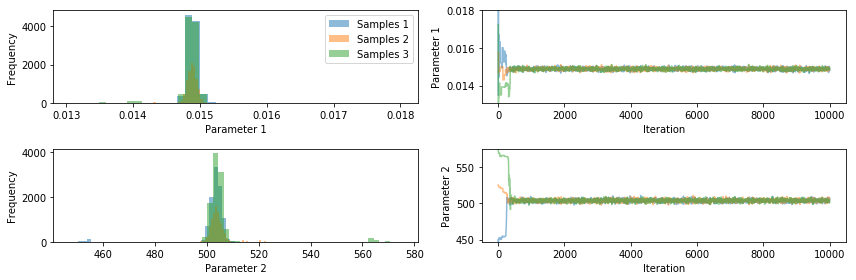

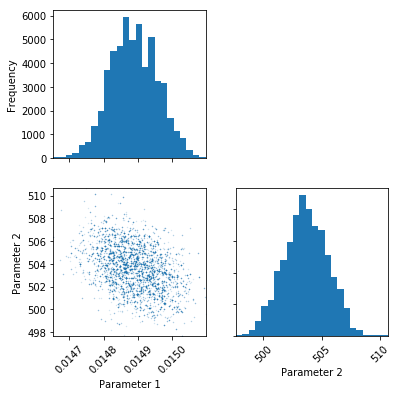

In [29]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0003454433806036, 1.0019001892007222]


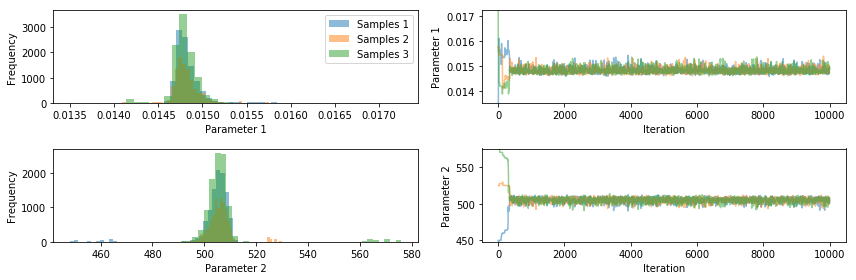

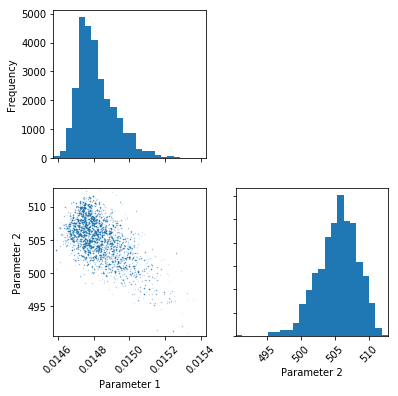

In [30]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [31]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

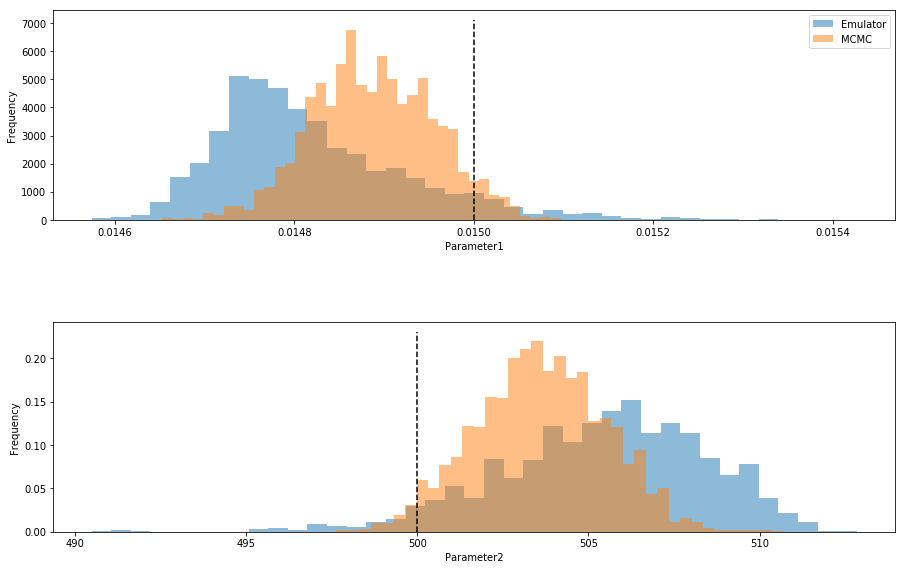

In [32]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

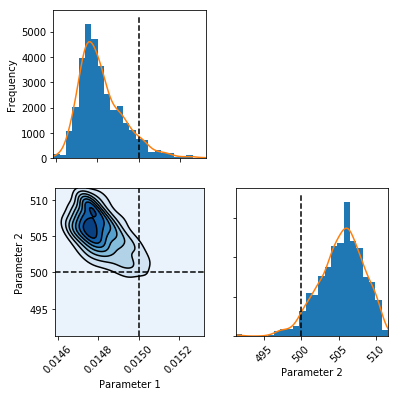

In [33]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

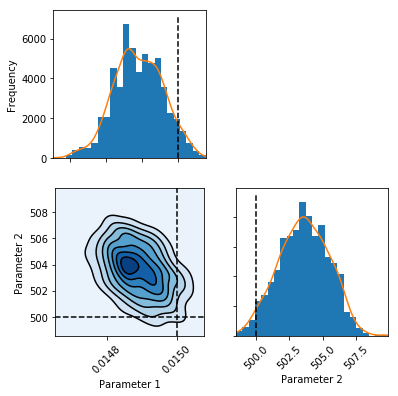

In [34]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

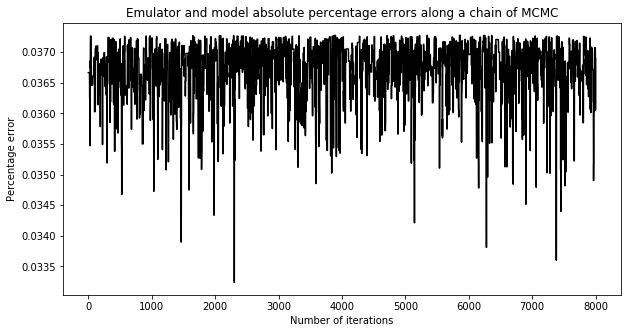

0.03673596471449713

In [35]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

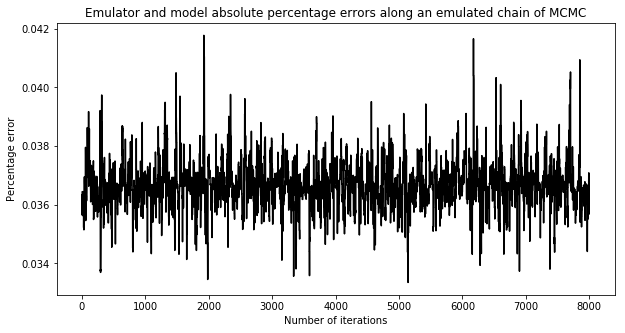

0.0366430766148069

In [36]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

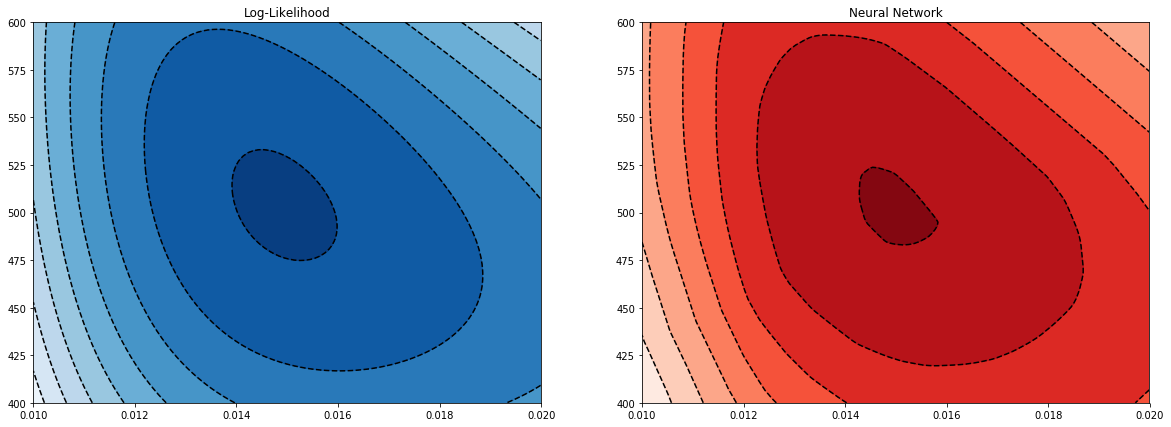

In [37]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

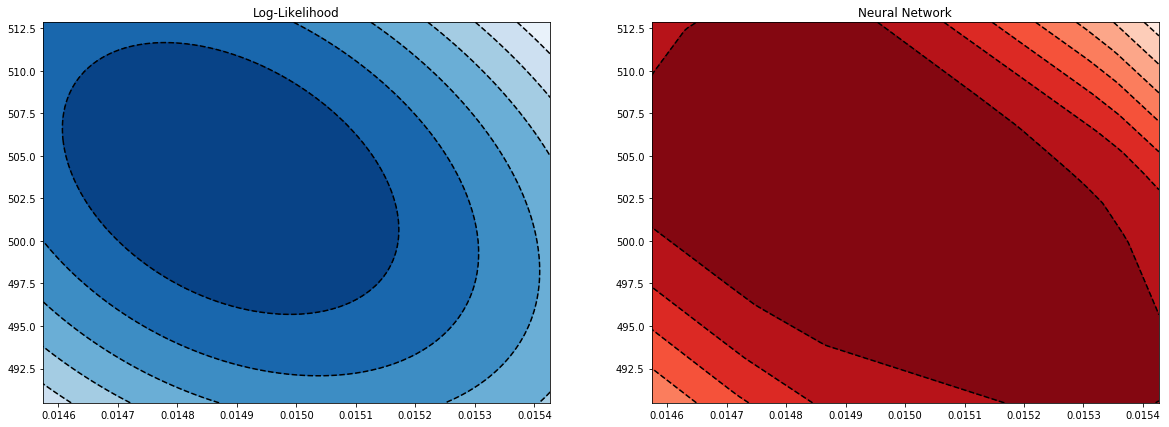

In [38]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

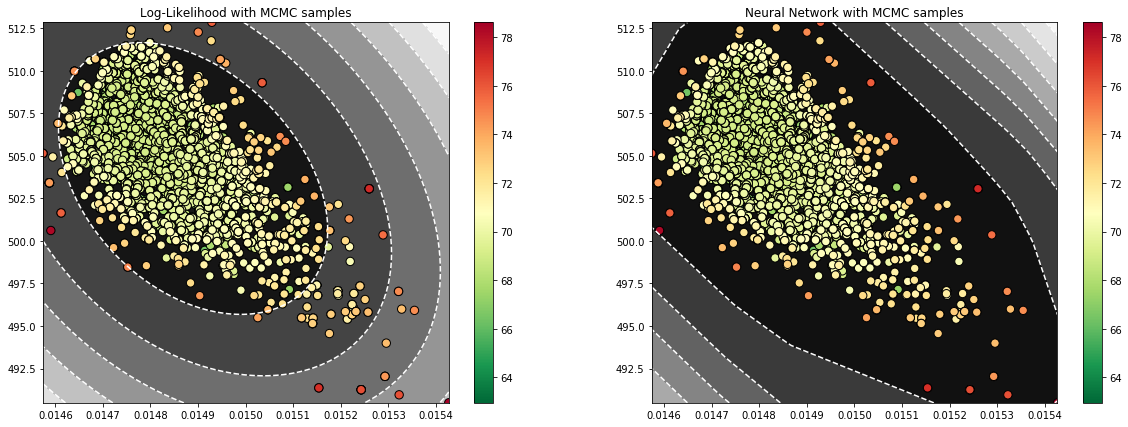

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours.png", bbox_inches='tight', dpi=600)

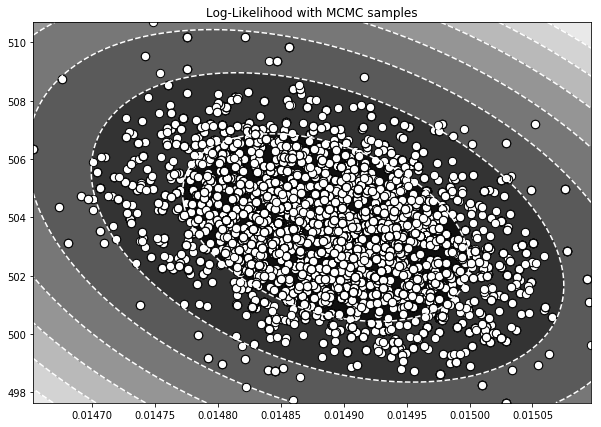

In [45]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()